In [3]:
import os
import numpy as np
import pandas as pd
import xarray as xr 
import seaborn as sns
import geopandas as gpd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.pyplot import figure
pd.set_option('display.max_rows', 500)

In [4]:
%config InlineBackend.figure_format = 'retina' # for clearer display on macs

In [5]:
data_in_path = '../2 Raw Data'
data_out_path = '../3 Output Data'
data_map = '../4 Mapping'
plots_out_path = '../zaf_EDA/CCDR_project_images'

In [6]:
colors = sns.color_palette("Set2")
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

## Find Food and Retail Branches

In [9]:
market_df = pd.read_csv(os.path.join(data_out_path,"zaf_final_data_10km_v0_SY.csv"), header=0)
market_df = market_df.drop(["Unnamed: 0"], axis=1)
display(market_df.head())

Long        Lat   GDP_PPP_mean   GDP_PPP_sum  population  nightlight  \
0  16.665417 -28.750416      25.461824  2.546182e+03    0.471344    0.044446   
1  16.665417 -28.833750     138.852110  1.388521e+04    0.990747    0.055383   
2  16.748750 -28.833750      11.218330  1.121833e+03    0.146418    0.039771   
3  16.748750 -28.917083      16.492558  1.649256e+03    0.509858    0.041680   
4  16.832083 -28.417083  119349.970000  1.193500e+07    1.583840    0.114101   

   hotdays  days_heat_index  temp  precip  precip_percnt            pc  
0     0.15              0.0  0.49   -4.72          -4.49  5.401958e+03  
1     0.15              0.0  0.49   -4.72          -4.49  1.401489e+04  
2     0.15              0.0  0.49   -4.72          -4.49  7.661835e+03  
3     0.15              0.0  0.49   -4.72          -4.49  3.234737e+03  
4     2.70              0.0  0.57    8.56           1.28  7.535480e+06

In [10]:
market_df.describe()

Long           Lat  GDP_PPP_mean   GDP_PPP_sum     population  \
count  11829.000000  11829.000000  1.182900e+04  1.182900e+04   11829.000000   
mean      26.088550    -28.827585  5.467552e+05  5.467552e+07    4238.388245   
std        3.590906      3.056162  3.014629e+06  3.014629e+08   22694.384705   
min       16.665417    -34.750416  3.232452e-01  3.232452e+01       0.021880   
25%       23.665417    -31.417083  2.491114e+03  2.491114e+05      27.830114   
50%       26.498750    -28.667083  1.743530e+04  1.743530e+06     142.274550   
75%       29.082083    -26.500416  1.950372e+05  1.950372e+07    1557.278700   
max       32.832083    -22.250416  8.911366e+07  8.911366e+09  687290.600000   

         nightlight       hotdays  days_heat_index          temp  \
count  1.182900e+04  11829.000000     11829.000000  11829.000000   
mean            inf     10.224313         0.103124      0.632634   
std             NaN      7.760074         0.526007      0.107691   
min   -1.308541e-03      0.000000         0.000000      0.400000   
25%    2.672737e-02      3.100000         0.000000      0.540000   
50%    5.463626e-02      8.800000         0.000000      0.630000   
75%    1.699427e-01     17.800000         0.000000      0.730000   
max             inf     25.650000         5.300000      0.870000   

             precip  precip_percnt            pc  
count  11829.000000   11829.000000  1.182900e+04  
mean     -17.123450      -0.882262  2.551331e+05  
std       68.226379       2.400129  1.245357e+07  
min     -251.740000      -7.290000  2.395827e-01  
25%      -45.890000      -2.290000  3.983786e+03  
50%      -21.100000      -0.430000  1.109849e+04  
75%       12.790000       0.580000  2.789084e+04  
max      213.930000       3.970000  1.345727e+09

In [11]:
print(market_df.shape)

(11829, 12)


In [8]:
# # round hot days to int
# market_df["hotdays1"] = market_df["hotdays1"].round(0).astype(int)

# # value counts
# market_df["hotdays1"].isnull().sum()

0

In [9]:
# define categories of the climate change variables
def hotdays_cat(x):
    if x < 5:
        return "0-5 days"
    elif x < 10:
        return "5-10 days"
    elif x < 15:
        return "10-15 days"
    elif x < 20:
        return "15-20 days"
    elif x < 25:
        return "20-25 days"
    else:
        return "over 25 days"

def temp_cat(x):
    if x < 0.45:
        return "less than 0.45 ℃"
    elif x < 0.5:
        return "0.45℃-0.5℃"


In [10]:
market_df["hotdays_cat"]=market_df.apply(lambda x: hotdays_cat(x["hotdays1"]),axis=1)
market_df["hotdays_cat"].value_counts(dropna=False, normalize=True)

0-10 days       0.483066
10-30 days      0.248814
30-50 days      0.119048
50-70 days      0.090026
Over 70 days    0.059045
Name: hotdays_cat, dtype: float64

Bar chart of hotdays category

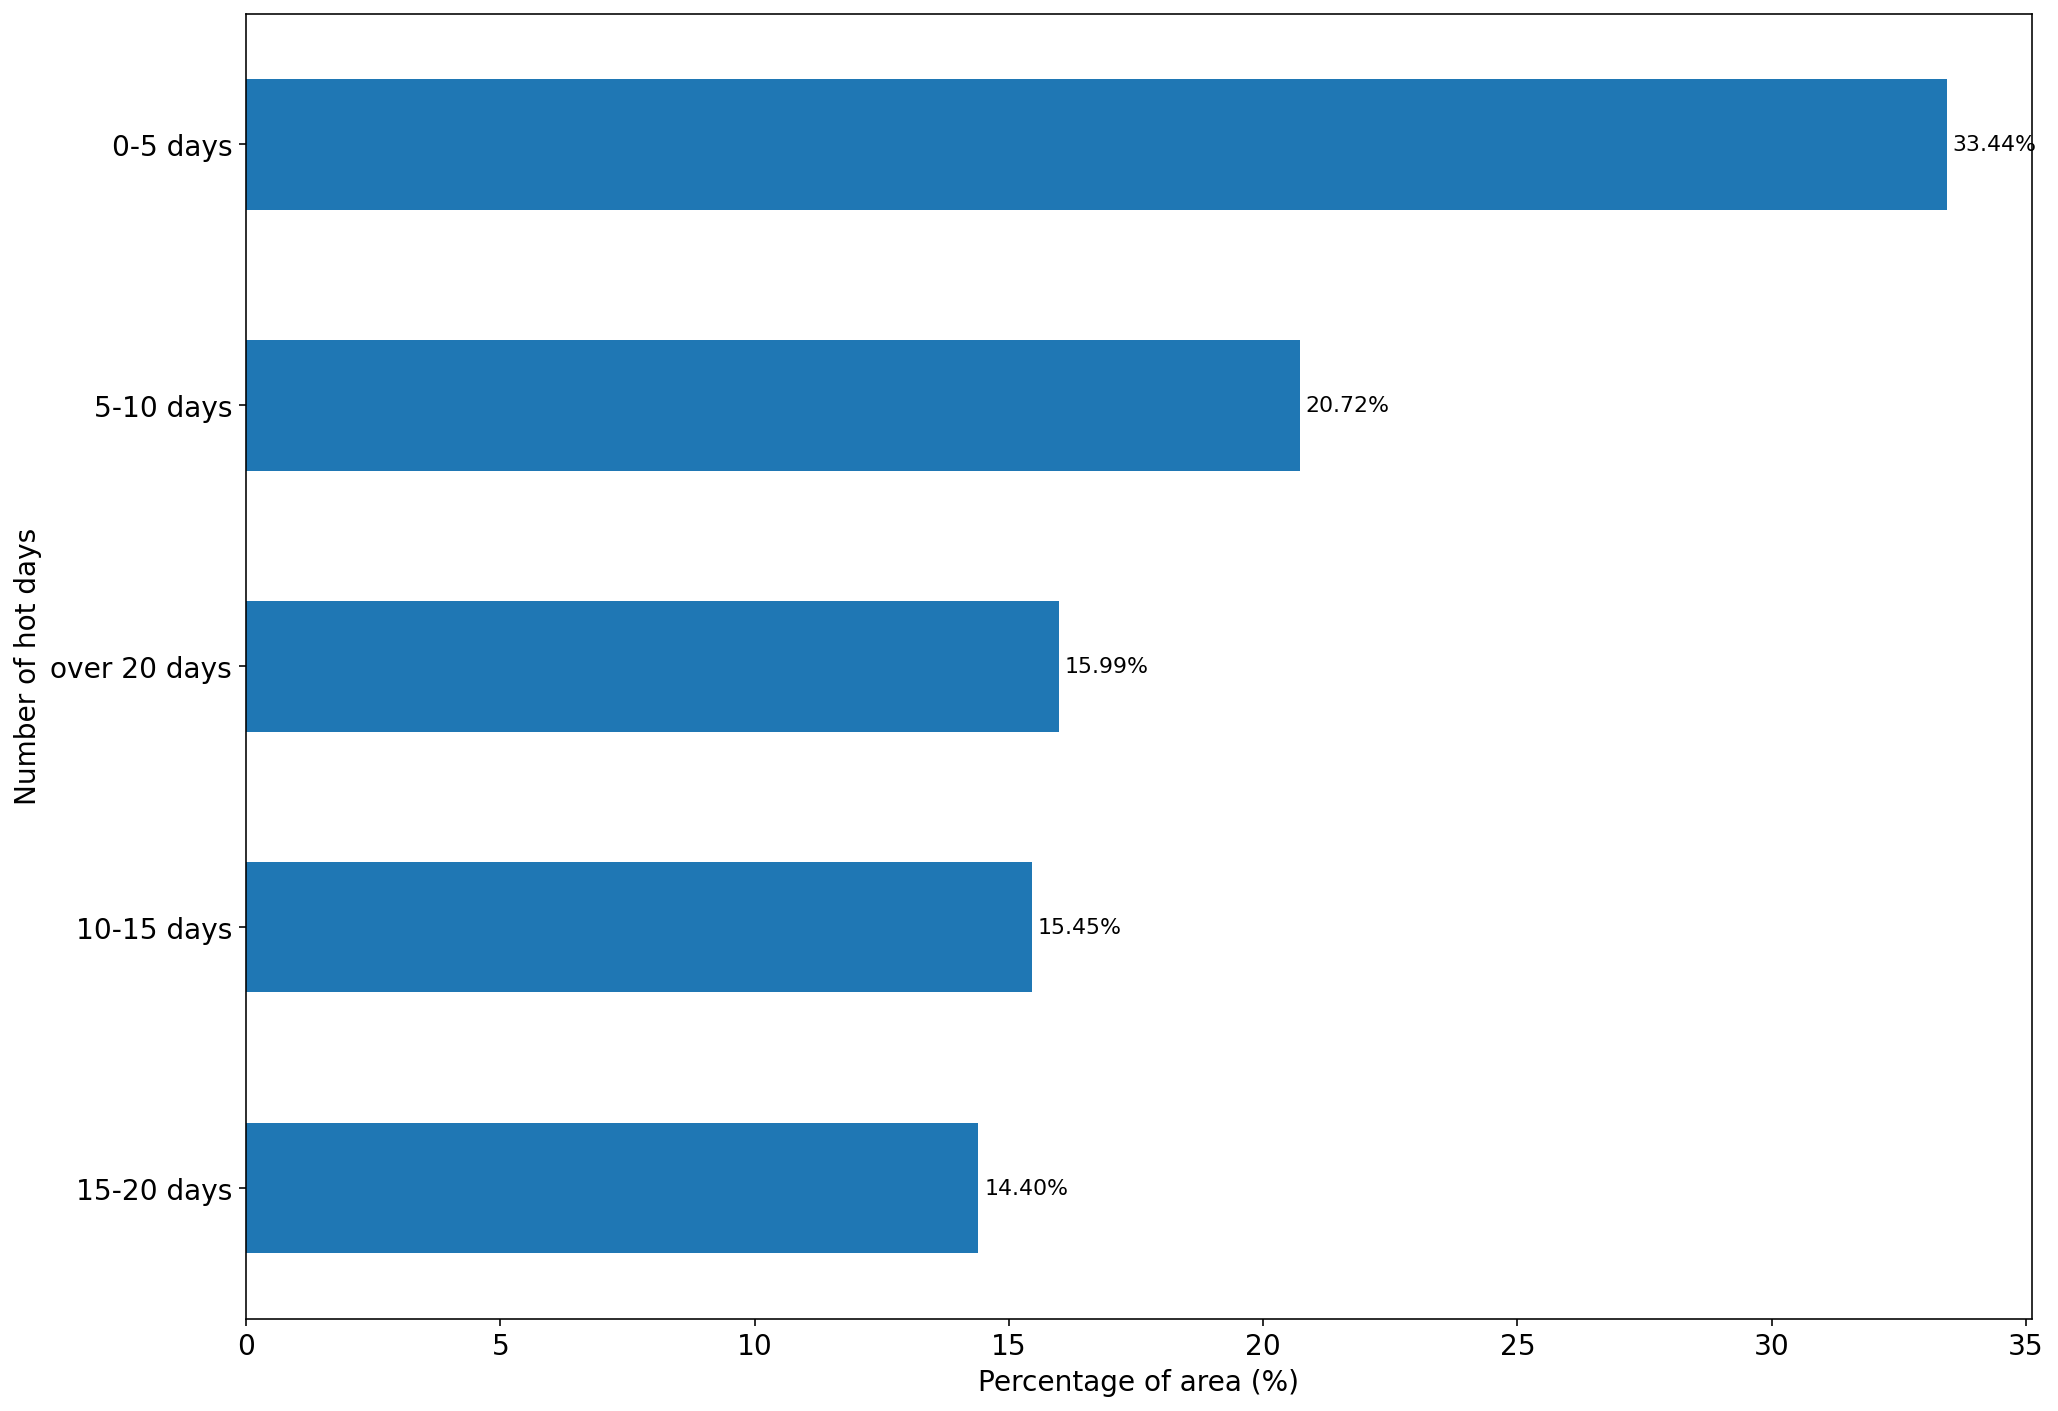

In [119]:
plt.rcParams.update({'font.size': 14})
ax = market_df["hotdays_cat"].value_counts(normalize=True).mul(100).sort_values().plot(kind = 'barh', figsize=(16,12))
ax.bar_label(ax.containers[0], fmt="%.2f%%", label_type='edge', padding=3, fontsize=11)
ax.set_xlabel('Percentage of area (%)')
ax.set_ylabel('Number of hot days')
ax.set_ylim(bottom=0)
# ax.set_title("Types of stores in Albania")
ax.set_ylim(bottom=-0.5)
plt.savefig(os.path.join(plots_out_path, "hotdays_perc.png"), dpi=300)
plt.show()

In [12]:
admin = gpd.read_file(os.path.join(data_in_path,
                                  "Administrative_Boundaries/zaf_admbnda_adm2_sadb_ocha_20201109.shp"))
admin.head()

Shape_Leng  Shape_Area       ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0   10.011065    1.010062    Alfred Nzo      ZA244     None       None   
1    5.053989    0.650090       Amajuba      ZA525     None       None   
2   16.253503    2.027643      Amathole      ZA212     None       None   
3    8.405694    1.645116      Bojanala      ZA637     None       None   
4    4.479120    0.265207  Buffalo City      ZA292     None       None   

  ADM2ALT2EN        ADM1_EN ADM1_PCODE       ADM0_EN ADM0_PCODE        date  \
0       None   Eastern Cape        ZA2  South Africa         ZA  2018-12-27   
1       None  KwaZulu-Natal        ZA5  South Africa         ZA  2018-12-27   
2       None   Eastern Cape        ZA2  South Africa         ZA  2018-12-27   
3       None     North West        ZA6  South Africa         ZA  2018-12-27   
4       None   Eastern Cape        ZA2  South Africa         ZA  2018-12-27   

      validOn validTo ADM1_ID ADM2_ID  \
0  2020-11-09    None      EC    DC44   
1  2020-11-09    None     KZN    DC25   
2  2020-11-09    None      EC    DC12   
3  2020-11-09    None      NW    DC37   
4  2020-11-09    None      EC     BUF   

                                            geometry  
0  POLYGON ((29.02187 -30.00443, 29.02401 -30.005...  
1  POLYGON ((30.39753 -27.27376, 30.39762 -27.273...  
2  POLYGON ((28.26665 -31.80154, 28.26809 -31.802...  
3  POLYGON ((27.03990 -24.87201, 27.04122 -24.886...  
4  POLYGON ((27.35458 -32.67444, 27.37057 -32.675...

In [14]:
admin["ADM1_EN"].value_counts()

KwaZulu-Natal    11
Eastern Cape      8
Western Cape      6
Limpopo           5
Gauteng           5
Free State        5
Nothern Cape      5
North West        4
Mpumalanga        3
Name: ADM1_EN, dtype: int64

In [16]:
def find_admin(lng, lat):
    point = Point(lng, lat)
    search_res = admin['geometry'].apply(lambda x: x.contains(point))
    if np.sum(search_res) == 0:
        return 'nan'
    else:
        return admin['ADM1_EN'][search_res].values[0]
market_df['loc_admin'] = market_df.apply(lambda row: find_admin(row['Long'], row['Lat']),axis=1)

In [17]:
market_df['loc_admin'].value_counts(dropna=False)

KwaZulu-Natal    50256
Eastern Cape     47911
Limpopo          34430
Free State       32287
Mpumalanga       28676
North West       25601
Western Cape     23763
Nothern Cape     18837
Gauteng          18385
nan               1538
Name: loc_admin, dtype: int64

In [18]:
market_df.to_csv(os.path.join(data_out_path, "data_with_states.csv"))

### aggregate GDP to state level

In [20]:
market_df.head()

Long        Lat       GDP_PPP  population  nightlight            pc  \
0  16.461250 -28.629583      40.84906    0.496830         inf      82.21932   
1  16.461250 -28.637916     138.43015    0.031538         inf    4389.32230   
2  16.469583 -28.596250  126738.35000    2.256491         inf   56166.13000   
3  16.469583 -28.604583   55504.90000    1.165269         inf   47632.69500   
4  16.469583 -28.612916   77558.82000    0.555839         inf  139534.66000   

   hotdays1   avgtemp1  precipitation1 hotdays_cat     loc_admin  
0         0  16.799999      128.869995   0-10 days  Nothern Cape  
1         0  16.799999      128.869995   0-10 days  Nothern Cape  
2         0  16.799999      128.869995   0-10 days  Nothern Cape  
3         0  16.799999      128.869995   0-10 days  Nothern Cape  
4         0  16.799999      128.869995   0-10 days  Nothern Cape

In [23]:
market_df[market_df["loc_admin"]=="nan"]

Long        Lat       GDP_PPP  population  nightlight  \
13      16.486250 -28.562916  1.327476e+05    4.711578         inf   
21      16.486250 -28.654583  2.287182e+02    0.220886         inf   
42      16.561250 -28.754583  7.512758e+01    0.001267         inf   
48      16.577917 -28.796250  2.169620e+02    0.005769         inf   
55      16.594583 -28.837916  2.760552e+02    0.007798         inf   
...           ...        ...           ...         ...         ...   
279563  32.327917 -26.854583  9.464473e+03    2.711307         inf   
279639  32.336250 -26.854583  3.852408e+05    5.498994         inf   
279712  32.344583 -26.854583  1.112007e+07   10.290705         inf   
281078  32.677917 -26.862916  3.631304e+04    7.099768         inf   
281682  32.886250 -26.854583  1.059373e+06   46.258816         inf   

                  pc  hotdays1   avgtemp1  precipitation1 hotdays_cat  \
13      2.817477e+04         0  16.799999      128.869995   0-10 days   
21      1.035459e+03         0  16.799999      128.869995   0-10 days   
42      5.927312e+04         0  17.889999      133.679993   0-10 days   
48      3.761063e+04         0  17.889999      133.679993   0-10 days   
55      3.540150e+04         0  17.889999      133.679993   0-10 days   
...              ...       ...        ...             ...         ...   
279563  3.490742e+03        38  23.000000     1298.040039  30-50 days   
279639  7.005659e+04        38  23.000000     1298.040039  30-50 days   
279712  1.080594e+06        38  23.000000     1298.040039  30-50 days   
281078  5.114679e+03         1  23.950001     1190.089966   0-10 days   
281682  2.290100e+04         1  23.950001     1190.089966   0-10 days   

       loc_admin  
13           nan  
21           nan  
42           nan  
48           nan  
55           nan  
...          ...  
279563       nan  
279639       nan  
279712       nan  
281078       nan  
281682       nan  

[1538 rows x 11 columns]

In [27]:
pd.set_option('display.float_format', lambda x: '%.5e' % x)
df_state = market_df.groupby(["loc_admin"])["GDP_PPP"].agg(['sum', 'mean', 'median']).reset_index()
df_state

loc_admin         sum        mean      median
0   Eastern Cape 7.47846e+10 1.56091e+06 2.68268e+05
1     Free State 3.05557e+10 9.46377e+05 2.44960e+04
2        Gauteng 1.94389e+11 1.05732e+07 3.01917e+05
3  KwaZulu-Natal 1.00591e+11 2.00158e+06 3.40730e+05
4        Limpopo 7.80118e+10 2.26581e+06 1.24283e+05
5     Mpumalanga 6.05783e+10 2.11251e+06 7.36949e+04
6     North West 5.28877e+10 2.06585e+06 1.38557e+05
7   Nothern Cape 1.45138e+10 7.70494e+05 1.74080e+04
8   Western Cape 7.40700e+10 3.11703e+06 1.02963e+05
9            nan 1.69483e+09 1.10197e+06 1.13817e+05

# --------------

### GDP and Population

In [19]:
# specify reference coordinates
# read in population 
pop_raw = xr.open_dataarray(os.path.join(data_in_path, "Population/Count/zaf_ppp_2015_1km_Aggregated.tif"))
# take a look at the data
display(pop_raw)
## Clean variables and dimensions
# select band index at 0 
pop = pop_raw.isel(band=0)
# drop extra coordinates dimensions beyond latitude and longtitude
pop = pop.reset_coords(names=['band'],drop=True)
pop.name = 'population'
# make population DataArray as the reference grids
ref_da = pop.copy()
ref_ds = ref_da.to_dataset()
ref_da

<xarray.DataArray 'band_data' (band: 1, y: 361, x: 215)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 19.26 19.27 19.28 19.29 ... 21.02 21.03 21.04 21.04
  * y            (y) float64 42.66 42.65 42.65 42.64 ... 39.69 39.68 39.67 39.66
    spatial_ref  int64 ...
Attributes:
    STATISTICS_MAXIMUM:  10706.296875
    STATISTICS_MEAN:     62.564358287462
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   376.06188412673

<xarray.DataArray 'population' (y: 361, x: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 19.26 19.27 19.28 19.29 ... 21.02 21.03 21.04 21.04
  * y            (y) float64 42.66 42.65 42.65 42.64 ... 39.69 39.68 39.67 39.66
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  10706.296875
    STATISTICS_MEAN:     62.564358287462
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   376.06188412673

In [20]:
df = pd.read_csv(os.path.join(data_out_path, "Albania_final_data_2015pop_2022_0704.csv"),index_col=0)
df.rename({"longitud": "Long", "lat":"Lat"}, axis=1, inplace=True)
df.head()

Long        Lat      GDP_PPP  population    nightlight           pc
0  19.277917  40.503750   97502.7000    1.304912           inf   74719.7660
1  19.277917  40.495417   22681.4200    1.710949  1.097055e-01   13256.6340
2  19.286250  40.495417  147962.3600    1.870997  3.402824e+36   79082.0900
3  19.286250  40.487083    2630.2646    1.440569  1.034958e-01    1825.8507
4  19.294583  40.495417  147962.3600    0.577256           inf  256320.3800

In [21]:
print(df.shape)
df = df[['Lat','Long','GDP_PPP','population', 'pc', 'nightlight']].copy()
df.head()

(13382, 6)


Lat       Long      GDP_PPP  population           pc    nightlight
0  40.503750  19.277917   97502.7000    1.304912   74719.7660           inf
1  40.495417  19.277917   22681.4200    1.710949   13256.6340  1.097055e-01
2  40.495417  19.286250  147962.3600    1.870997   79082.0900  3.402824e+36
3  40.487083  19.286250    2630.2646    1.440569    1825.8507  1.034958e-01
4  40.495417  19.294583  147962.3600    0.577256  256320.3800           inf

In [22]:
def find_grid_index(x,y,longs,lats,x_min=None,x_max=None,y_min=None,y_max=None):
    """
    DESCRIPTION: This function helps to find the index of the longitudes and 
    latitudes in the given longitude/latitude lists that is closest to the 
    given point (x,y) 
    
    INPUT -
    x: latitude of the given point
    y: longtidue of the given point
    longs: reference list of longitudes
    lats: reference list of latitudes
    x_min, x_max: min/max boundaries of longitude
    y_min, y_max: min/max boundaries of latitude
    
    OUTPUT -
    Index of the closest longitude/latitude to point (x,y)
    """
    if x_min is None and x_max is None:
        x_l = longs[0]- (longs[1]-longs[0])
        x_r = longs[-1] + (longs[-1]-longs[-2])
        x_min = min(x_l, x_r)
        x_max = max(x_l, x_r)
    if x < x_min or x > x_max:
        return -1,-1
    
    if y_min is None and y_max is None:
        y_l = lats[0]- (lats[1]-lats[0])
        y_r = lats[-1] + (lats[-1]-lats[-2])
        y_min = min(y_l, y_r)
        y_max = max(y_l, y_r)
    if y < y_min or y > y_max:
        return -1,-1
    
    ncol = np.argmin(abs(longs-x)) 
    nrow = np.argmin(abs(lats-y))
    if nrow<0 or nrow>=(len(lats)-1) or ncol<0 or ncol>=(len(longs)-1):
        return -1, -1
    else:
        return nrow,ncol

In [23]:
market_df.head(10)

name                                            address  \
0          Spar Albania  Tirana East Gate, Km 5°, 1045, Rruga e Elbasan...   
1                  Spar    8R98+6Q7, Rruga Perlat Rexhepi, Tiranë, Albania   
2  Spar Hypermarket QTU       9P3X+9JG, Rruga Industriale, Kashar, Albania   
3           Spar Market       8RH5+GX3, Rruga e Bogdanëve, Tirana, Albania   
4   Spar Komuna Parisit     8R74+F73, Rruga Medar Shtylla, Tirana, Albania   
5                  SPAR                    3GFC+83W, Shkodër 4001, Albania   
6      SPAR SUPERMARKET                           CFJV+8Q3, Vlorë, Albania   
7      Spar Pazari i Ri  8RHG+JGW, Rruga Tefta Tashko-Koço, Tirana, Alb...   
8  Spar Albania Elbasan         439Q+JCG, Rruga Lef Nosi, Elbasan, Albania   
9           Spar Market          8RMF+556, Rruga e Dibrës, Tirana, Albania   

                                               types        lat        lng  \
0  ['supermarket', 'grocery_or_supermarket', 'foo...  41.282983  19.857599   
1  ['supermarket', 'grocery_or_supermarket', 'foo...  41.318041  19.816914   
2  ['supermarket', 'grocery_or_supermarket', 'foo...  41.353432  19.749063   
3  ['grocery_or_supermarket', 'food', 'point_of_i...  41.328753  19.809930   
4  ['grocery_or_supermarket', 'food', 'point_of_i...  41.313647  19.805671   
5  ['grocery_or_supermarket', 'food', 'point_of_i...  42.073411  19.520272   
6  ['supermarket', 'grocery_or_supermarket', 'foo...  40.430756  19.494428   
7  ['supermarket', 'grocery_or_supermarket', 'foo...  41.329106  19.826313   
8  ['supermarket', 'grocery_or_supermarket', 'foo...  41.119070  20.088575   
9  ['food', 'point_of_interest', 'store', 'establ...  41.332917  19.822906   

  brand loc_admin  
0  Spar    Tirane  
1  Spar    Tirane  
2  Spar    Tirane  
3  Spar    Tirane  
4  Spar    Tirane  
5  Spar   Shkoder  
6  Spar     Vlore  
7  Spar    Tirane  
8  Spar   Elbasan  
9  Spar    Tirane

In [24]:
long_list = ref_da.coords['x'].values
lat_list = ref_da.coords['y'].values
long_list = np.append(long_list, long_list[-1]+ref_da.rio.resolution()[0])
lat_list = np.append(lat_list, lat_list[-1]+ref_da.rio.resolution()[1])
grid_index = market_df.apply(lambda row: find_grid_index(row['lng'],row['lat'],long_list,lat_list), axis=1)
grid_index
market_df['grid_lat'] = grid_index.apply(lambda x:lat_list[x[0]])
market_df['grid_long'] = grid_index.apply(lambda x:long_list[x[1]])
market_df.head(10)

name                                            address  \
0          Spar Albania  Tirana East Gate, Km 5°, 1045, Rruga e Elbasan...   
1                  Spar    8R98+6Q7, Rruga Perlat Rexhepi, Tiranë, Albania   
2  Spar Hypermarket QTU       9P3X+9JG, Rruga Industriale, Kashar, Albania   
3           Spar Market       8RH5+GX3, Rruga e Bogdanëve, Tirana, Albania   
4   Spar Komuna Parisit     8R74+F73, Rruga Medar Shtylla, Tirana, Albania   
5                  SPAR                    3GFC+83W, Shkodër 4001, Albania   
6      SPAR SUPERMARKET                           CFJV+8Q3, Vlorë, Albania   
7      Spar Pazari i Ri  8RHG+JGW, Rruga Tefta Tashko-Koço, Tirana, Alb...   
8  Spar Albania Elbasan         439Q+JCG, Rruga Lef Nosi, Elbasan, Albania   
9           Spar Market          8RMF+556, Rruga e Dibrës, Tirana, Albania   

                                               types        lat        lng  \
0  ['supermarket', 'grocery_or_supermarket', 'foo...  41.282983  19.857599   
1  ['supermarket', 'grocery_or_supermarket', 'foo...  41.318041  19.816914   
2  ['supermarket', 'grocery_or_supermarket', 'foo...  41.353432  19.749063   
3  ['grocery_or_supermarket', 'food', 'point_of_i...  41.328753  19.809930   
4  ['grocery_or_supermarket', 'food', 'point_of_i...  41.313647  19.805671   
5  ['grocery_or_supermarket', 'food', 'point_of_i...  42.073411  19.520272   
6  ['supermarket', 'grocery_or_supermarket', 'foo...  40.430756  19.494428   
7  ['supermarket', 'grocery_or_supermarket', 'foo...  41.329106  19.826313   
8  ['supermarket', 'grocery_or_supermarket', 'foo...  41.119070  20.088575   
9  ['food', 'point_of_interest', 'store', 'establ...  41.332917  19.822906   

  brand loc_admin   grid_lat  grid_long  
0  Spar    Tirane  41.287083  19.861250  
1  Spar    Tirane  41.320417  19.819583  
2  Spar    Tirane  41.353750  19.752917  
3  Spar    Tirane  41.328750  19.811250  
4  Spar    Tirane  41.312083  19.802917  
5  Spar   Shkoder  42.070417  19.519583  
6  Spar     Vlore  40.428750  19.494583  
7  Spar    Tirane  41.328750  19.827917  
8  Spar   Elbasan  41.120417  20.086250  
9  Spar    Tirane  41.328750  19.819583

In [25]:
market_df['grid_lat_5digits'] = np.round(market_df['grid_lat'],5)
market_df['grid_long_5digits'] = np.round(market_df['grid_long'],5)

df['Lat_5digits'] = np.round(df['Lat'],5)
df['Long_5digits'] = np.round(df['Long'],5)

market_df = market_df.merge(df, how='inner',left_on=['grid_lat_5digits','grid_long_5digits'],right_on=['Lat_5digits','Long_5digits'])
market_df = market_df.drop(['grid_lat','grid_long','grid_lat_5digits','grid_long_5digits','Lat_5digits','Long_5digits'],axis=1)
market_df = market_df.rename({'Lat':'grid_lat','Long':'grid_lng'},axis=1)
market_df.head()

name                                            address  \
0    Spar Albania  Tirana East Gate, Km 5°, 1045, Rruga e Elbasan...   
1            Spar    8R98+6Q7, Rruga Perlat Rexhepi, Tiranë, Albania   
2            Spar    MCN Tower, Rruga Ismail Qemali, Tirana, Albania   
3           Conad                          8RFF+H7X, Tirana, Albania   
4  Conad Akademia    8R89+WJ7, Rruga Ibrahim Rugova, Tirana, Albania   

                                               types        lat        lng  \
0  ['supermarket', 'grocery_or_supermarket', 'foo...  41.282983  19.857599   
1  ['supermarket', 'grocery_or_supermarket', 'foo...  41.318041  19.816914   
2  ['grocery_or_supermarket', 'food', 'point_of_i...  41.321775  19.823642   
3  ['supermarket', 'grocery_or_supermarket', 'sto...  41.323986  19.823236   
4  ['supermarket', 'grocery_or_supermarket', 'sto...  41.317293  19.819046   

   brand loc_admin   grid_lat   grid_lng      GDP_PPP  population         pc  \
0   Spar    Tirane  41.287083  19.861250   15682235.0    928.5934  16888.162   
1   Spar    Tirane  41.320417  19.819583  161241490.0   9611.0540  16776.672   
2   Spar    Tirane  41.320417  19.819583  161241490.0   9611.0540  16776.672   
3  Conad    Tirane  41.320417  19.819583  161241490.0   9611.0540  16776.672   
4  Conad    Tirane  41.320417  19.819583  161241490.0   9611.0540  16776.672   

   nightlight  
0    9.645451  
1   97.426476  
2   97.426476  
3   97.426476  
4   97.426476

In [37]:
market_df.describe()

Long            Lat       GDP_PPP     population  \
count  281684.000000  281684.000000  2.816840e+05  281684.000000   
mean       27.472756     -28.409118  2.421425e+06     184.508184   
std         3.414902       3.028592  1.026300e+07     798.210930   
min        16.461250     -34.837916  1.905612e-02       0.000037   
25%        26.169583     -30.804583  1.690940e+04       1.363684   
50%        28.269583     -28.096250  1.172157e+05       7.807243   
75%        29.911250     -26.012916  8.584861e+05      59.603566   
max        32.886250     -22.129583  8.185887e+08   52822.450000   

         nightlight            pc       hotdays1       avgtemp1  
count  2.816840e+05  2.816840e+05  281684.000000  281684.000000  
mean            inf  2.209107e+05      21.210406      18.819405  
std             NaN  1.977771e+07      25.148546       2.092040  
min   -2.759759e-02  1.142091e-02       0.000000      12.260000  
25%    5.181886e-02  5.874852e+03       3.000000      17.500000  
50%    1.503394e-01  1.394731e+04      13.000000      18.559999  
75%    6.745845e-01  3.499127e+04      32.000000      20.379999  
max             inf  9.298812e+09     125.000000      24.440001

## Hot days

In [137]:
market_df.describe()

Long           Lat  GDP_PPP_mean   GDP_PPP_sum     population  \
count  11829.000000  11829.000000  1.182900e+04  1.182900e+04   11829.000000   
mean      26.088550    -28.827585  5.467552e+05  5.467552e+07    4238.388245   
std        3.590906      3.056162  3.014629e+06  3.014629e+08   22694.384705   
min       16.665417    -34.750416  3.232452e-01  3.232452e+01       0.021880   
25%       23.665417    -31.417083  2.491114e+03  2.491114e+05      27.830114   
50%       26.498750    -28.667083  1.743530e+04  1.743530e+06     142.274550   
75%       29.082083    -26.500416  1.950372e+05  1.950372e+07    1557.278700   
max       32.832083    -22.250416  8.911366e+07  8.911366e+09  687290.600000   

         nightlight       hotdays  days_heat_index          temp  \
count  1.182900e+04  11829.000000     11829.000000  11829.000000   
mean            inf     10.224313         0.103124      0.632634   
std             NaN      7.760074         0.526007      0.107691   
min   -1.308541e-03      0.000000         0.000000      0.400000   
25%    2.672737e-02      3.100000         0.000000      0.540000   
50%    5.463626e-02      8.800000         0.000000      0.630000   
75%    1.699427e-01     17.800000         0.000000      0.730000   
max             inf     25.650000         5.300000      0.870000   

             precip  precip_percnt            pc  
count  11829.000000   11829.000000  1.182900e+04  
mean     -17.123450      -0.882262  2.551331e+05  
std       68.226379       2.400129  1.245357e+07  
min     -251.740000      -7.290000  2.395827e-01  
25%      -45.890000      -2.290000  3.983786e+03  
50%      -21.100000      -0.430000  1.109849e+04  
75%       12.790000       0.580000  2.789084e+04  
max      213.930000       3.970000  1.345727e+09

In [138]:
# define categories of the climate change variables
def hotdays_cat(x):
    if x < 5:
        return "0-5 days"
    elif x < 10:
        return "5-10 days"
    elif x < 15:
        return "10-15 days"
    elif x < 20:
        return "15-20 days"
    else:
        return "over 20 days"


def hotdays_cat_median(x):
    if x < 9:
        return "below median"
    else:
        return "above median"


def hotdays_cat_mean(x):
    if x < 10:
        return "below mean"
    else:
        return "above mean"


In [139]:
market_df["hotdays_cat"]=market_df.apply(lambda x: hotdays_cat(x["hotdays"]),axis=1)
market_df["hotdays_cat_median"]=market_df.apply(lambda x: hotdays_cat_median(x["hotdays"]),axis=1)
market_df["hotdays_cat_mean"]=market_df.apply(lambda x: hotdays_cat_mean(x["hotdays"]),axis=1)
# test = market_df["hotdays_cat"].value_counts(dropna=False, normalize=True)
# # test = test.reindex(['0-5 days', '5-10 days', '10-15 days', '15-20 days', 'over 20 days'])
# test

Bar chart of hotdays category

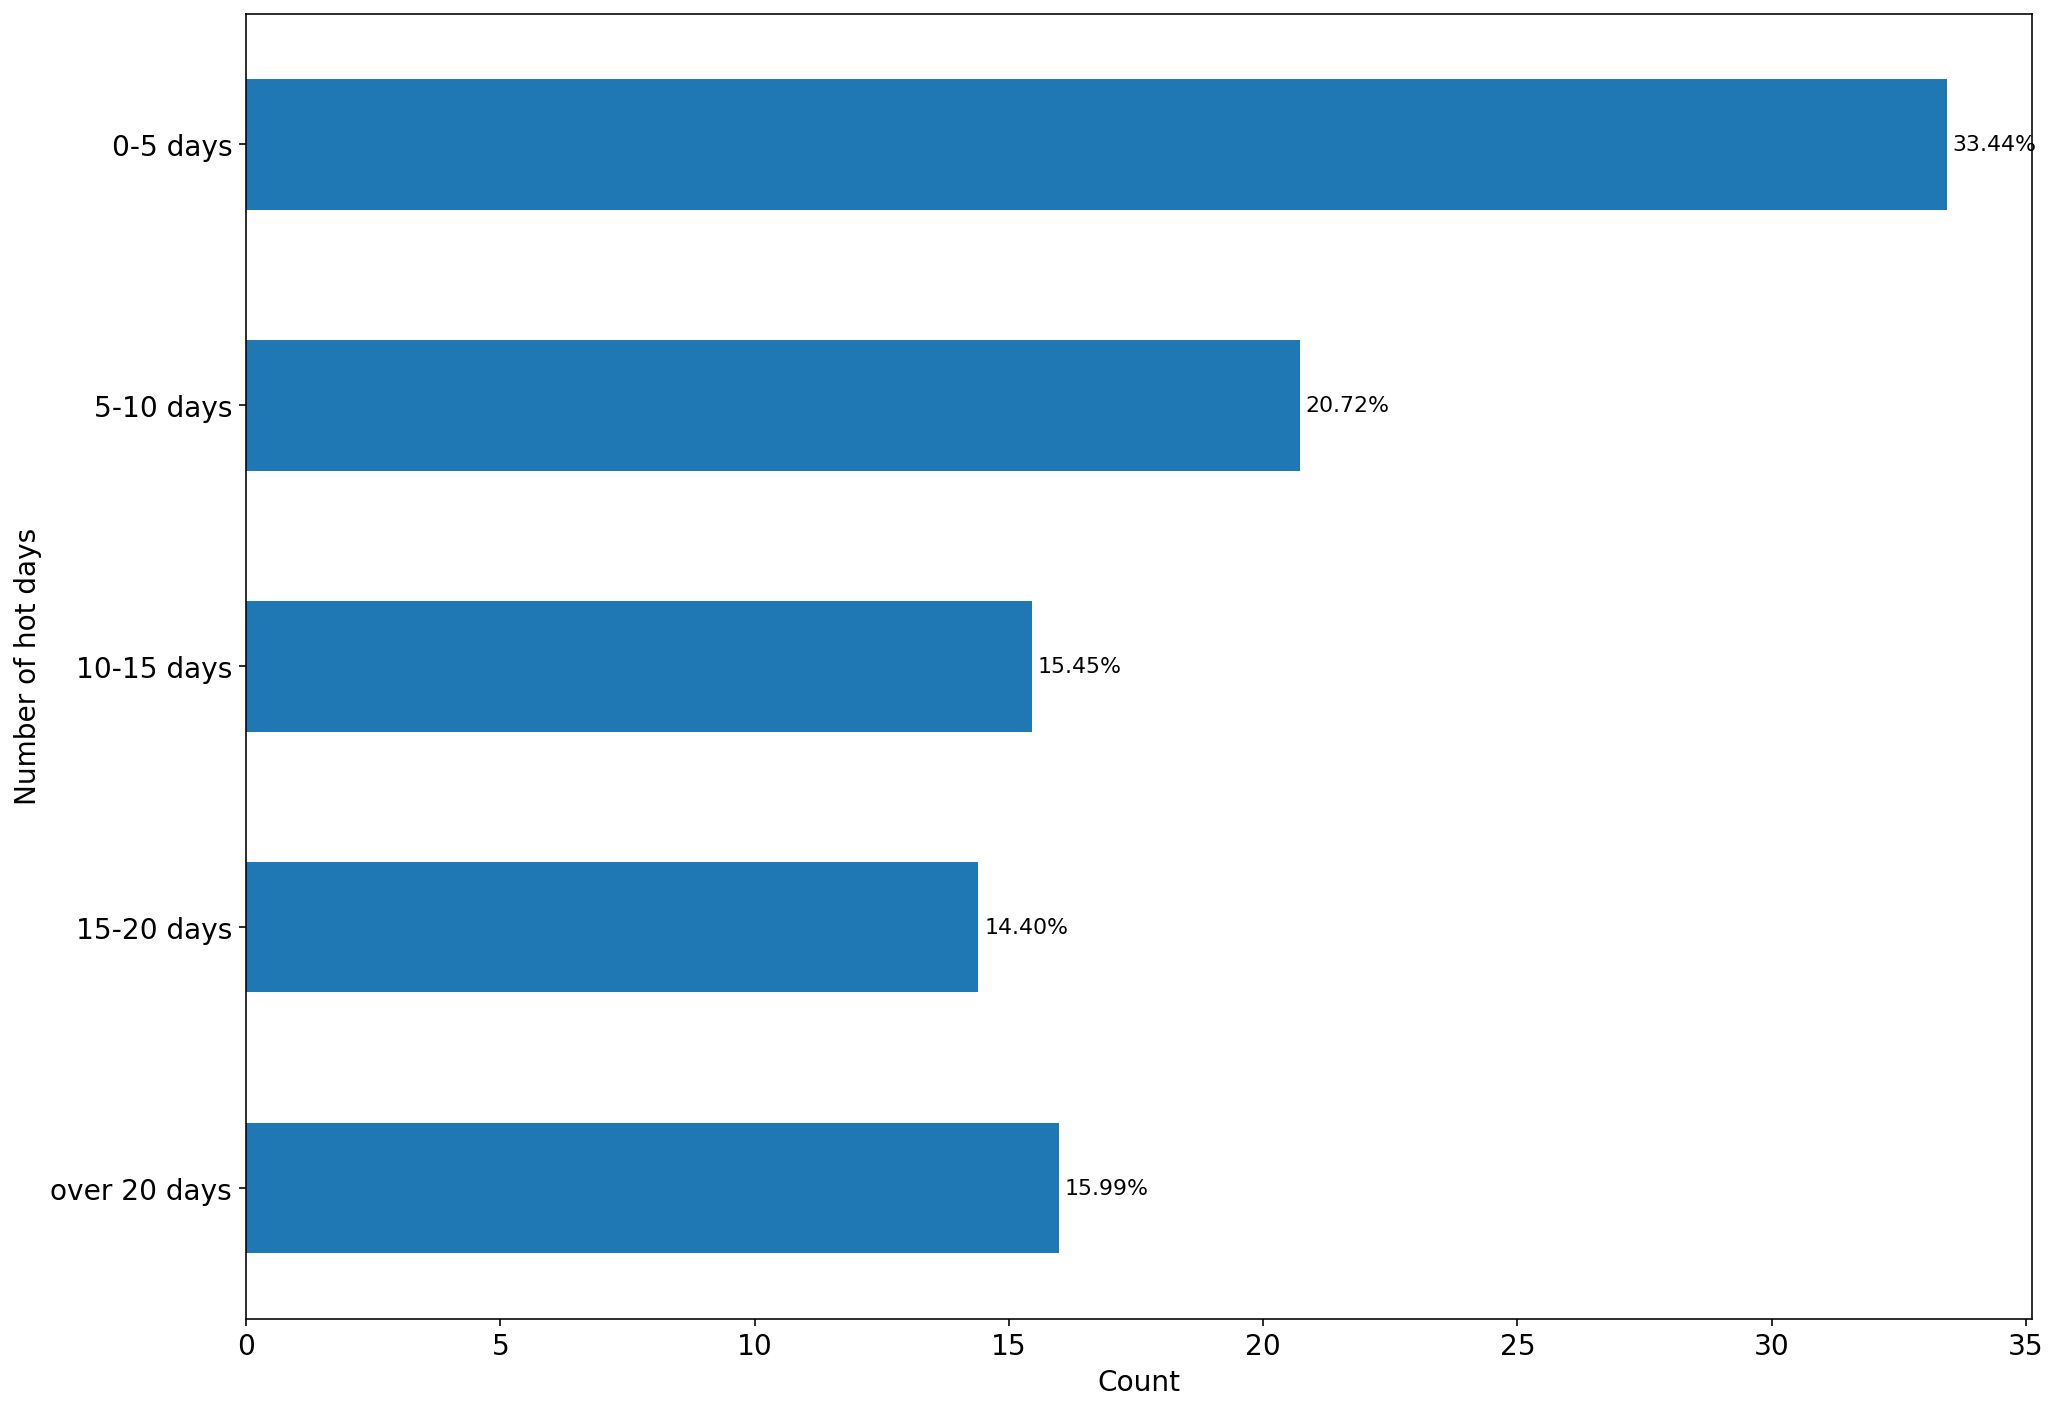

In [120]:
plt.rcParams.update({'font.size': 14})
order = ['0-5 days', '5-10 days', '10-15 days', '15-20 days', 'over 20 days']
test_df = pd.DataFrame(test, index=order)
ax = test_df.loc[order].mul(100).plot(kind = 'barh', figsize=(16,12), label="Numbe of hot days")
ax.bar_label(ax.containers[0], fmt="%.2f%%", label_type='edge', padding=3, fontsize=11)
ax.set_xlabel('Count')
ax.set_ylabel('Number of hot days')
ax.set_ylim(bottom=0)
# ax.set_title("Types of stores in Albania")
ax.set_ylim(bottom=-0.5)
ax.invert_yaxis()
# h,l =ax.get_legend_handles_labels()
ax.legend().set_visible(False)
plt.savefig(os.path.join(plots_out_path, "hotdays_perc.png"), dpi=300)
plt.show()

### fold

In [16]:
market_df[market_df["hotdays_cat"] == "0-10 days"].describe()

Long            Lat       GDP_PPP     population  \
count  136072.000000  136072.000000  1.360720e+05  136072.000000   
mean       28.071738     -29.834345  2.081884e+06     175.782455   
std         3.515116       2.698257  8.253155e+06     740.042514   
min        16.461250     -34.837916  5.324641e-01       0.000292   
25%        27.694583     -31.929583  3.016501e+04       2.615323   
50%        29.086250     -29.746250  1.896263e+05      14.065573   
75%        30.252917     -27.787916  1.055356e+06      81.938020   
max        32.886250     -24.504583  2.696044e+08   26113.926000   

         nightlight            pc       hotdays1       avgtemp1  \
count  1.360720e+05  1.360720e+05  136072.000000  136072.000000   
mean            inf  1.046939e+05       3.000786      17.910159   
std             NaN  2.407829e+06       2.805677       1.861297   
min   -2.759759e-02  5.837040e-02       0.000000      12.260000   
25%    6.475871e-02  5.419259e+03       0.000000      17.020000   
50%    1.605122e-01  1.243203e+04       3.000000      17.620001   
75%    5.611072e-01  2.942067e+04       6.000000      18.950001   
max             inf  4.405066e+08       8.000000      23.950001   

       drought_index1  
count   136072.000000  
mean        -0.028402  
std          0.052543  
min         -0.400000  
25%         -0.060000  
50%          0.000000  
75%          0.000000  
max          0.020000

In [17]:
GDPtop20 = market_df.sort_values(by=["GDP_PPP"], ascending=False).head(20)
GDPtop20

Long        Lat      GDP_PPP  population  nightlight          pc  \
130910  28.044583 -26.187916  818588740.0  37472.1640   64.339905   21845.248   
133200  28.094583 -26.104583  555812860.0  41654.8300   51.859360   13343.300   
133570  28.102917 -26.104583  555812860.0  35329.7600   50.096330   15732.143   
130911  28.044583 -26.196250  460977000.0  20241.6250   88.306786   22773.715   
131298  28.052917 -26.196250  460977000.0  27154.8520   61.480980   16975.861   
132830  28.086250 -26.104583  451648500.0  15721.8410   46.827953   28727.457   
137174  28.186250 -26.012916  330080060.0  22298.7600   38.746220   14802.620   
136808  28.177917 -26.012916  330080060.0  24063.7340   38.038760   13716.909   
129344  28.011250 -25.929583  319689900.0  25918.9550   24.023693   12334.212   
131677  28.061250 -26.187916  313052350.0  17331.2600   42.155087   18062.873   
131297  28.052917 -26.187916  313052350.0  52822.4500   50.663284    5926.502   
133571  28.102917 -26.112916  311538000.0  19272.7660   40.827760   16164.675   
129343  28.011250 -25.921250  295023170.0  11842.1340   24.830511   24913.008   
128963  28.002917 -25.921250  295023170.0    407.6566   16.535840  723705.100   
137887  28.202917 -25.987916  276296420.0  21060.2420   35.633503   13119.337   
137525  28.194583 -25.987916  276296420.0  12072.9430   25.235490   22885.588   
128964  28.002917 -25.929583  271626020.0  17166.4980   29.415552   15823.030   
128564  27.994583 -25.929583  271626020.0   2474.7126   10.577737  109760.625   
6357    18.661250 -34.012916  269604380.0   5133.5910   33.526478   52517.700   
6358    18.661250 -34.021250  269578270.0  26113.9260   65.930220   10323.161   

        hotdays1  avgtemp1  drought_index1 hotdays_cat  
130910        13     18.23           -0.07  10-30 days  
133200        13     18.23           -0.07  10-30 days  
133570        13     18.23           -0.07  10-30 days  
130911        13     18.23           -0.07  10-30 days  
131298        13     18.23           -0.07  10-30 days  
132830        13     18.23           -0.07  10-30 days  
137174        13     18.23           -0.07  10-30 days  
136808        13     18.23           -0.07  10-30 days  
129344        13     18.23           -0.07  10-30 days  
131677        13     18.23           -0.07  10-30 days  
131297        13     18.23           -0.07  10-30 days  
133571        13     18.23           -0.07  10-30 days  
129343        13     18.23           -0.07  10-30 days  
128963        13     18.23           -0.07  10-30 days  
137887        13     18.23           -0.07  10-30 days  
137525        13     18.23           -0.07  10-30 days  
128964        13     18.23           -0.07  10-30 days  
128564        13     18.23           -0.07  10-30 days  
6357           1     17.10            0.00   0-10 days  
6358           1     17.10            0.00   0-10 days

In [18]:
def find_admin(lng, lat):
    point = Point(lng, lat)
    search_res = admin['geometry'].apply(lambda x: x.contains(point))
    if np.sum(search_res) == 0:
        return 'nan'
    else:
        return admin['ADM1_EN'][search_res].values[0]
GDPtop20['loc_admin'] = GDPtop20.apply(lambda row: find_admin(row['Long'], row['Lat']),axis=1)
GDPtop20

Long        Lat      GDP_PPP  population  nightlight          pc  \
130910  28.044583 -26.187916  818588740.0  37472.1640   64.339905   21845.248   
133200  28.094583 -26.104583  555812860.0  41654.8300   51.859360   13343.300   
133570  28.102917 -26.104583  555812860.0  35329.7600   50.096330   15732.143   
130911  28.044583 -26.196250  460977000.0  20241.6250   88.306786   22773.715   
131298  28.052917 -26.196250  460977000.0  27154.8520   61.480980   16975.861   
132830  28.086250 -26.104583  451648500.0  15721.8410   46.827953   28727.457   
137174  28.186250 -26.012916  330080060.0  22298.7600   38.746220   14802.620   
136808  28.177917 -26.012916  330080060.0  24063.7340   38.038760   13716.909   
129344  28.011250 -25.929583  319689900.0  25918.9550   24.023693   12334.212   
131677  28.061250 -26.187916  313052350.0  17331.2600   42.155087   18062.873   
131297  28.052917 -26.187916  313052350.0  52822.4500   50.663284    5926.502   
133571  28.102917 -26.112916  311538000.0  19272.7660   40.827760   16164.675   
129343  28.011250 -25.921250  295023170.0  11842.1340   24.830511   24913.008   
128963  28.002917 -25.921250  295023170.0    407.6566   16.535840  723705.100   
137887  28.202917 -25.987916  276296420.0  21060.2420   35.633503   13119.337   
137525  28.194583 -25.987916  276296420.0  12072.9430   25.235490   22885.588   
128964  28.002917 -25.929583  271626020.0  17166.4980   29.415552   15823.030   
128564  27.994583 -25.929583  271626020.0   2474.7126   10.577737  109760.625   
6357    18.661250 -34.012916  269604380.0   5133.5910   33.526478   52517.700   
6358    18.661250 -34.021250  269578270.0  26113.9260   65.930220   10323.161   

        hotdays1  avgtemp1  drought_index1 hotdays_cat     loc_admin  
130910        13     18.23           -0.07  10-30 days       Gauteng  
133200        13     18.23           -0.07  10-30 days       Gauteng  
133570        13     18.23           -0.07  10-30 days       Gauteng  
130911        13     18.23           -0.07  10-30 days       Gauteng  
131298        13     18.23           -0.07  10-30 days       Gauteng  
132830        13     18.23           -0.07  10-30 days       Gauteng  
137174        13     18.23           -0.07  10-30 days       Gauteng  
136808        13     18.23           -0.07  10-30 days       Gauteng  
129344        13     18.23           -0.07  10-30 days       Gauteng  
131677        13     18.23           -0.07  10-30 days       Gauteng  
131297        13     18.23           -0.07  10-30 days       Gauteng  
133571        13     18.23           -0.07  10-30 days       Gauteng  
129343        13     18.23           -0.07  10-30 days       Gauteng  
128963        13     18.23           -0.07  10-30 days       Gauteng  
137887        13     18.23           -0.07  10-30 days       Gauteng  
137525        13     18.23           -0.07  10-30 days       Gauteng  
128964        13     18.23           -0.07  10-30 days       Gauteng  
128564        13     18.23           -0.07  10-30 days       Gauteng  
6357           1     17.10            0.00   0-10 days  Western Cape  
6358           1     17.10            0.00   0-10 days  Western Cape

In [34]:
topdays = market_df[market_df["hotdays_cat"] == "Over 70 days"]
topdays['loc_admin'] = topdays.apply(lambda row: find_admin(row['Long'], row['Lat']),axis=1)
topdays

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_28700/2760759190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topdays['loc_admin'] = topdays.apply(lambda row: find_admin(row['Long'], row['Lat']),axis=1)


Long        Lat      GDP_PPP  population  nightlight  \
4302    18.502917 -28.887916   23450.7320    1.099843         inf   
4303    18.502917 -28.896250  148015.7200    4.481047    0.021817   
4304    18.502917 -29.071250    3265.3035    0.002583    0.028849   
4403    18.511250 -28.887916   65936.9300    1.300937         inf   
4404    18.511250 -28.896250  142960.9800    6.322208    0.030416   
...           ...        ...          ...         ...         ...   
275283  31.969583 -24.412916    1441.8903    0.003795    0.003411   
275369  31.977917 -24.454583    1512.8146    2.642165    0.083286   
275370  31.977917 -24.462916     693.0794    0.262594    0.015329   
275571  31.994583 -24.454583    1600.4468    1.047734    0.014114   
275668  32.002917 -24.454583     329.8415    0.201520    0.008755   

                  pc  hotdays1   avgtemp1  drought_index1   hotdays_cat  \
4302    2.132188e+04        92  21.049999           -0.23  Over 70 days   
4303    3.303150e+04        92  21.049999           -0.23  Over 70 days   
4304    1.264109e+06        92  21.049999           -0.23  Over 70 days   
4403    5.068417e+04        92  21.049999           -0.23  Over 70 days   
4404    2.261251e+04        92  21.049999           -0.23  Over 70 days   
...              ...       ...        ...             ...           ...   
275283  3.798964e+05        79  24.340000            0.02  Over 70 days   
275369  5.725664e+02        79  24.340000            0.02  Over 70 days   
275370  2.639355e+03        79  24.340000            0.02  Over 70 days   
275571  1.527532e+03        79  24.340000            0.02  Over 70 days   
275668  1.636764e+03        79  24.340000            0.02  Over 70 days   

        temp_cat     loc_admin  
4302    Over 75%           nan  
4303    Over 75%  Nothern Cape  
4304    Over 75%  Nothern Cape  
4403    Over 75%           nan  
4404    Over 75%  Nothern Cape  
...          ...           ...  
275283  Over 75%    Mpumalanga  
275369  Over 75%    Mpumalanga  
275370  Over 75%    Mpumalanga  
275571  Over 75%    Mpumalanga  
275668  Over 75%    Mpumalanga  

[16632 rows x 12 columns]

In [35]:
topdays.describe()

Long           Lat       GDP_PPP    population    nightlight  \
count  16632.000000  16632.000000  1.663200e+04  16632.000000  1.663200e+04   
mean      24.455866    -26.436848  9.885150e+05     63.557153           inf   
std        3.817976      2.475808  3.695824e+06    274.758621           NaN   
min       18.502917    -30.496250  6.121982e-01      0.000233 -2.053474e-02   
25%       21.967500    -28.737916  2.377311e+03      0.055274  1.720216e-02   
50%       22.969583    -26.687916  1.786194e+04      1.276608  2.901208e-02   
75%       27.494583    -23.910833  2.057033e+05      9.068881  1.676207e-01   
max       32.002917    -22.129583  1.285736e+08  10327.296000           inf   

                 pc      hotdays1      avgtemp1  drought_index1  
count  1.663200e+04  16632.000000  16632.000000    16632.000000  
mean   5.078139e+05     89.923882     21.674689       -0.136923  
std    9.989768e+06     15.014229      1.390497        0.103523  
min    2.726169e-01     71.000000     19.469999       -0.330000  
25%    8.044437e+03     73.000000     20.870001       -0.210000  
50%    2.572211e+04     87.000000     21.480000       -0.130000  
75%    8.820973e+04    100.000000     22.520000       -0.010000  
max    7.930455e+08    125.000000     24.440001        0.020000

### GDP groupby

In [142]:
market_df_groupby = market_df.groupby(["hotdays_cat_mean"])["GDP_PPP_sum"].mean().round(2)
market_df_groupby.apply(lambda x: '%.2f' % x)

hotdays_cat_mean
above mean    28069106.47
below mean    77191516.15
Name: GDP_PPP_sum, dtype: object

### Hot days GDP percentage

In [143]:
hotdays_groupby = market_df.groupby(["hotdays_cat_mean"])["GDP_PPP_sum"].sum().round(2)
df = hotdays_groupby.to_frame()
df["gdp_perc"] = df["GDP_PPP_sum"] / df["GDP_PPP_sum"].sum() * 100
df

GDP_PPP_sum   gdp_perc
hotdays_cat_mean                         
above mean        1.521907e+11  23.531366
below mean        4.945660e+11  76.468634

Reference GDP PPP PC source:   
https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/LTST/endyear/LTST/indicator/NY-GDP-PCAP-PP-KD 

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_45499/581158405.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa GDP, PPP (2011 international $) per sq km: 583,355.57 (Source: World Bank)")


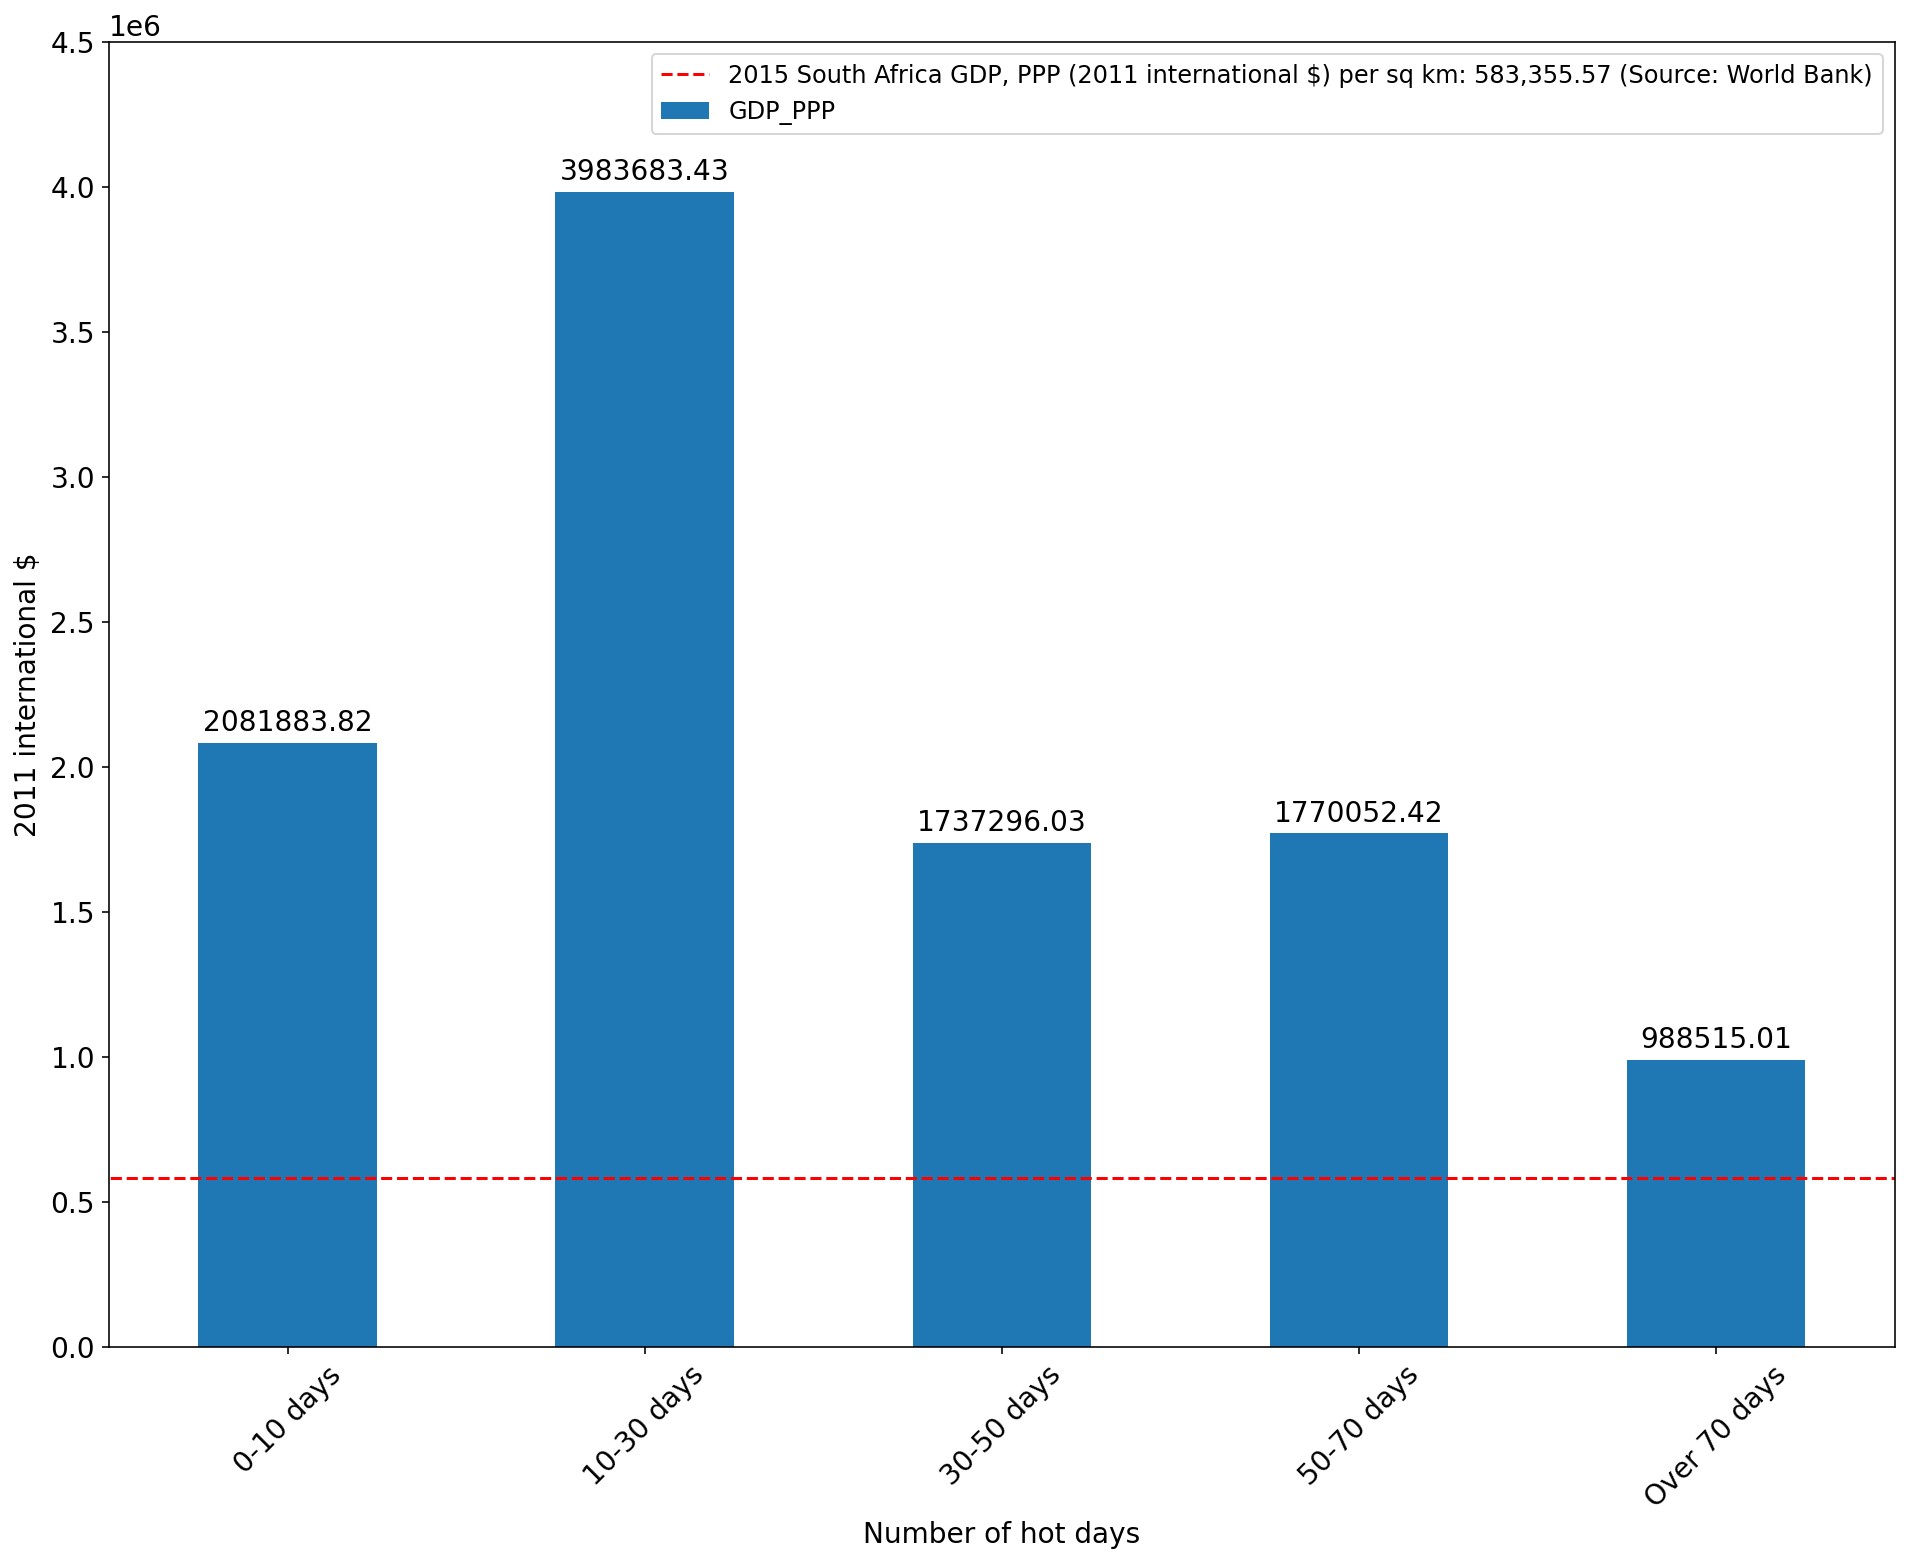

In [14]:
plt.rcParams.update({'font.size': 14})

# indicate threshold: zaf 2015 GDP PPP PC (in 2011 international US dollars)
threshold = 583355.86 #source:world bank

ax = market_df_groupby.plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], label_type='edge', fmt="%.2f", padding=3)
ax.set_xlabel('Number of hot days')
ax.set_ylabel('2011 international $')
ax.set_ylim(0, 4.5e6)
# ax.set_title("GDP per capita (1km by 1km) by brand")
# ax.set_ylim(bottom=-0.5)
# add reference line
ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa GDP, PPP (2011 international $) per sq km: 583,355.57 (Source: World Bank)")
ax.legend(loc="best", fontsize=12)
plt.xticks(rotation=45)
plt.savefig(os.path.join(plots_out_path, "gdp_by_hotdays.png"), dpi=200)
plt.show()

### Population density by brand

In [145]:
market_df_groupby_pop = market_df.groupby(["hotdays_cat_median"])["population"].mean().round(0).astype(int)
market_df_groupby_pop

hotdays_cat_median
above median    1945
below median    6518
Name: population, dtype: int64

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_45499/2297400511.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")


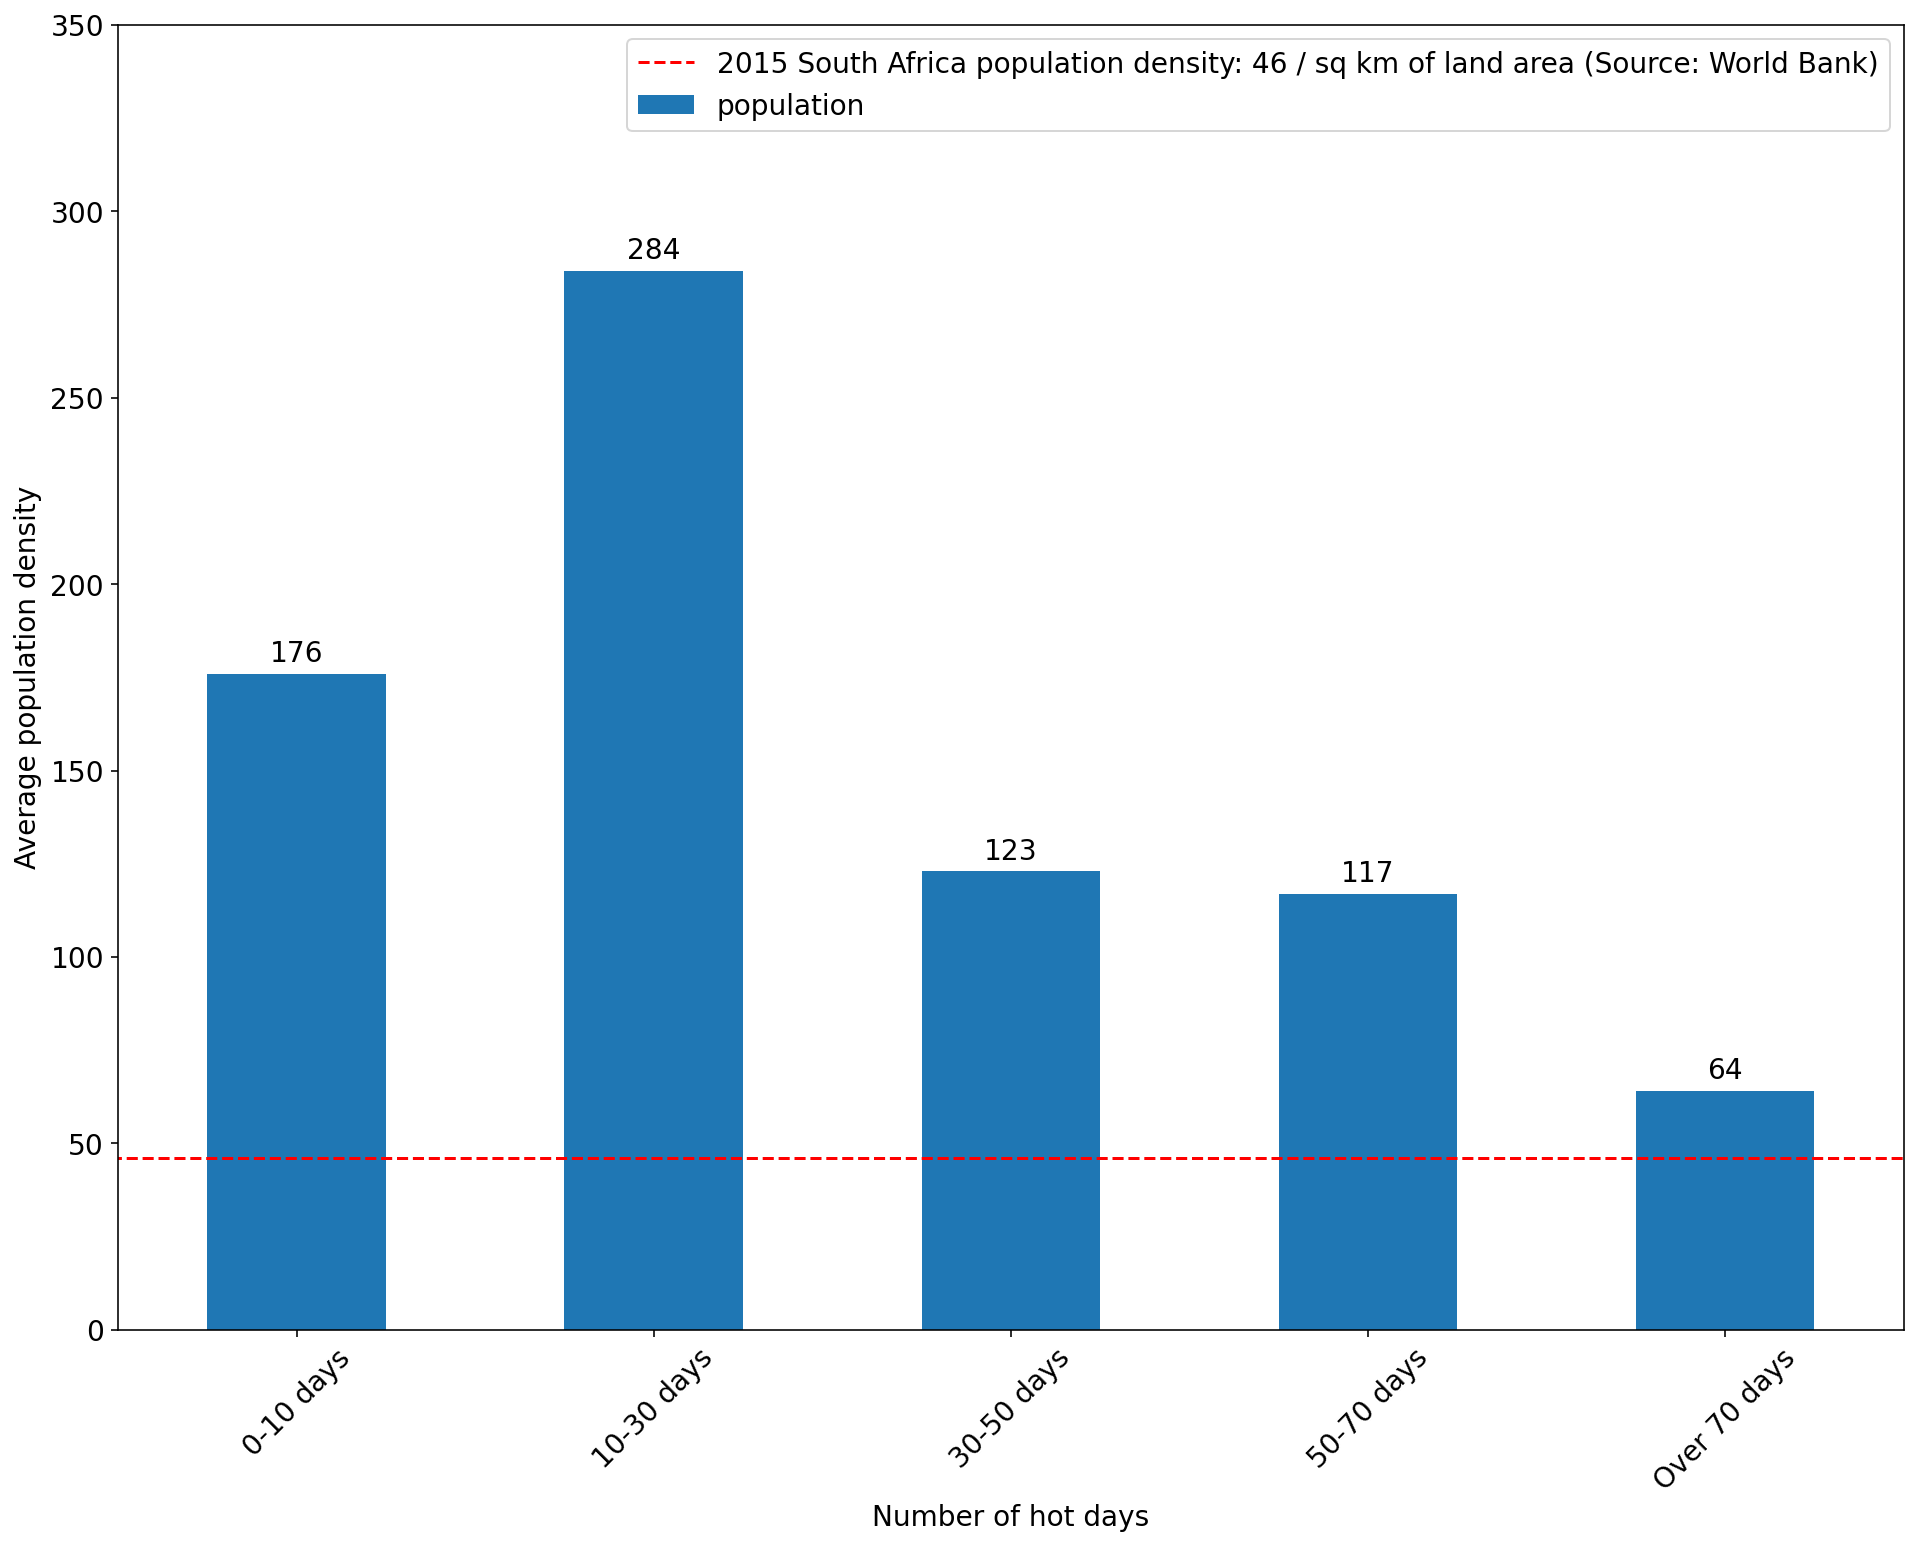

In [16]:
plt.rcParams.update({'font.size': 14})

# threshold: 2015 Albania population density
threshold = 46

ax = market_df_groupby_pop.plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], label_type='edge', padding=3)
ax.set_xlabel('Number of hot days')
ax.set_ylabel('Average population density')
ax.set_ylim(0,350)
# ax.set_title("Average population density (1km by 1km) by brand")
ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")
ax.legend(loc="best", fontsize=14)
plt.xticks(rotation=45)
plt.savefig(os.path.join(plots_out_path, "pop_density_hotdays.png"), dpi=300)
plt.show()

### Population percentage

In [147]:
market_df_groupby_pop2 = market_df.groupby(["hotdays_cat_mean"])["population"].sum().round(0).astype(int)
df1 = market_df_groupby_pop2.to_frame().reset_index()
df1["pop_perc"] = df1["population"] / df1["population"].sum() * 100
df1

hotdays_cat_mean  population   pop_perc
0       above mean    10717569  21.377037
1       below mean    39418326  78.622963

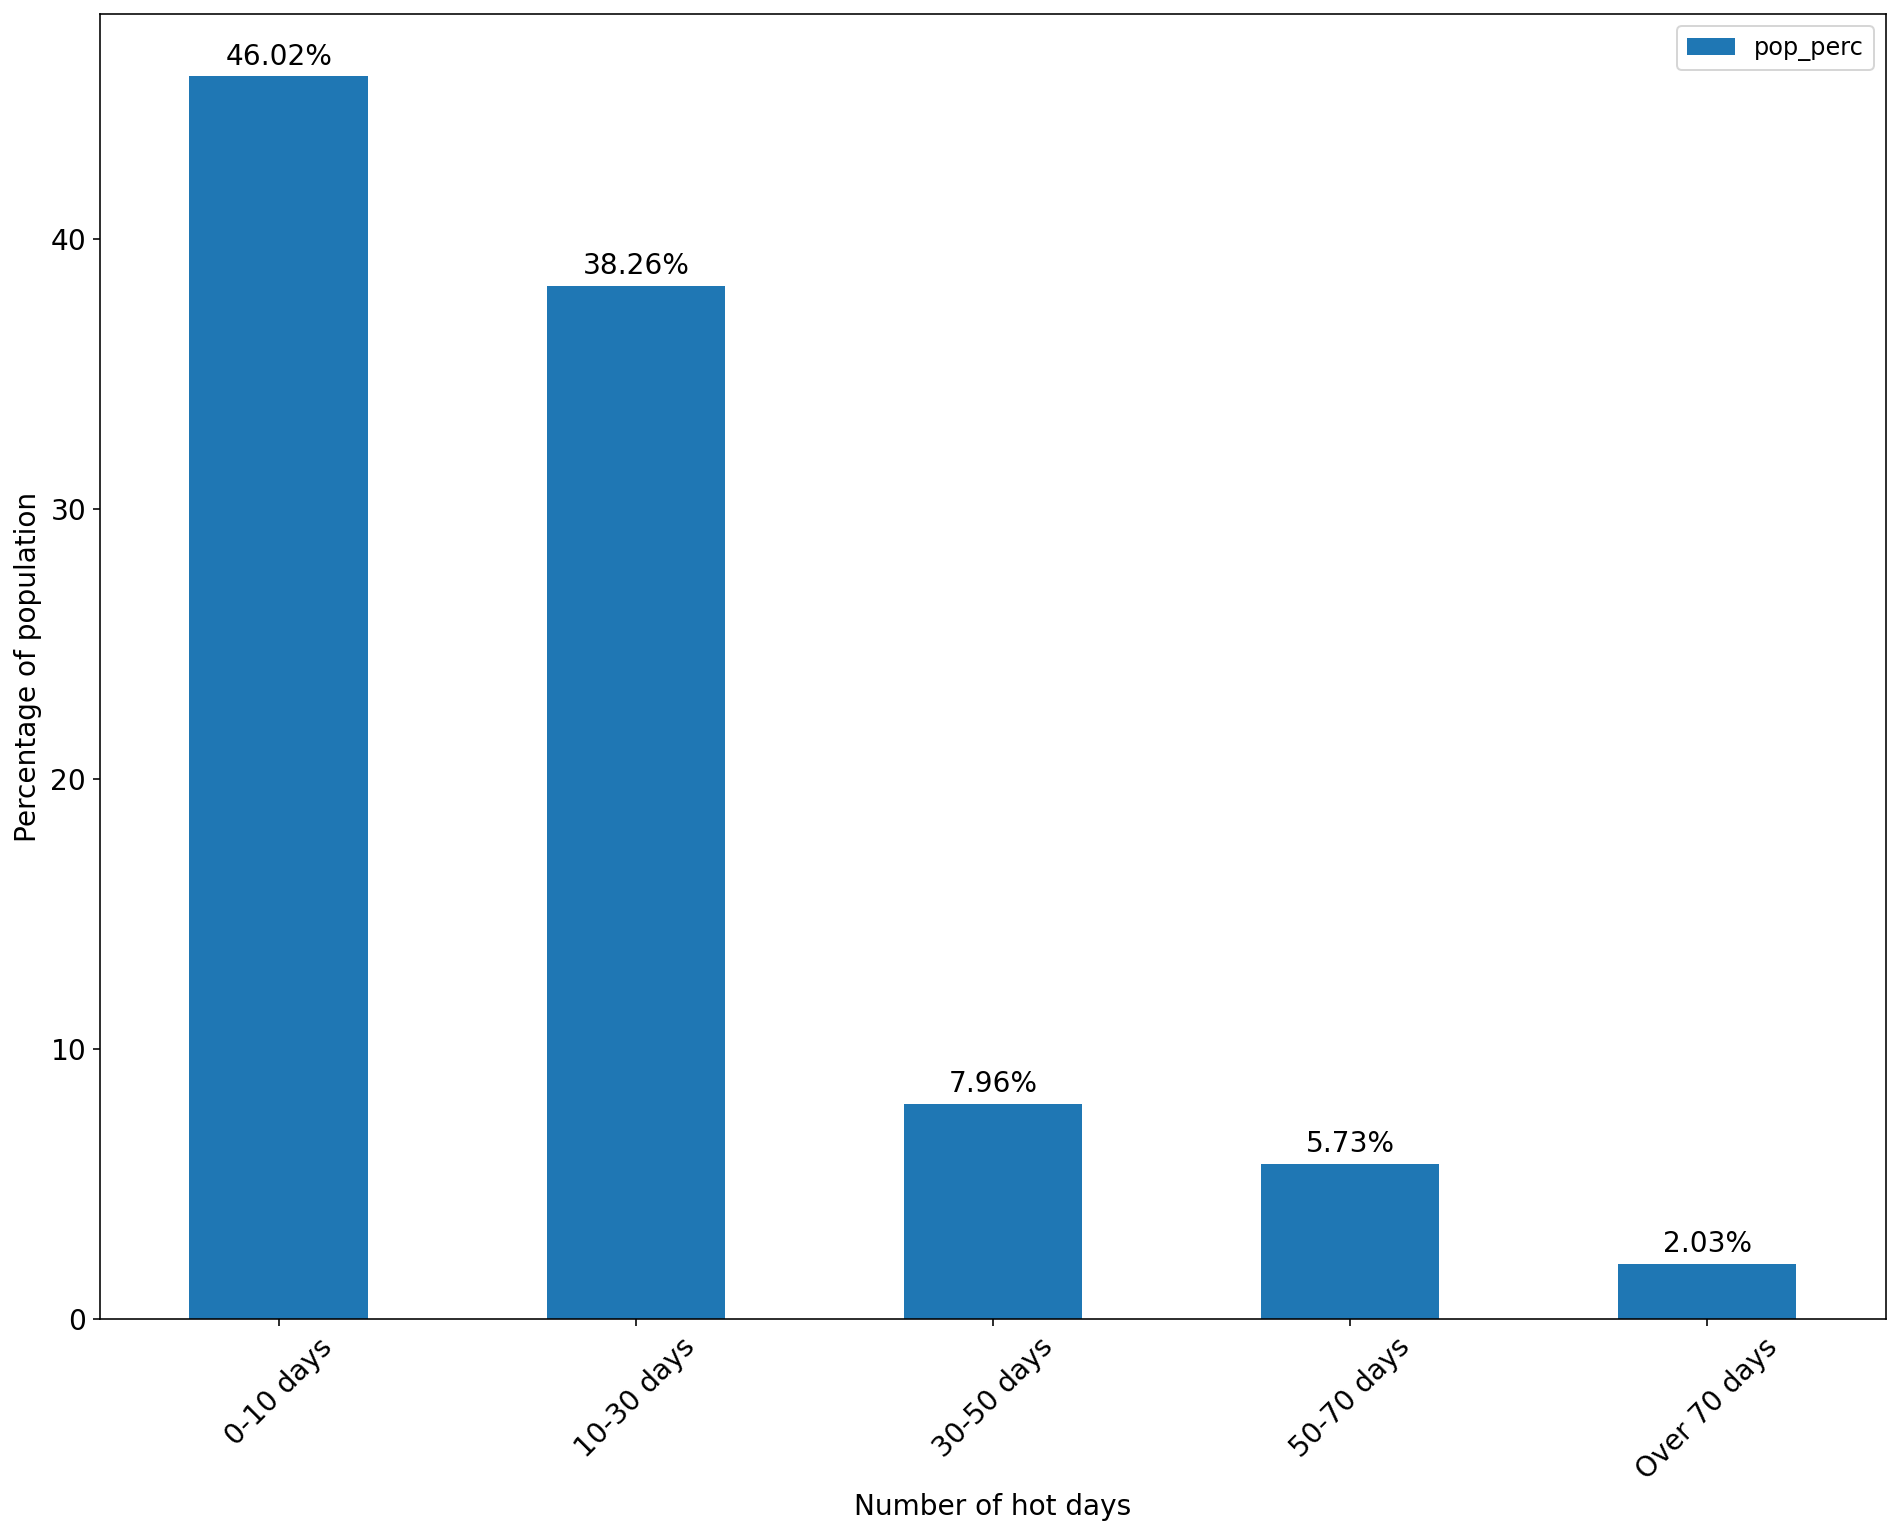

In [18]:
plt.rcParams.update({'font.size': 14})

# threshold: 2015 Albania population density
threshold = 46

y_pos = np.arange(5)
ax = df1["pop_perc"].plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], fmt="%.2f%%", label_type='edge', padding=3)
ax.set_xlabel('Number of hot days')
ax.set_ylabel('Percentage of population')
ax.set_ylim(bottom=0)
# ax.set_title("Average population density (1km by 1km) by brand")
# ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")
ax.legend(loc="best", fontsize=12)
plt.xticks(y_pos, df1["hotdays_cat"], rotation=45)
plt.savefig(os.path.join(plots_out_path, "pop_perc_hotdays.png"), dpi=300)
plt.show()

## Temperature

In [20]:
market_df.describe()

Long           Lat  GDP_PPP_mean   GDP_PPP_sum     population  \
count  11829.000000  11829.000000  1.182900e+04  1.182900e+04   11829.000000   
mean      26.088550    -28.827585  5.467552e+05  5.467552e+07    4238.388245   
std        3.590906      3.056162  3.014629e+06  3.014629e+08   22694.384705   
min       16.665417    -34.750416  3.232452e-01  3.232452e+01       0.021880   
25%       23.665417    -31.417083  2.491114e+03  2.491114e+05      27.830114   
50%       26.498750    -28.667083  1.743530e+04  1.743530e+06     142.274550   
75%       29.082083    -26.500416  1.950372e+05  1.950372e+07    1557.278700   
max       32.832083    -22.250416  8.911366e+07  8.911366e+09  687290.600000   

         nightlight       hotdays  days_heat_index          temp  \
count  1.182900e+04  11829.000000     11829.000000  11829.000000   
mean            inf     10.224313         0.103124      0.632634   
std             NaN      7.760074         0.526007      0.107691   
min   -1.308541e-03      0.000000         0.000000      0.400000   
25%    2.672737e-02      3.100000         0.000000      0.540000   
50%    5.463626e-02      8.800000         0.000000      0.630000   
75%    1.699427e-01     17.800000         0.000000      0.730000   
max             inf     25.650000         5.300000      0.870000   

             precip  precip_percnt            pc  
count  11829.000000   11829.000000  1.182900e+04  
mean     -17.123450      -0.882262  2.551331e+05  
std       68.226379       2.400129  1.245357e+07  
min     -251.740000      -7.290000  2.395827e-01  
25%      -45.890000      -2.290000  3.983786e+03  
50%      -21.100000      -0.430000  1.109849e+04  
75%       12.790000       0.580000  2.789084e+04  
max      213.930000       3.970000  1.345727e+09

In [93]:
temp_values = market_df['temp']
temp_cutoff = np.nanquantile(temp_values,[0.25, 0.5, 0.75, 1])
temp_cutoff

array([0.54, 0.63, 0.73, 0.87])

In [94]:
def temp_cat(x):
    if x < temp_cutoff[0]:
        return "Bottom 25%"
    elif x < temp_cutoff[1]:
        return "25%-50%"
    elif x < temp_cutoff[2]:
        return "50%-75%"
    else:
        return "Above 75%"
    

In [95]:
market_df["temp_cat"]=market_df.apply(lambda x: temp_cat(x["temp"]),axis=1)
market_df["temp_cat"].value_counts(dropna=False)

50%-75%       3293
Above 75%     2991
25%-50%       2890
Bottom 25%    2655
Name: temp_cat, dtype: int64

In [96]:
temp_groupby = market_df.groupby(["temp_cat"])["GDP_PPP_sum"].mean().round(2)
temp_groupby

temp_cat
25%-50%       95985049.07
50%-75%       35163933.67
Above 75%     20638191.20
Bottom 25%    72254720.90
Name: GDP_PPP_sum, dtype: float64

In [32]:
temp_groupby = market_df.groupby(["temp_cat"])["GDP_PPP_sum"].sum().round(2)
df = temp_groupby.to_frame()
df["gdp_perc"] = df["GDP_PPP_sum"] / df["GDP_PPP_sum"].sum() * 100
df

GDP_PPP_sum   gdp_perc
temp_cat                           
25%-50%     2.773968e+11  42.890437
50%-75%     1.157948e+11  17.903924
Bottom 25%  1.918363e+11  29.661273
Over 75%    6.172883e+10   9.544366

Reference GDP PPP PC source:   
https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/LTST/endyear/LTST/indicator/NY-GDP-PCAP-PP-KD 

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_45499/3634760901.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa GDP, PPP (2011 international $) per sq km: 583,355.57 (Source: World Bank)")


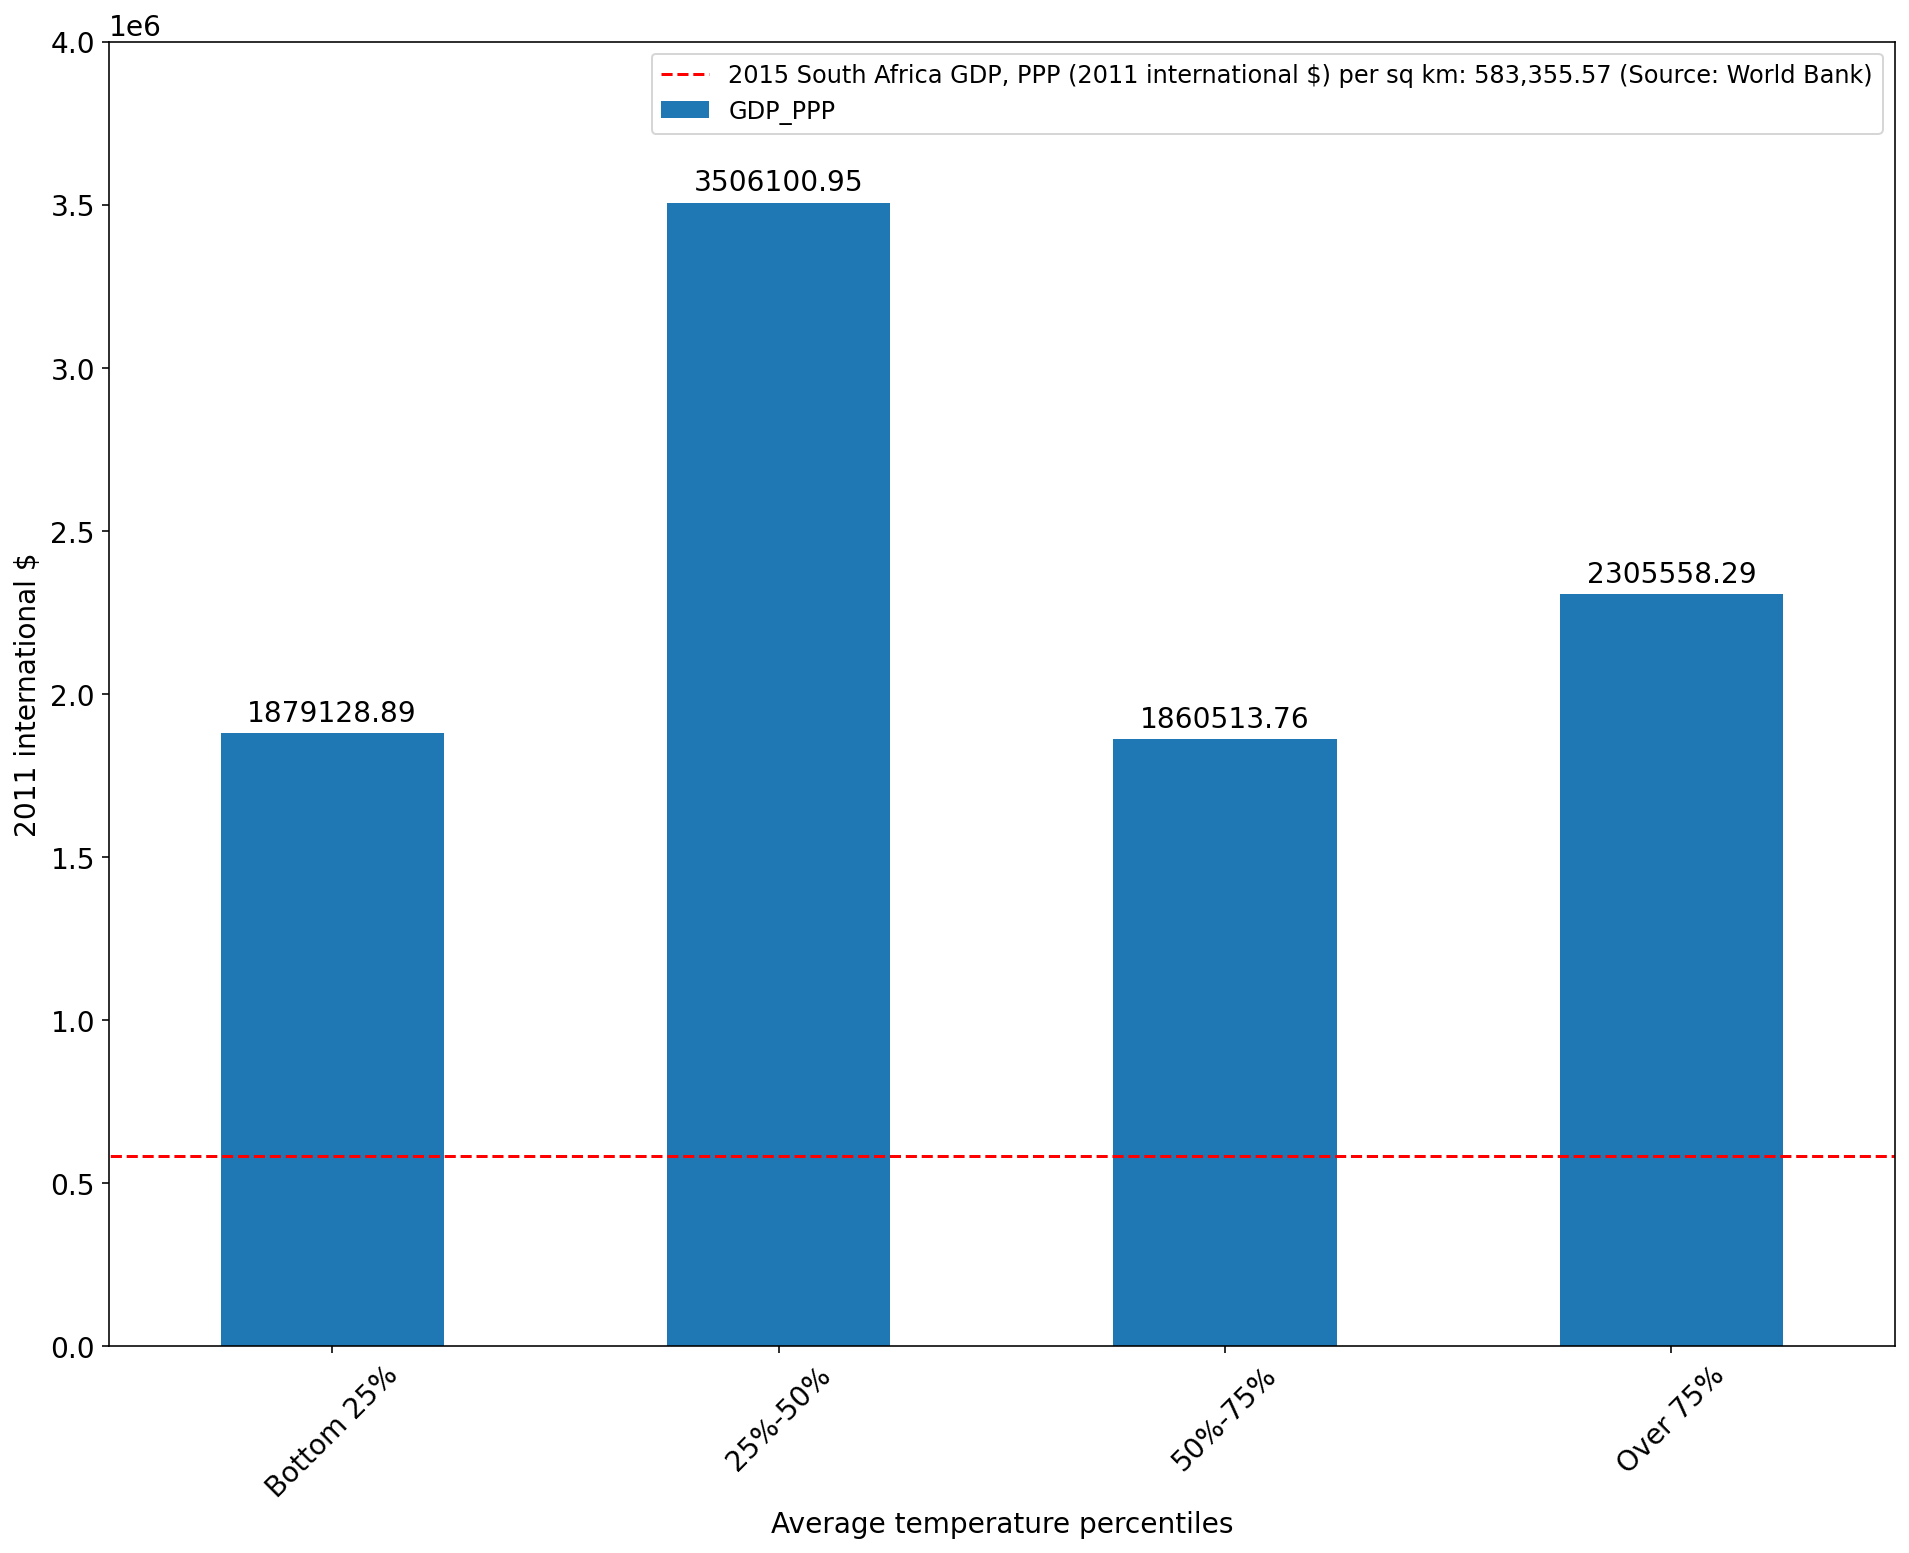

In [23]:
plt.rcParams.update({'font.size': 14})

# indicate threshold: Albania 2015 GDP PPP PC (in 2011 international US dollars)
threshold = 583355.57 #source:world bank

orders=['Bottom 25%', '25%-50%', '50%-75%', 'Over 75%']
ax = temp_groupby.loc[orders].plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], label_type='edge', fmt="%.2f", padding=3)
ax.set_xlabel('Average temperature percentiles')
ax.set_ylabel("2011 international $")
ax.set_ylim(0, 4e6)
# ax.set_title("GDP per capita (1km by 1km) by brand")
# ax.set_ylim(bottom=-0.5)
# add reference line
ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa GDP, PPP (2011 international $) per sq km: 583,355.57 (Source: World Bank)")
ax.legend(loc="best", fontsize=12)
plt.xticks(rotation=45)
plt.savefig(os.path.join(plots_out_path, "gdp_by_temp_cat.png"), dpi=200)
plt.show()

### Population density by brand

In [97]:
temp_groupby_pop = market_df.groupby(["temp_cat"])["population"].mean().round(0).astype(int)
temp_groupby_pop

temp_cat
25%-50%       7103
50%-75%       2434
Above 75%     1608
Bottom 25%    6321
Name: population, dtype: int64

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_45499/3733612915.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")


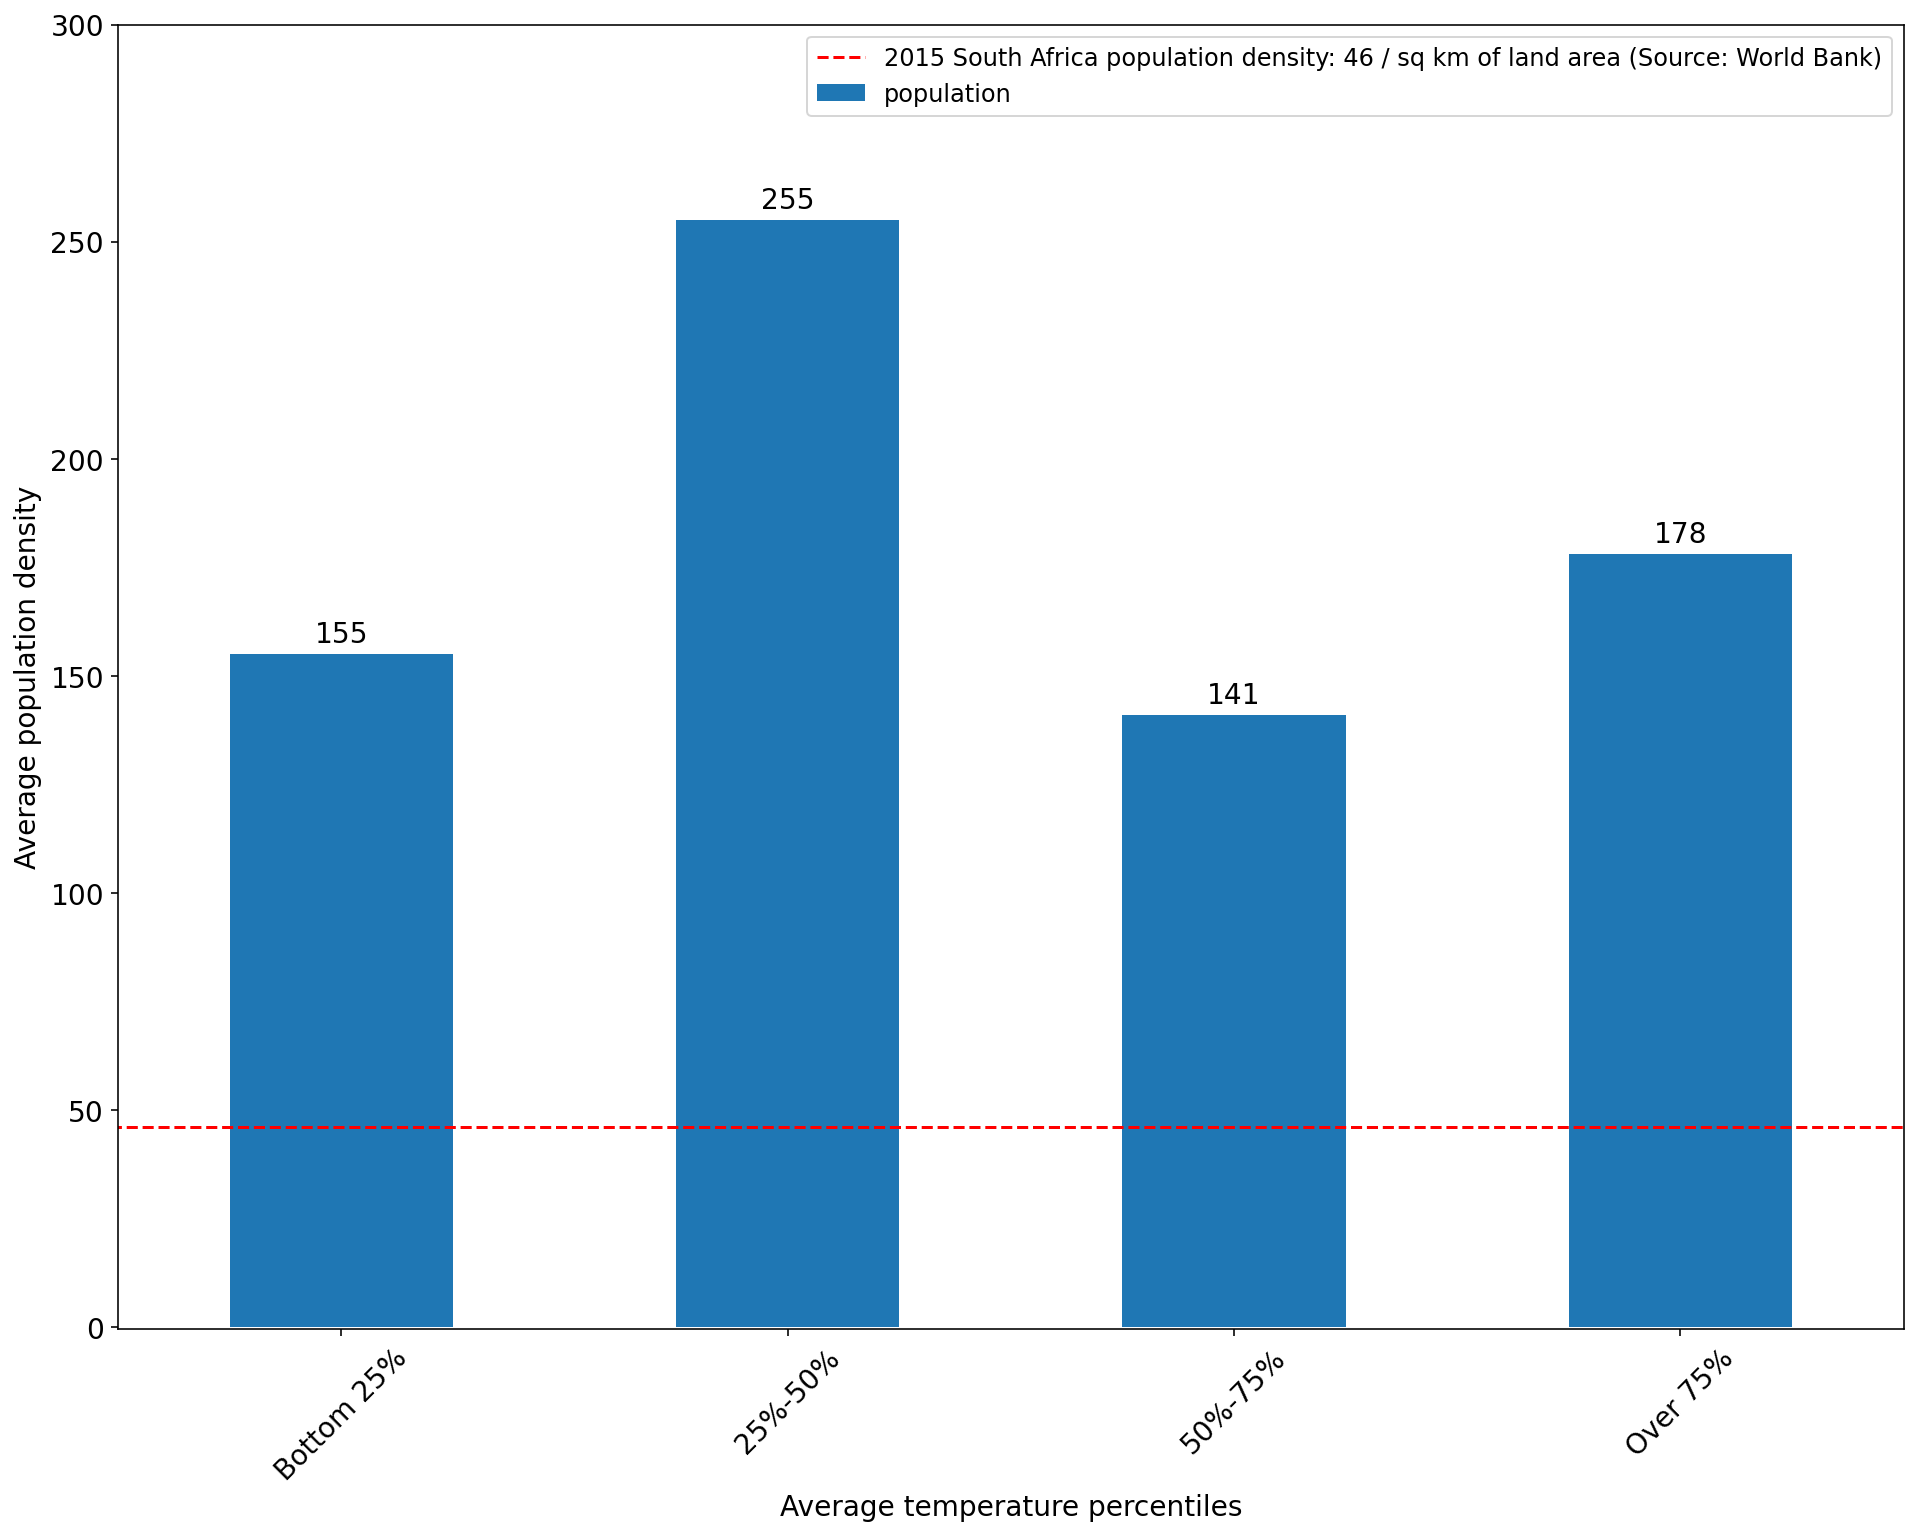

In [25]:
plt.rcParams.update({'font.size': 14})

# threshold: 2015 Albania population density
threshold = 46

ax = temp_groupby_pop.loc[orders].plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], label_type='edge', padding=3)
ax.set_xlabel('Average temperature percentiles')
ax.set_ylabel('Average population density')
ax.set_ylim(0,300)
# ax.set_title("Average population density (1km by 1km) by brand")
ax.set_ylim(bottom=-0.5)
ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")
ax.legend(loc="best", fontsize=12)
plt.xticks(rotation=45)
plt.savefig(os.path.join(plots_out_path, "pop_density_temp.png"), dpi=300)
plt.show()

### Population percentage

In [25]:
market_df_groupby_pop3 = market_df.groupby(["temp_cat"])["population"].sum().round(0).astype(int)
df2 = market_df_groupby_pop3.to_frame()
df2["pop_perc"] = df2["population"] / df2["population"].sum() * 100
df2

population   pop_perc
temp_cat                         
25%-50%       20528739  40.946190
50%-75%        8016113  15.988770
Bottom 25%    16782057  33.473137
Over 75%       4808986   9.591902

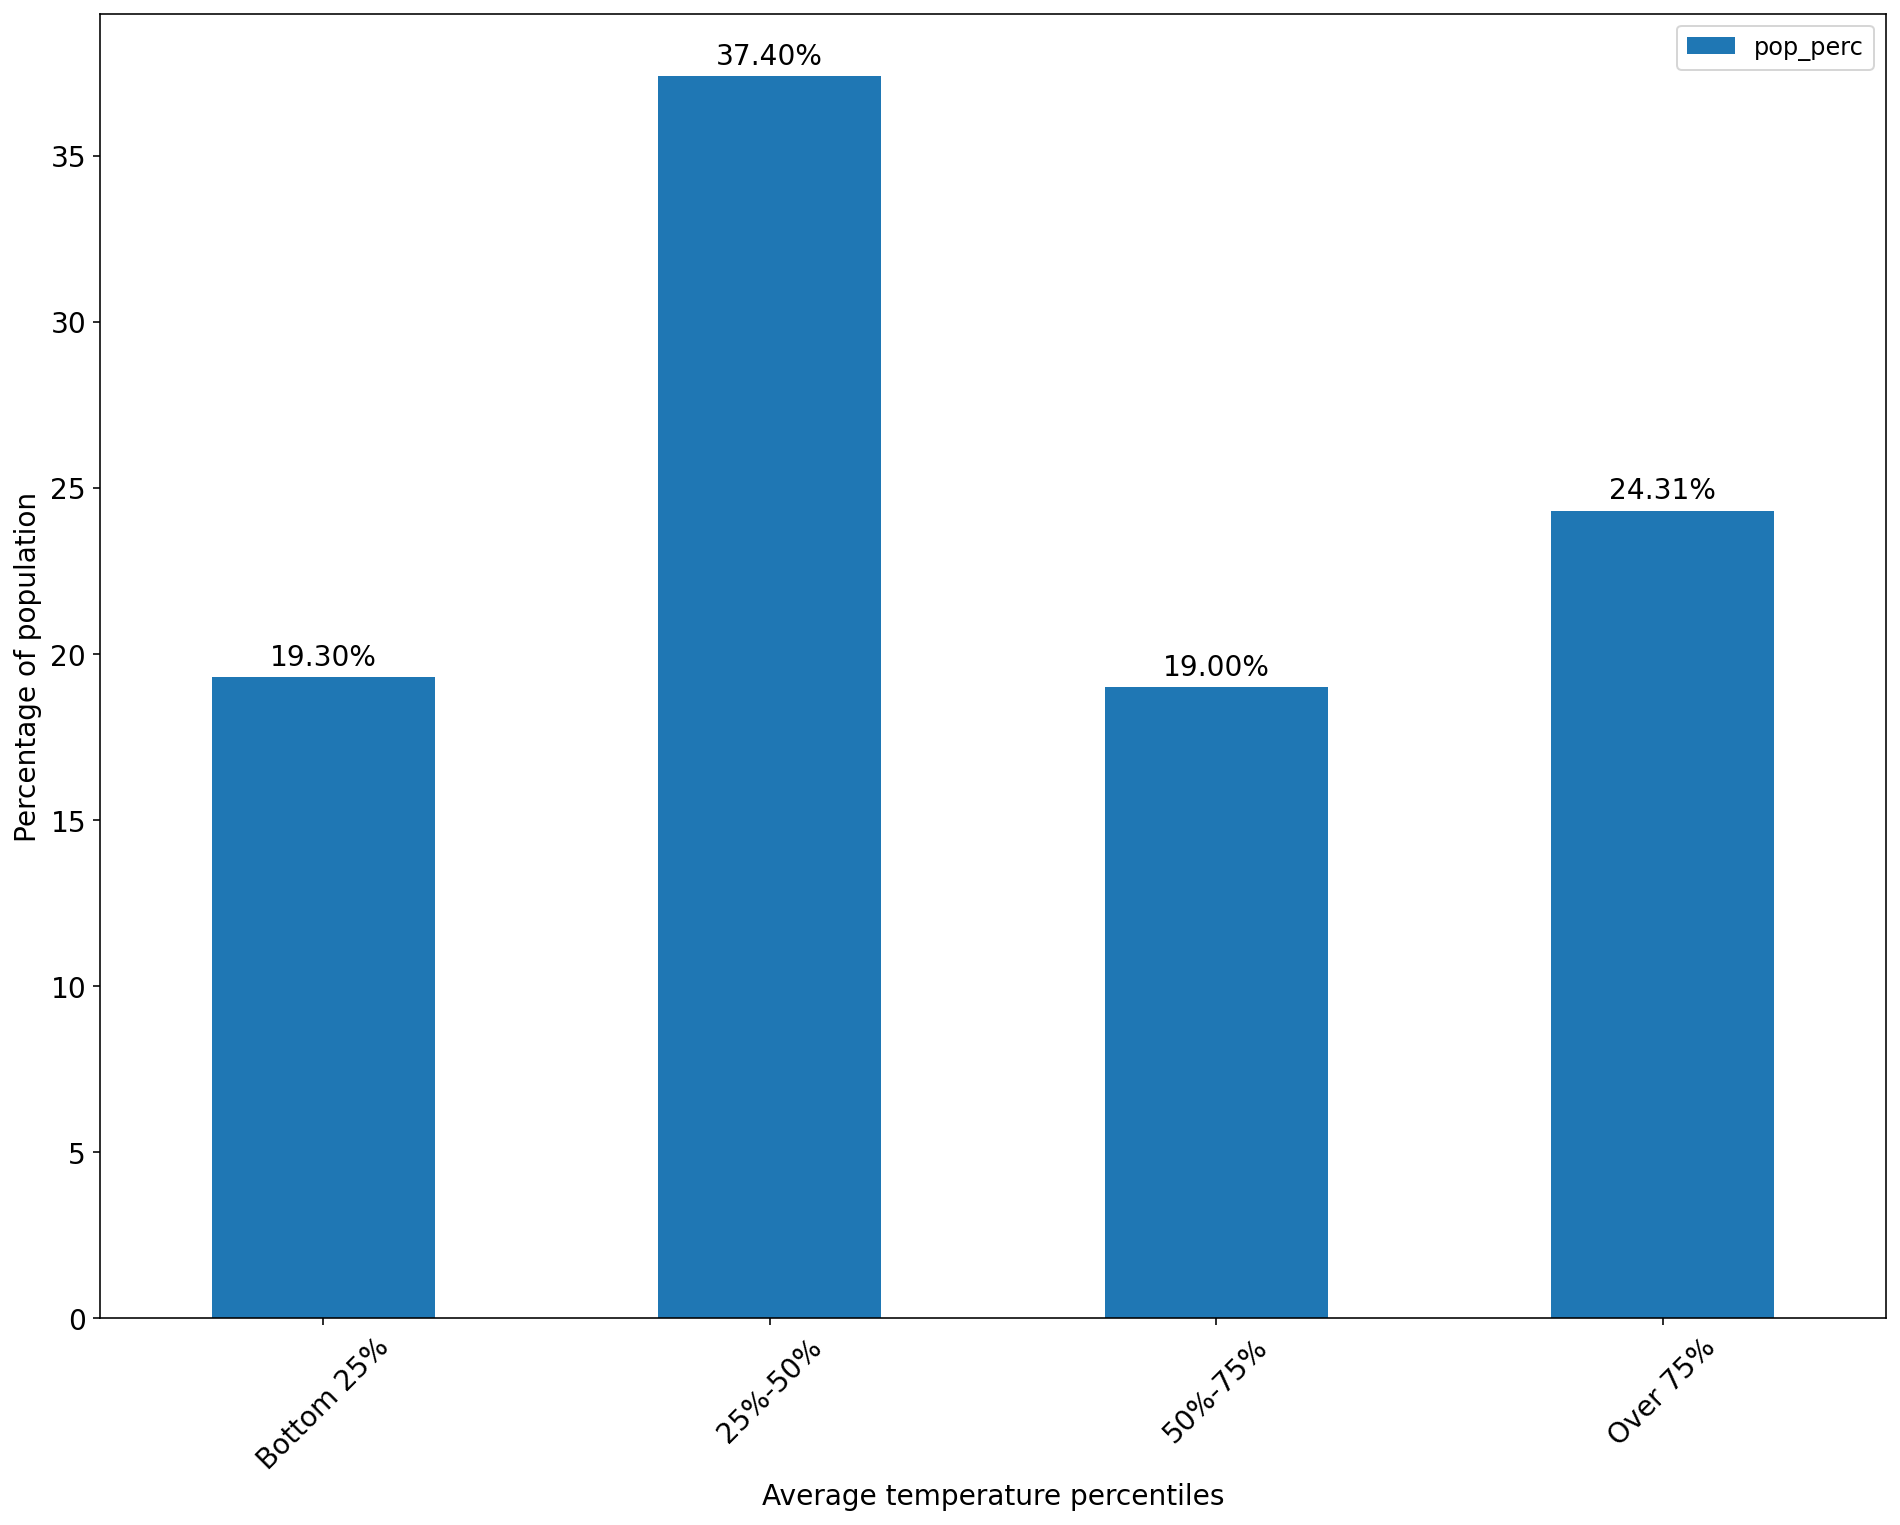

In [28]:
plt.rcParams.update({'font.size': 14})

# threshold: 2015 Albania population density
threshold = 46

y_pos = np.arange(4)
ax = df2["pop_perc"].loc[orders].plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], fmt="%.2f%%", label_type='edge', padding=3)
ax.set_xlabel('Average temperature percentiles')
ax.set_ylabel('Percentage of population')
ax.set_ylim(bottom=0)
# ax.set_title("Average population density (1km by 1km) by brand")
# ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")
ax.legend(loc="best", fontsize=12)
plt.xticks( rotation=45)
plt.savefig(os.path.join(plots_out_path, "pop_perc_temp.png"), dpi=300)
plt.show()

## Precipitation

In [121]:
market_df

Long        Lat  GDP_PPP_mean   GDP_PPP_sum    population  \
0      16.665417 -28.750416  2.546182e+01  2.546182e+03      0.471344   
1      16.665417 -28.833750  1.388521e+02  1.388521e+04      0.990747   
2      16.748750 -28.833750  1.121833e+01  1.121833e+03      0.146418   
3      16.748750 -28.917083  1.649256e+01  1.649256e+03      0.509858   
4      16.832083 -28.417083  1.193500e+05  1.193500e+07      1.583840   
...          ...        ...           ...           ...           ...   
11824  32.748750 -26.917083  1.318062e+06  1.318062e+08   9144.445000   
11825  32.748750 -27.000416  8.538637e+05  8.538637e+07  24504.955000   
11826  32.748750 -27.083750  1.550694e+05  1.550694e+07   1563.073500   
11827  32.748750 -27.167083  4.388440e+04  4.388440e+06   2362.568800   
11828  32.832083 -26.917083  1.220238e+06  1.220238e+08   4576.823000   

       nightlight  hotdays  days_heat_index  temp  precip  precip_percnt  \
0        0.044446     0.15              0.0  0.49   -4.72          -4.49   
1        0.055383     0.15              0.0  0.49   -4.72          -4.49   
2        0.039771     0.15              0.0  0.49   -4.72          -4.49   
3        0.041680     0.15              0.0  0.49   -4.72          -4.49   
4        0.114101     2.70              0.0  0.57    8.56           1.28   
...           ...      ...              ...   ...     ...            ...   
11824    0.152054     0.45              4.7  0.52  -29.73           1.29   
11825    0.933610     0.45              4.7  0.52  -29.73           1.29   
11826    0.042506     0.45              4.7  0.52  -29.73           1.29   
11827    0.070886     0.45              4.7  0.52  -29.73           1.29   
11828         inf     0.45              4.7  0.52  -29.73           1.29   

                 pc    temp_cat precip_cat precip_pnt_cat hotdays_cat  
0      5.401958e+03  Bottom 25%    50%-75%     Bottom 25%    0-5 days  
1      1.401489e+04  Bottom 25%    50%-75%     Bottom 25%    0-5 days  
2      7.661835e+03  Bottom 25%    50%-75%     Bottom 25%    0-5 days  
3      3.234737e+03  Bottom 25%    50%-75%     Bottom 25%    0-5 days  
4      7.535480e+06     25%-50%    50%-75%      Above 75%    0-5 days  
...             ...         ...        ...            ...         ...  
11824  1.441380e+04  Bottom 25%    25%-50%      Above 75%    0-5 days  
11825  3.484453e+03  Bottom 25%    25%-50%      Above 75%    0-5 days  
11826  9.920800e+03  Bottom 25%    25%-50%      Above 75%    0-5 days  
11827  1.857487e+03  Bottom 25%    25%-50%      Above 75%    0-5 days  
11828  2.666124e+04  Bottom 25%    25%-50%      Above 75%    0-5 days  

[11829 rows x 16 columns]

In [98]:
precip_values = market_df['precip']
precip_cutoff = np.nanquantile(precip_values,[0.25, 0.5, 0.75, 1])
precip_cutoff

array([-45.89, -21.1 ,  12.79, 213.93])

In [28]:
def precip_cat(x):
    if x < precip_cutoff[0]:
        return "Bottom 25%"
    elif x < precip_cutoff[1]:
        return "25%-50%"
    elif x < precip_cutoff[2]:
        return "50%-75%"
    else:
        return "Above 75%"
    

In [99]:
market_df["precip_cat"]=market_df.apply(lambda x: precip_cat(x["precip"]),axis=1)
market_df["precip_cat"].value_counts(dropna=False)

25%-50%       3009
Above 75%     2965
50%-75%       2964
Bottom 25%    2891
Name: precip_cat, dtype: int64

In [100]:
precip_groupby = market_df.groupby(["precip_cat"])["GDP_PPP_sum"].mean().round(2)
precip_groupby

precip_cat
25%-50%       31407382.17
50%-75%       93129619.87
Above 75%     62329669.31
Bottom 25%    31618216.36
Name: GDP_PPP_sum, dtype: float64

precip GDP percentage

In [101]:
precip_groupby = market_df.groupby(["precip_cat"])["GDP_PPP_sum"].sum().round(2)
df = precip_groupby.to_frame()
df["gdp_perc"] = df["GDP_PPP_sum"] / df["GDP_PPP_sum"].sum() * 100
df

GDP_PPP_sum   gdp_perc
precip_cat                         
25%-50%     9.450481e+10  14.612111
50%-75%     2.760362e+11  42.680064
Above 75%   1.848075e+11  28.574495
Bottom 25%  9.140826e+10  14.133330

Reference GDP PPP PC source:   
https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/LTST/endyear/LTST/indicator/NY-GDP-PCAP-PP-KD 

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_45499/1456075493.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa GDP, PPP (2011 international $) per sq km: 583,355.57 (Source: World Bank)")


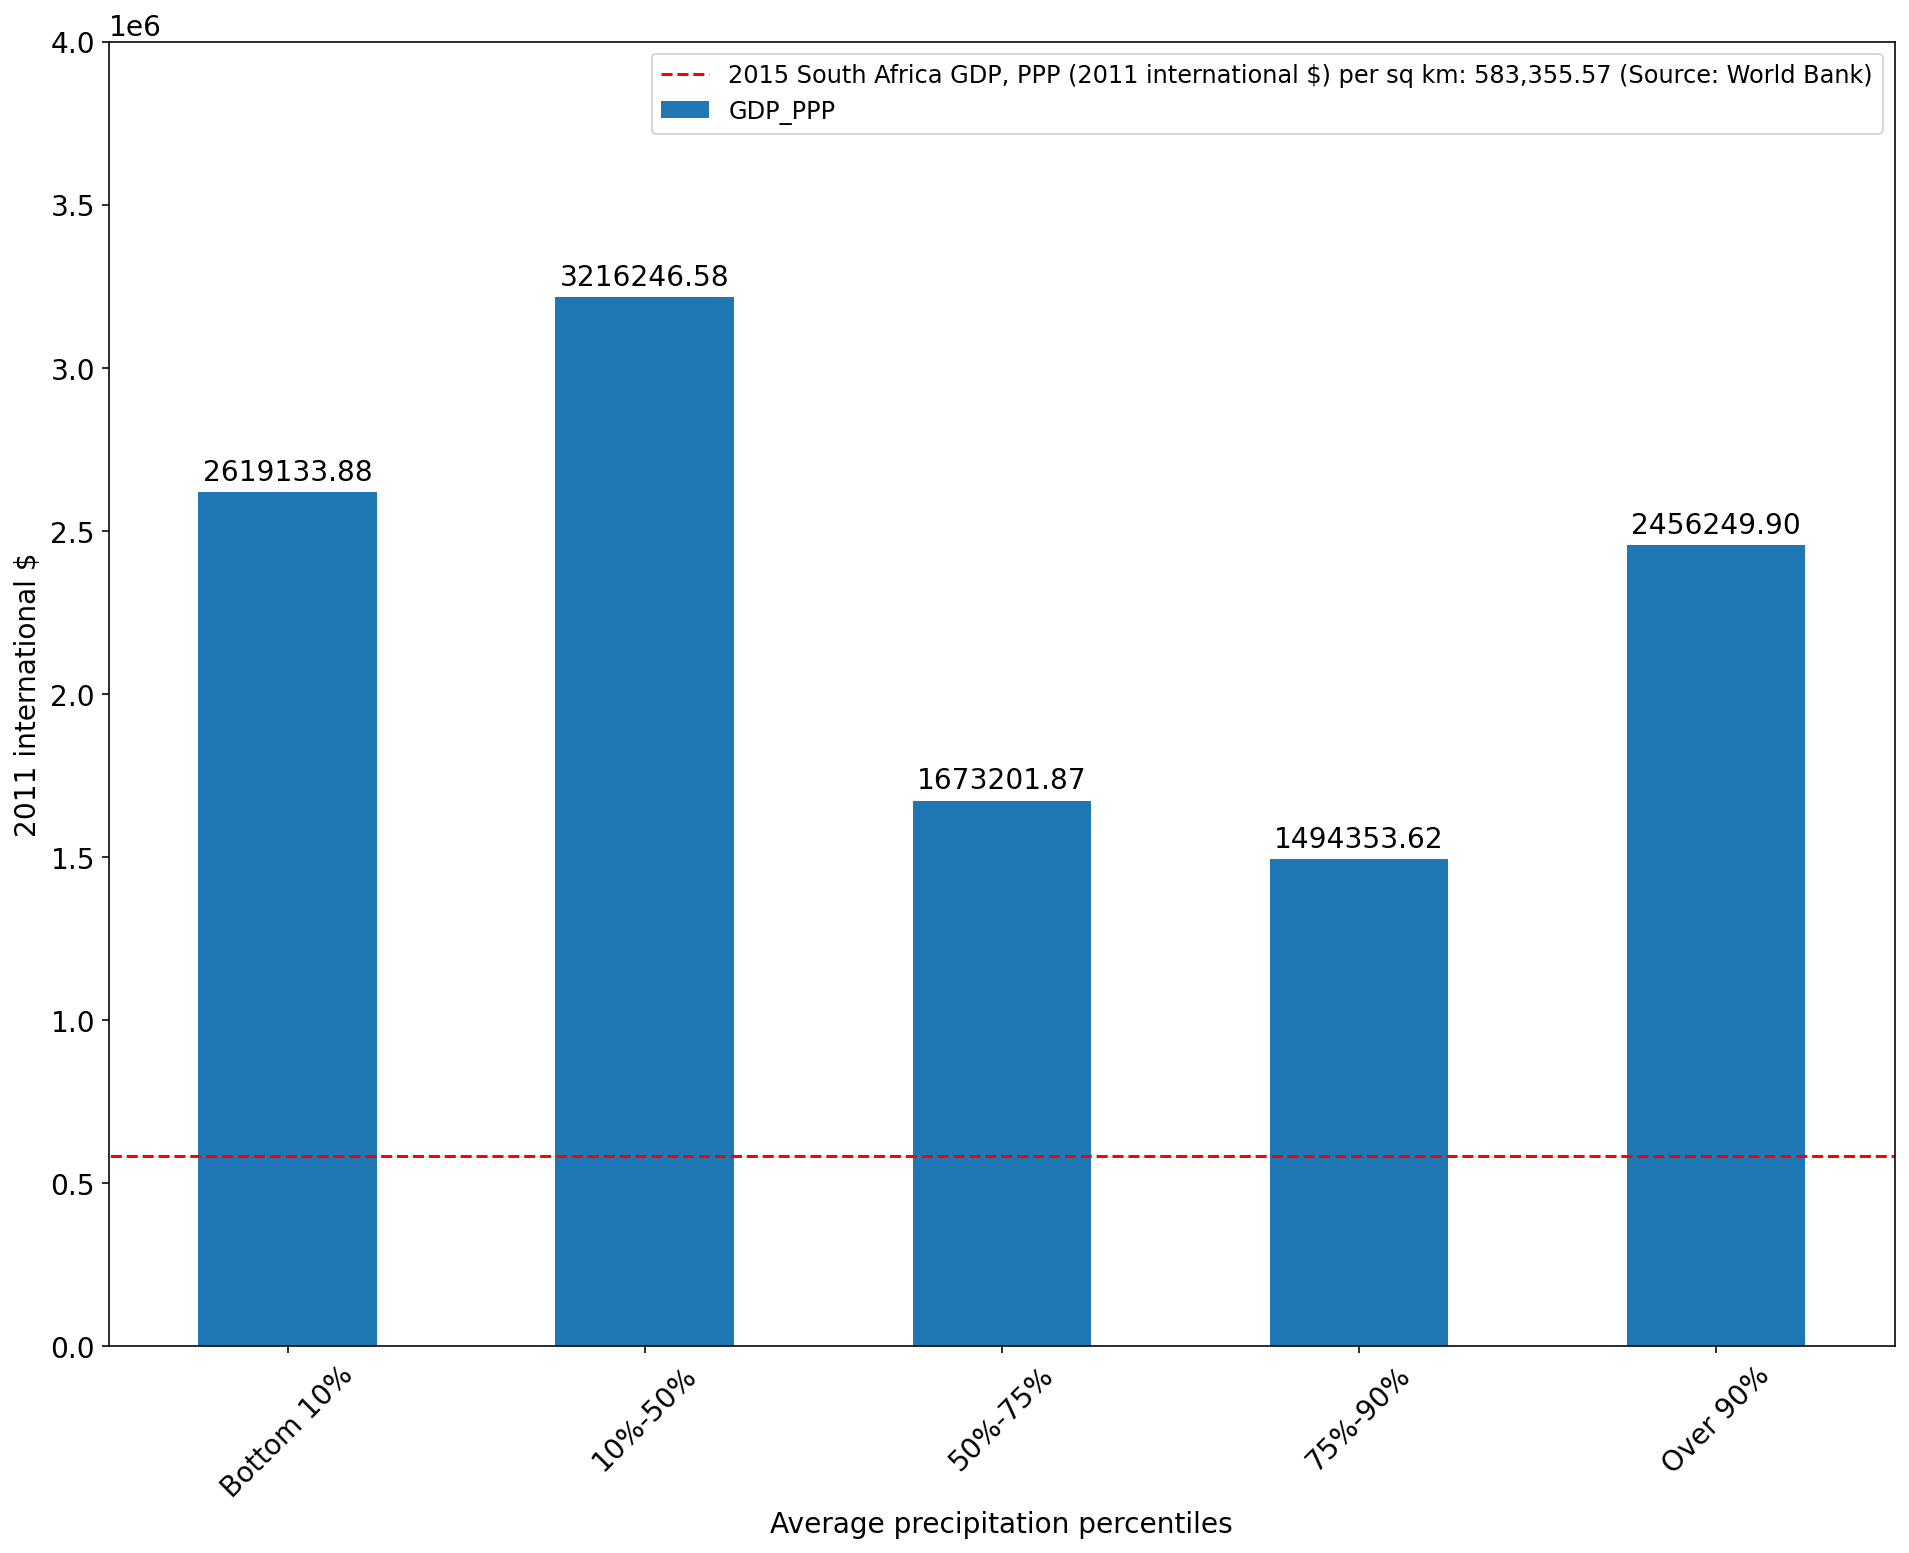

In [33]:
plt.rcParams.update({'font.size': 14})

# indicate threshold: Albania 2015 GDP PPP PC (in 2011 international US dollars)
threshold = 583355.57 #source:world bank

orders2=['Bottom 10%', '10%-50%', '50%-75%', '75%-90%', 'Over 90%']
ax = precip_groupby.loc[orders2].plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], label_type='edge', fmt="%.2f", padding=3)
ax.set_xlabel('Average precipitation percentiles')
ax.set_ylabel("2011 international $")
ax.set_ylim(0, 4e6)
# ax.set_title("GDP per capita (1km by 1km) by brand")
# ax.set_ylim(bottom=-0.5)
# add reference line
ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa GDP, PPP (2011 international $) per sq km: 583,355.57 (Source: World Bank)")
ax.legend(loc="best", fontsize=12)
plt.xticks(rotation=45)
plt.savefig(os.path.join(plots_out_path, "gdp_by_precip_cat.png"), dpi=200)
plt.show()

### Population density by brand

In [102]:
precip_groupby_pop = market_df.groupby(["precip_cat"])["population"].mean().round(0).astype(int)
precip_groupby_pop

precip_cat
25%-50%       2595
50%-75%       6943
Above 75%     4644
Bottom 25%    2760
Name: population, dtype: int64

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_45499/3816843169.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")


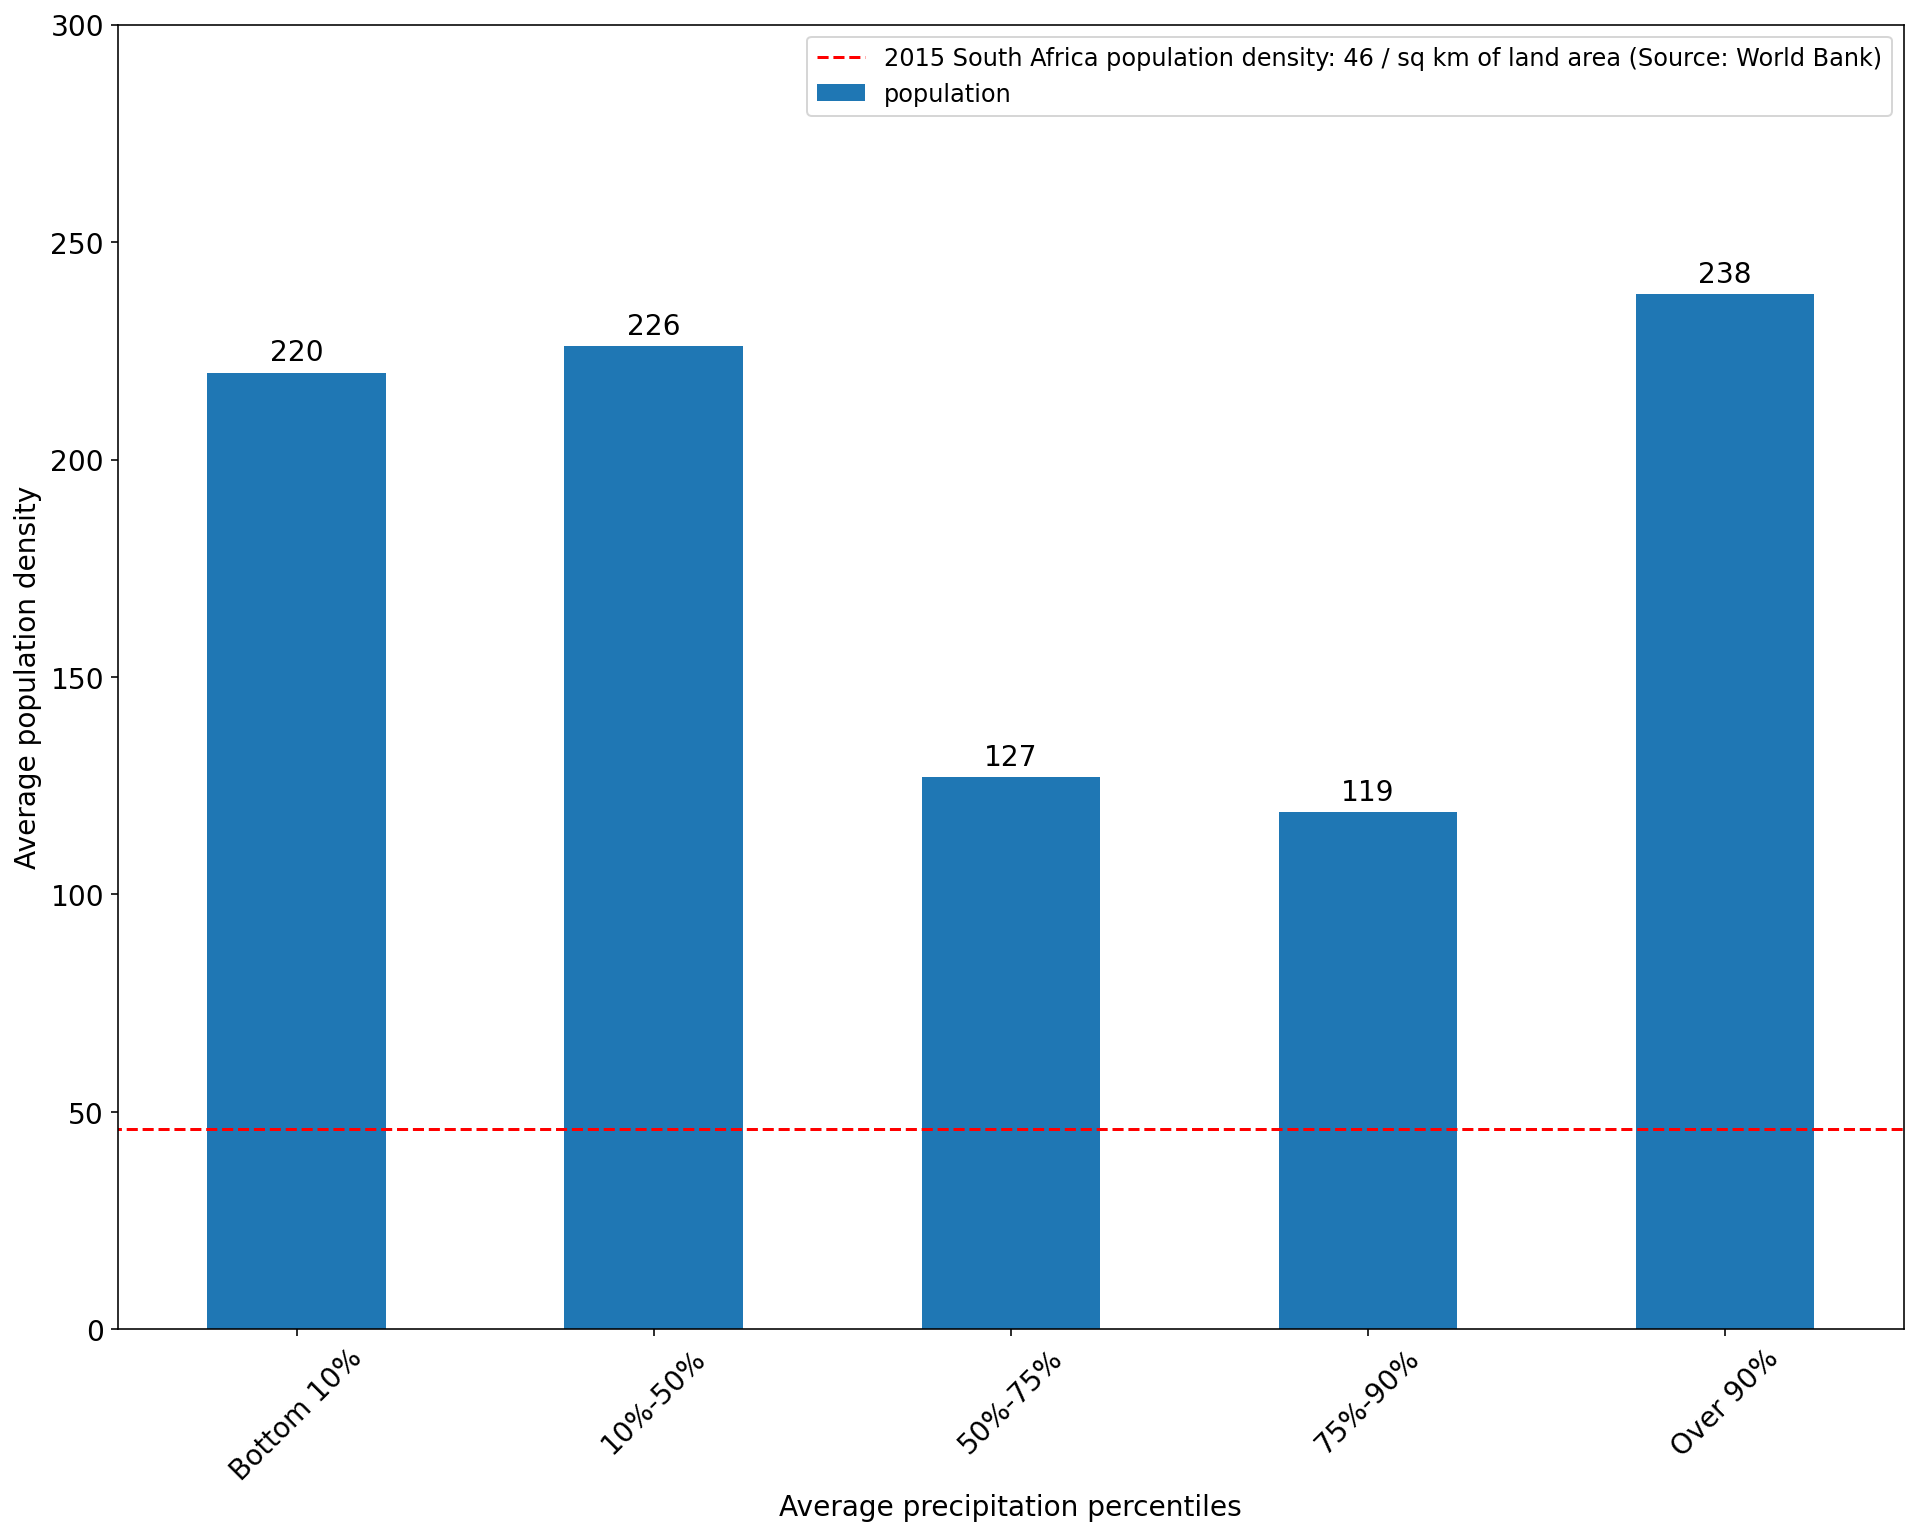

In [35]:
plt.rcParams.update({'font.size': 14})

# threshold: 2015 Albania population density
threshold = 46

ax = precip_groupby_pop.loc[orders2].plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], label_type='edge', padding=3)
ax.set_xlabel('Average precipitation percentiles')
ax.set_ylabel('Average population density')
ax.set_ylim(0,300)
# ax.set_title("Average population density (1km by 1km) by brand")
ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")
ax.legend(loc="best", fontsize=12)
plt.xticks(rotation=45)
plt.savefig(os.path.join(plots_out_path, "pop_density_precip.png"), dpi=300)
plt.show()

### Population percentage

In [103]:
market_df_groupby_pop4 = market_df.groupby(["precip_cat"])["population"].sum().round(0).astype(int)
df3 = market_df_groupby_pop4.to_frame()
df3["pop_perc"] = df3["population"] / df3["population"].sum() * 100
df3

population   pop_perc
precip_cat                       
25%-50%        7809847  15.577356
50%-75%       20578273  41.044990
Above 75%     13768752  27.462863
Bottom 25%     7979023  15.914791

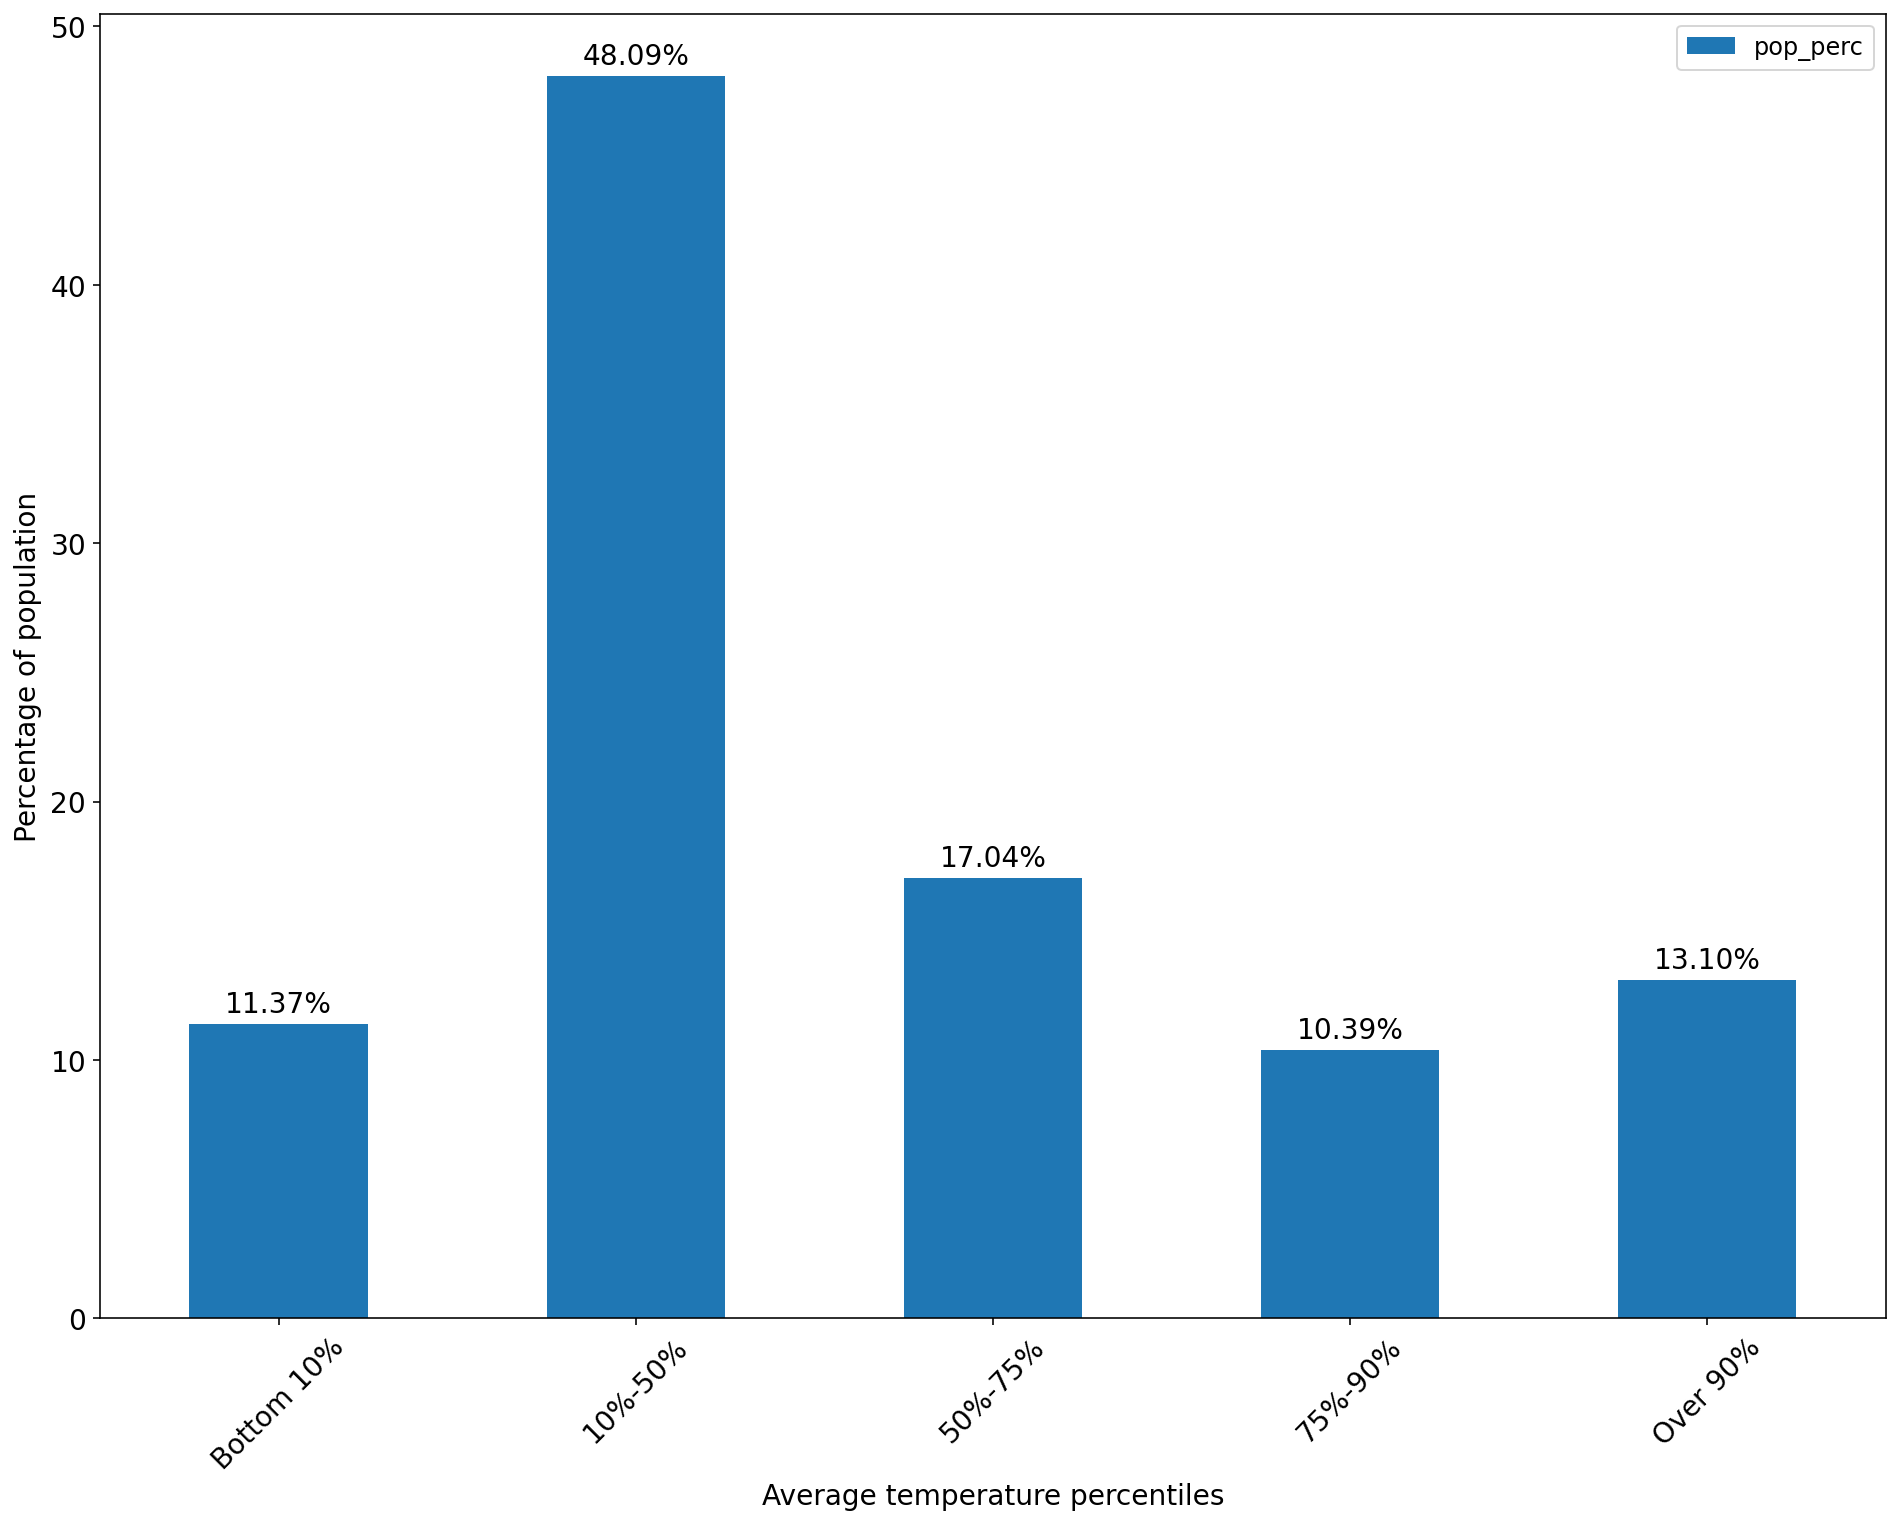

In [38]:
plt.rcParams.update({'font.size': 14})

# threshold: 2015 Albania population density
threshold = 46

y_pos = np.arange(5)
ax = df3["pop_perc"].loc[orders2].plot(kind='bar', figsize=(16,12))
ax.bar_label(ax.containers[0], fmt="%.2f%%", label_type='edge', padding=3)
ax.set_xlabel('Average temperature percentiles')
ax.set_ylabel('Percentage of population')
ax.set_ylim(bottom=0)
# ax.set_title("Average population density (1km by 1km) by brand")
# ax.plot([-2,4.5], [threshold, threshold], "k--", color="red", label="2015 South Africa population density: 46 / sq km of land area (Source: World Bank)")
ax.legend(loc="best", fontsize=12)
plt.xticks(rotation=45)
plt.savefig(os.path.join(plots_out_path, "pop_perc_precip.png"), dpi=300)
plt.show()

## precip percentage change

In [122]:
market_df.describe()

Long           Lat  GDP_PPP_mean   GDP_PPP_sum     population  \
count  11829.000000  11829.000000  1.182900e+04  1.182900e+04   11829.000000   
mean      26.088550    -28.827585  5.467552e+05  5.467552e+07    4238.388245   
std        3.590906      3.056162  3.014629e+06  3.014629e+08   22694.384705   
min       16.665417    -34.750416  3.232452e-01  3.232452e+01       0.021880   
25%       23.665417    -31.417083  2.491114e+03  2.491114e+05      27.830114   
50%       26.498750    -28.667083  1.743530e+04  1.743530e+06     142.274550   
75%       29.082083    -26.500416  1.950372e+05  1.950372e+07    1557.278700   
max       32.832083    -22.250416  8.911366e+07  8.911366e+09  687290.600000   

         nightlight       hotdays  days_heat_index          temp  \
count  1.182900e+04  11829.000000     11829.000000  11829.000000   
mean            inf     10.224313         0.103124      0.632634   
std             NaN      7.760074         0.526007      0.107691   
min   -1.308541e-03      0.000000         0.000000      0.400000   
25%    2.672737e-02      3.100000         0.000000      0.540000   
50%    5.463626e-02      8.800000         0.000000      0.630000   
75%    1.699427e-01     17.800000         0.000000      0.730000   
max             inf     25.650000         5.300000      0.870000   

             precip  precip_percnt            pc  
count  11829.000000   11829.000000  1.182900e+04  
mean     -17.123450      -0.882262  2.551331e+05  
std       68.226379       2.400129  1.245357e+07  
min     -251.740000      -7.290000  2.395827e-01  
25%      -45.890000      -2.290000  3.983786e+03  
50%      -21.100000      -0.430000  1.109849e+04  
75%       12.790000       0.580000  2.789084e+04  
max      213.930000       3.970000  1.345727e+09

In [111]:
precip_pnt_values = market_df['precip_percnt']
precip_pnt_cutoff = np.nanquantile(precip_pnt_values,[0, 0.25, 0.5, 0.75, 1])
precip_pnt_cutoff

array([-2.29, -0.43,  0.58,  3.97])

In [129]:
def precip_pnt_cat(x):
    if x < -6:
        return "Less than -6%"
    elif x < -4:
        return "-6% - -4%%"
    elif x < -2:
        return "-4% - -2%"
    elif x <= 0:
        return "-2% - 0"
    else:
        return "Above 0"
    

In [130]:
market_df["precip_pnt_cat"]=market_df.apply(lambda x: precip_pnt_cat(x["precip_percnt"]),axis=1)
market_df["precip_pnt_cat"].value_counts(dropna=False)

Above 0          4301
-2% - 0          4056
-4% - -2%        2004
-6% - -4%%       1137
Less than -6%     331
Name: precip_pnt_cat, dtype: int64

In [131]:
precip_pnt_groupby = market_df.groupby(["precip_pnt_cat"])["GDP_PPP_sum"].mean().round(2)
precip_pnt_groupby.apply(lambda x: '%.2f' % x)

precip_pnt_cat
-2% - 0           39890205.72
-4% - -2%         10710424.05
-6% - -4%%        15351423.06
Above 0          103451168.67
Less than -6%      3324261.54
Name: GDP_PPP_sum, dtype: object

### precip percent GDP percentage

In [134]:
precip_groupby = market_df.groupby(["precip_pnt_cat"])["GDP_PPP_sum"].sum().round(2)
df = precip_groupby.to_frame()
df["gdp_perc"] = df["GDP_PPP_sum"] / df["GDP_PPP_sum"].sum() * 100
df

GDP_PPP_sum   gdp_perc
precip_pnt_cat                         
-2% - 0         1.617947e+11  25.016311
-4% - -2%       2.146369e+10   3.318665
-6% - -4%%      1.745457e+10   2.698784
Above 0         4.449435e+11  68.796110
Less than -6%   1.100331e+09   0.170131

### Population density by brand

In [135]:
precip_groupby_pop = market_df.groupby(["precip_pnt_cat"])["population"].mean().round(0).astype(int)
precip_groupby_pop

precip_pnt_cat
-2% - 0          2925
-4% - -2%         802
-6% - -4%%       1301
Above 0          8157
Less than -6%     313
Name: population, dtype: int64

### Population percentage

In [136]:
market_df_groupby_pop4 = market_df.groupby(["precip_pnt_cat"])["population"].sum().round(0).astype(int)
df3 = market_df_groupby_pop4.to_frame()
df3["pop_perc"] = df3["population"] / df3["population"].sum() * 100
df3

population   pop_perc
precip_pnt_cat                       
-2% - 0           11865448  23.666573
-4% - -2%          1606715   3.204720
-6% - -4%%         1478906   2.949795
Above 0           35081168  69.972159
Less than -6%       103658   0.206754

### Spatial Aggregation results

In [78]:
df2 = pd.read_csv(os.path.join(data_out_path, "EDA_GDP_2022_0704.csv"),index_col=0)
df2 = df2[~df2.isnull().any(axis=1)].copy()
df2

Long        Lat        GDP_1         GDP_3         GDP_5  \
981    19.277917  40.503750   97502.7000  2.681465e+05  4.187391e+05   
982    19.277917  40.495417   22681.4200  2.707767e+05  4.187391e+05   
1344   19.286250  40.487083    2630.2646  3.212364e+05  4.187391e+05   
1704   19.294583  40.495417  147962.3600  2.985550e+05  4.187391e+05   
2768   19.319583  40.653750  200759.3400  1.390841e+06  3.441815e+06   
...          ...        ...          ...           ...           ...   
76774  21.027917  40.645417  550574.8000  1.101150e+06  2.430937e+06   
76781  21.027917  40.587083  816199.6000  7.901354e+06  1.210987e+07   
76784  21.027917  40.562083  335150.5300  1.087729e+06  7.420039e+06   
76785  21.027917  40.553750    5083.0283  9.890346e+05  1.090906e+06   
77138  21.036250  40.620417   30404.6130  6.080923e+04  2.085631e+06   

       GDP_1_cnt  GDP_3_cnt  GDP_5_cnt       GDP_1-3       GDP_3-5 gdp_rating  
981          1.0        3.0        5.0  8.532189e+04  7.529631e+04          C  
982          1.0        4.0        5.0  8.269844e+04  1.479624e+05          C  
1344         1.0        4.0        5.0  1.062020e+05  9.750270e+04          C  
1704         1.0        3.0        5.0  7.529631e+04  6.009206e+04          C  
2768         1.0        4.0        9.0  3.966938e+05  4.101949e+05          C  
...          ...        ...        ...           ...           ...        ...  
76774        1.0        2.0        3.0  5.505748e+05  1.329787e+06          C  
76781        1.0        3.0        7.0  3.542577e+06  1.052129e+06          C  
76784        1.0        5.0        8.0  1.881446e+05  2.110770e+06          C  
76785        1.0        4.0        6.0  3.279838e+05  5.093561e+04          C  
77138        1.0        2.0        3.0  3.040461e+04  2.024822e+06          C  

[12934 rows x 11 columns]

In [79]:
long_list = ref_da.coords['x'].values
lat_list = ref_da.coords['y'].values
long_list = np.append(long_list, long_list[-1]+ref_da.rio.resolution()[0])
lat_list = np.append(lat_list, lat_list[-1]+ref_da.rio.resolution()[1])
grid_index = market_df.apply(lambda row: find_grid_index(row['lng'],row['lat'],long_list,lat_list), axis=1)
grid_index
market_df['grid_lat'] = grid_index.apply(lambda x:lat_list[x[0]])
market_df['grid_long'] = grid_index.apply(lambda x:long_list[x[1]])

In [80]:
market_df['grid_lat_5digits'] = np.round(market_df['grid_lat'],5)
market_df['grid_long_5digits'] = np.round(market_df['grid_long'],5)

df2['Lat_5digits'] = np.round(df2['Lat'],5)
df2['Long_5digits'] = np.round(df2['Long'],5)

market_df2 = market_df.merge(df2, how='inner',left_on=['grid_lat_5digits','grid_long_5digits'],right_on=['Lat_5digits','Long_5digits'])
market_df2 = market_df2.drop(['grid_lat','grid_long','grid_lat_5digits','grid_long_5digits','Lat_5digits','Long_5digits'],axis=1)
market_df2 = market_df2.rename({'Lat':'grid_lat','Long':'grid_lng'},axis=1)
market_df2.head()

name                                            address  \
0    Spar Albania  Tirana East Gate, Km 5°, 1045, Rruga e Elbasan...   
1            Spar    8R98+6Q7, Rruga Perlat Rexhepi, Tiranë, Albania   
2            Spar    MCN Tower, Rruga Ismail Qemali, Tirana, Albania   
3           Conad                          8RFF+H7X, Tirana, Albania   
4  Conad Akademia    8R89+WJ7, Rruga Ibrahim Rugova, Tirana, Albania   

                                               types        lat        lng  \
0  ['supermarket', 'grocery_or_supermarket', 'foo...  41.282983  19.857599   
1  ['supermarket', 'grocery_or_supermarket', 'foo...  41.318041  19.816914   
2  ['grocery_or_supermarket', 'food', 'point_of_i...  41.321775  19.823642   
3  ['supermarket', 'grocery_or_supermarket', 'sto...  41.323986  19.823236   
4  ['supermarket', 'grocery_or_supermarket', 'sto...  41.317293  19.819046   

   brand loc_admin   grid_lng      GDP_PPP  population  ...   grid_lat  \
0   Spar    Tirane  19.861250   15682235.0    928.5934  ...  41.287083   
1   Spar    Tirane  19.819583  161241490.0   9611.0540  ...  41.320417   
2   Spar    Tirane  19.819583  161241490.0   9611.0540  ...  41.320417   
3  Conad    Tirane  19.819583  161241490.0   9611.0540  ...  41.320417   
4  Conad    Tirane  19.819583  161241490.0   9611.0540  ...  41.320417   

         GDP_1         GDP_3         GDP_5  GDP_1_cnt GDP_3_cnt  GDP_5_cnt  \
0   15682235.0  1.010514e+08  2.137962e+08        1.0       9.0       24.0   
1  161241490.0  1.152246e+09  3.026957e+09        1.0       9.0       25.0   
2  161241490.0  1.152246e+09  3.026957e+09        1.0       9.0       25.0   
3  161241490.0  1.152246e+09  3.026957e+09        1.0       9.0       25.0   
4  161241490.0  1.152246e+09  3.026957e+09        1.0       9.0       25.0   

        GDP_1-3       GDP_3-5  gdp_rating  
0  1.067114e+07  7.516322e+06           A  
1  1.238755e+08  1.171695e+08           A  
2  1.238755e+08  1.171695e+08           A  
3  1.238755e+08  1.171695e+08           A  
4  1.238755e+08  1.171695e+08           A  

[5 rows x 28 columns]

In [81]:
# generate 3km and 5km 
market_df2["GDP_1km"] = market_df2["GDP_1"]
market_df2["GDP_3km"] = market_df2["GDP_3"] / 3
market_df2["GDP_5km"] = market_df2["GDP_5"] / 5

GDP plot by hot days

In [41]:
market_df2_groupby = market_df.groupby(["hotdays_cat"], as_index=False)[["GDP_PPP", "pc"]].median()
market_df2_groupby

hotdays_cat      GDP_PPP          pc
0     0-10 days  189626.3450  12432.0330
1    10-30 days   98421.1300  14264.9620
2    30-50 days   59472.3690  15106.1755
3    50-70 days   78823.5300  17609.0490
4  Over 70 days   17861.9425  25722.1060

In [42]:
melt = market_df2_groupby.melt(id_vars=["hotdays_cat"], var_name="GDP type")
melt

hotdays_cat Number of hot days        value
0     0-10 days            GDP_PPP  189626.3450
1    10-30 days            GDP_PPP   98421.1300
2    30-50 days            GDP_PPP   59472.3690
3    50-70 days            GDP_PPP   78823.5300
4  Over 70 days            GDP_PPP   17861.9425
5     0-10 days                 pc   12432.0330
6    10-30 days                 pc   14264.9620
7    30-50 days                 pc   15106.1755
8    50-70 days                 pc   17609.0490
9  Over 70 days                 pc   25722.1060

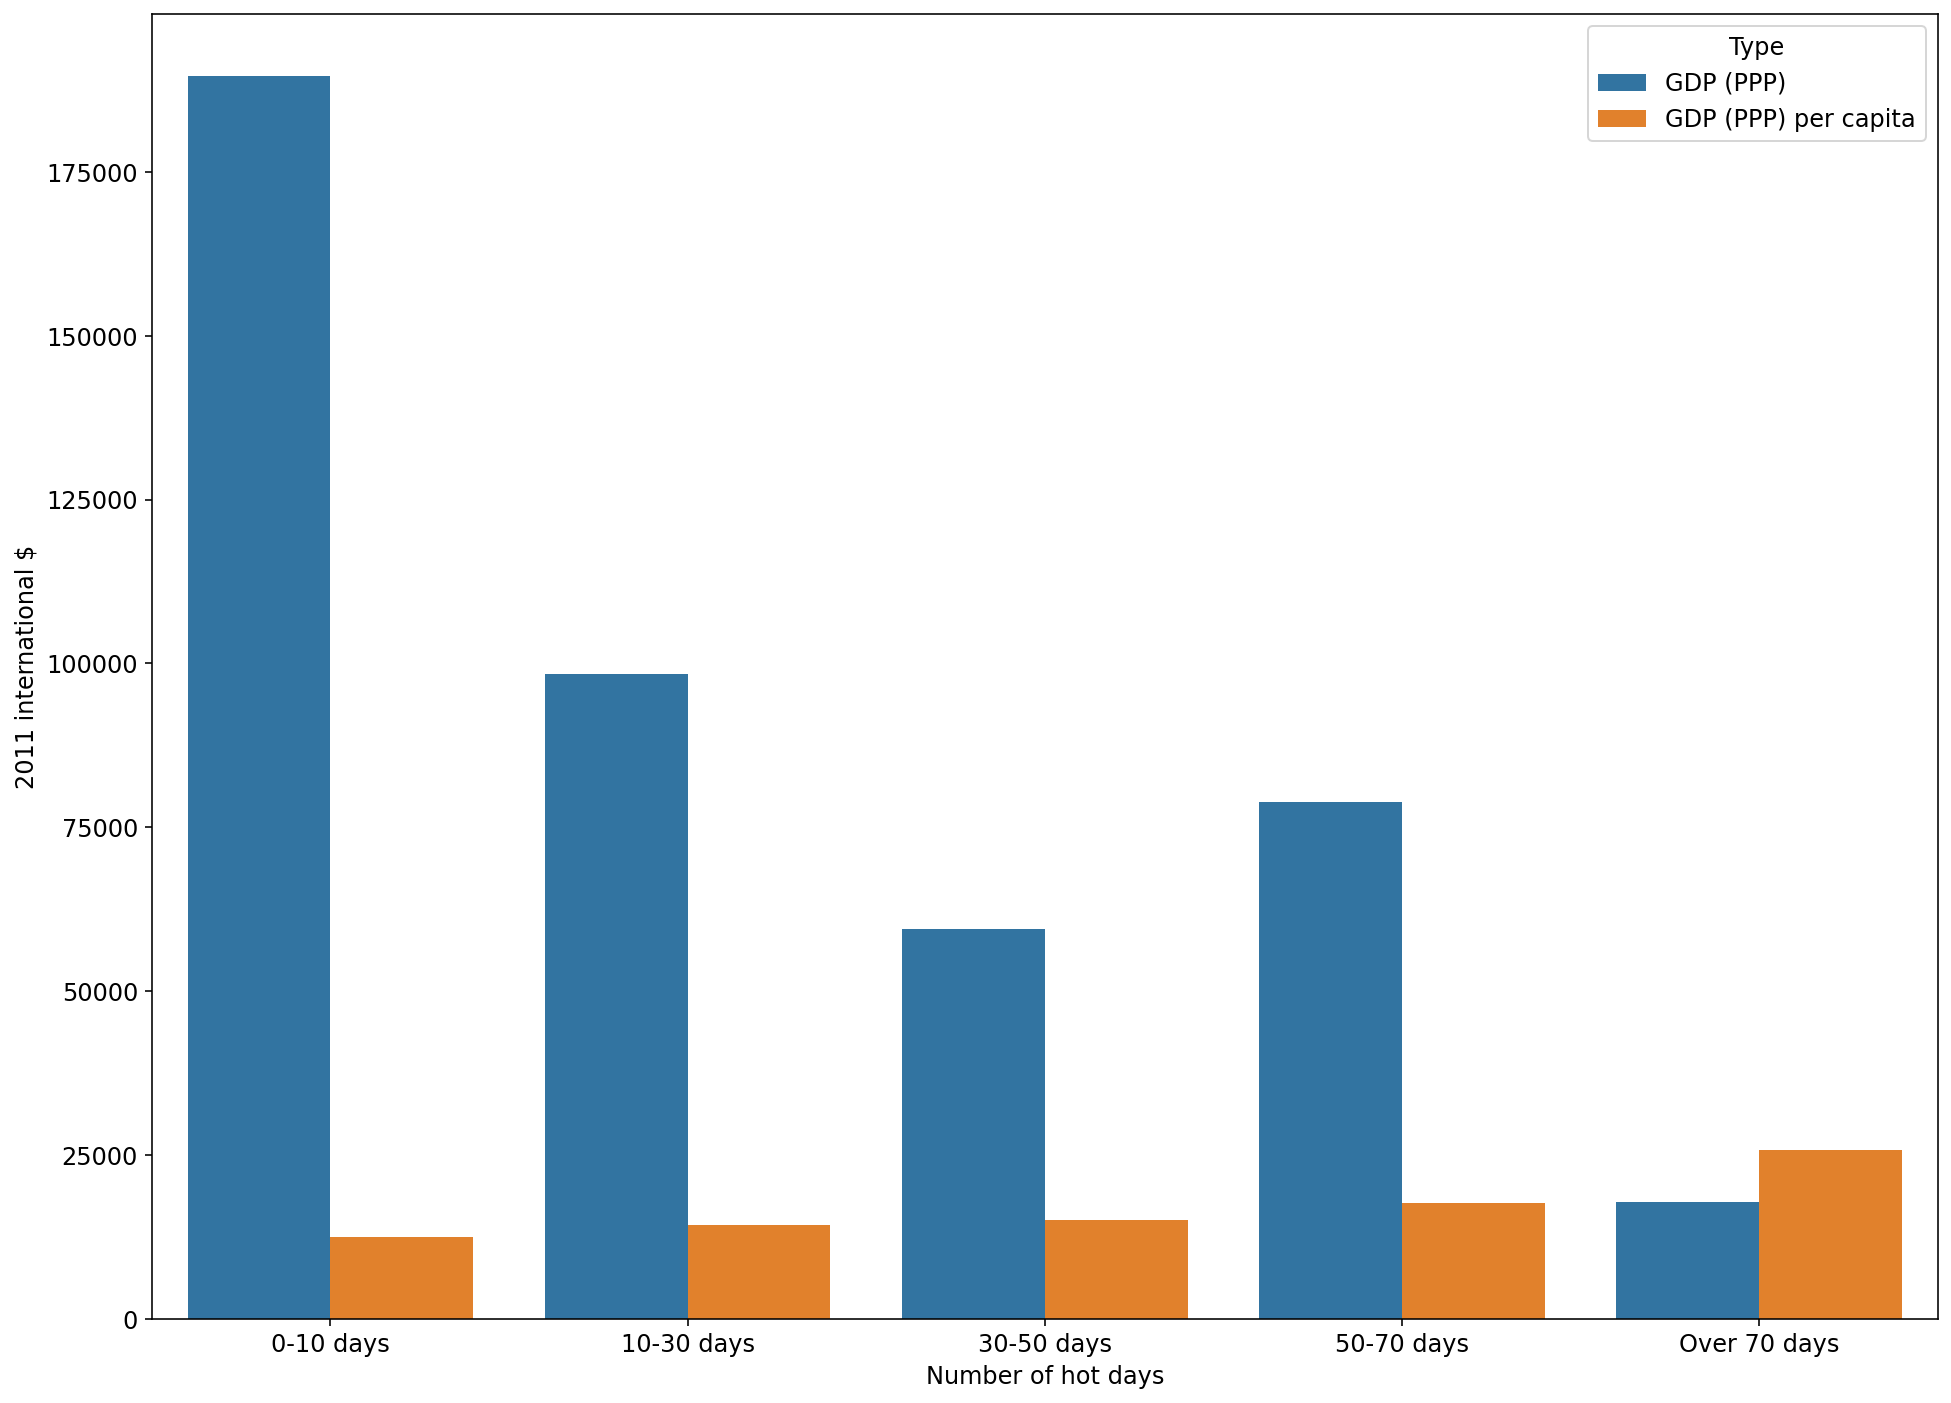

In [44]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(16,12))
ax = sns.barplot(data=melt, x="hotdays_cat", y="value", hue="GDP type")
plt.xlabel("Number of hot days")
plt.ylabel("2011 international $")
labels = ["GDP (PPP)", "GDP (PPP) per capita"]
h,l =ax.get_legend_handles_labels()
ax.legend(h, labels, 
          title='Type')
          
plt.savefig(os.path.join(plots_out_path, "GDP_and_PC_grouped.png"), dpi=200)
plt.show()

GDP plot by avg temperature

In [45]:
market_df3_groupby = market_df.groupby(["temp_cat"], as_index=False)[["GDP_PPP", "pc"]].median()
market_df3_groupby

temp_cat      GDP_PPP          pc
0     25%-50%   97959.9840  13645.4405
1     50%-75%  168468.5800  13745.4580
2  Bottom 25%   84006.8525  14821.3300
3    Over 75%  141394.3900  13862.4280

In [49]:
melt = market_df3_groupby.melt(id_vars=["temp_cat"], var_name="GDP type")
melt

temp_cat GDP type        value
0     25%-50%  GDP_PPP   97959.9840
1     50%-75%  GDP_PPP  168468.5800
2  Bottom 25%  GDP_PPP   84006.8525
3    Over 75%  GDP_PPP  141394.3900
4     25%-50%       pc   13645.4405
5     50%-75%       pc   13745.4580
6  Bottom 25%       pc   14821.3300
7    Over 75%       pc   13862.4280

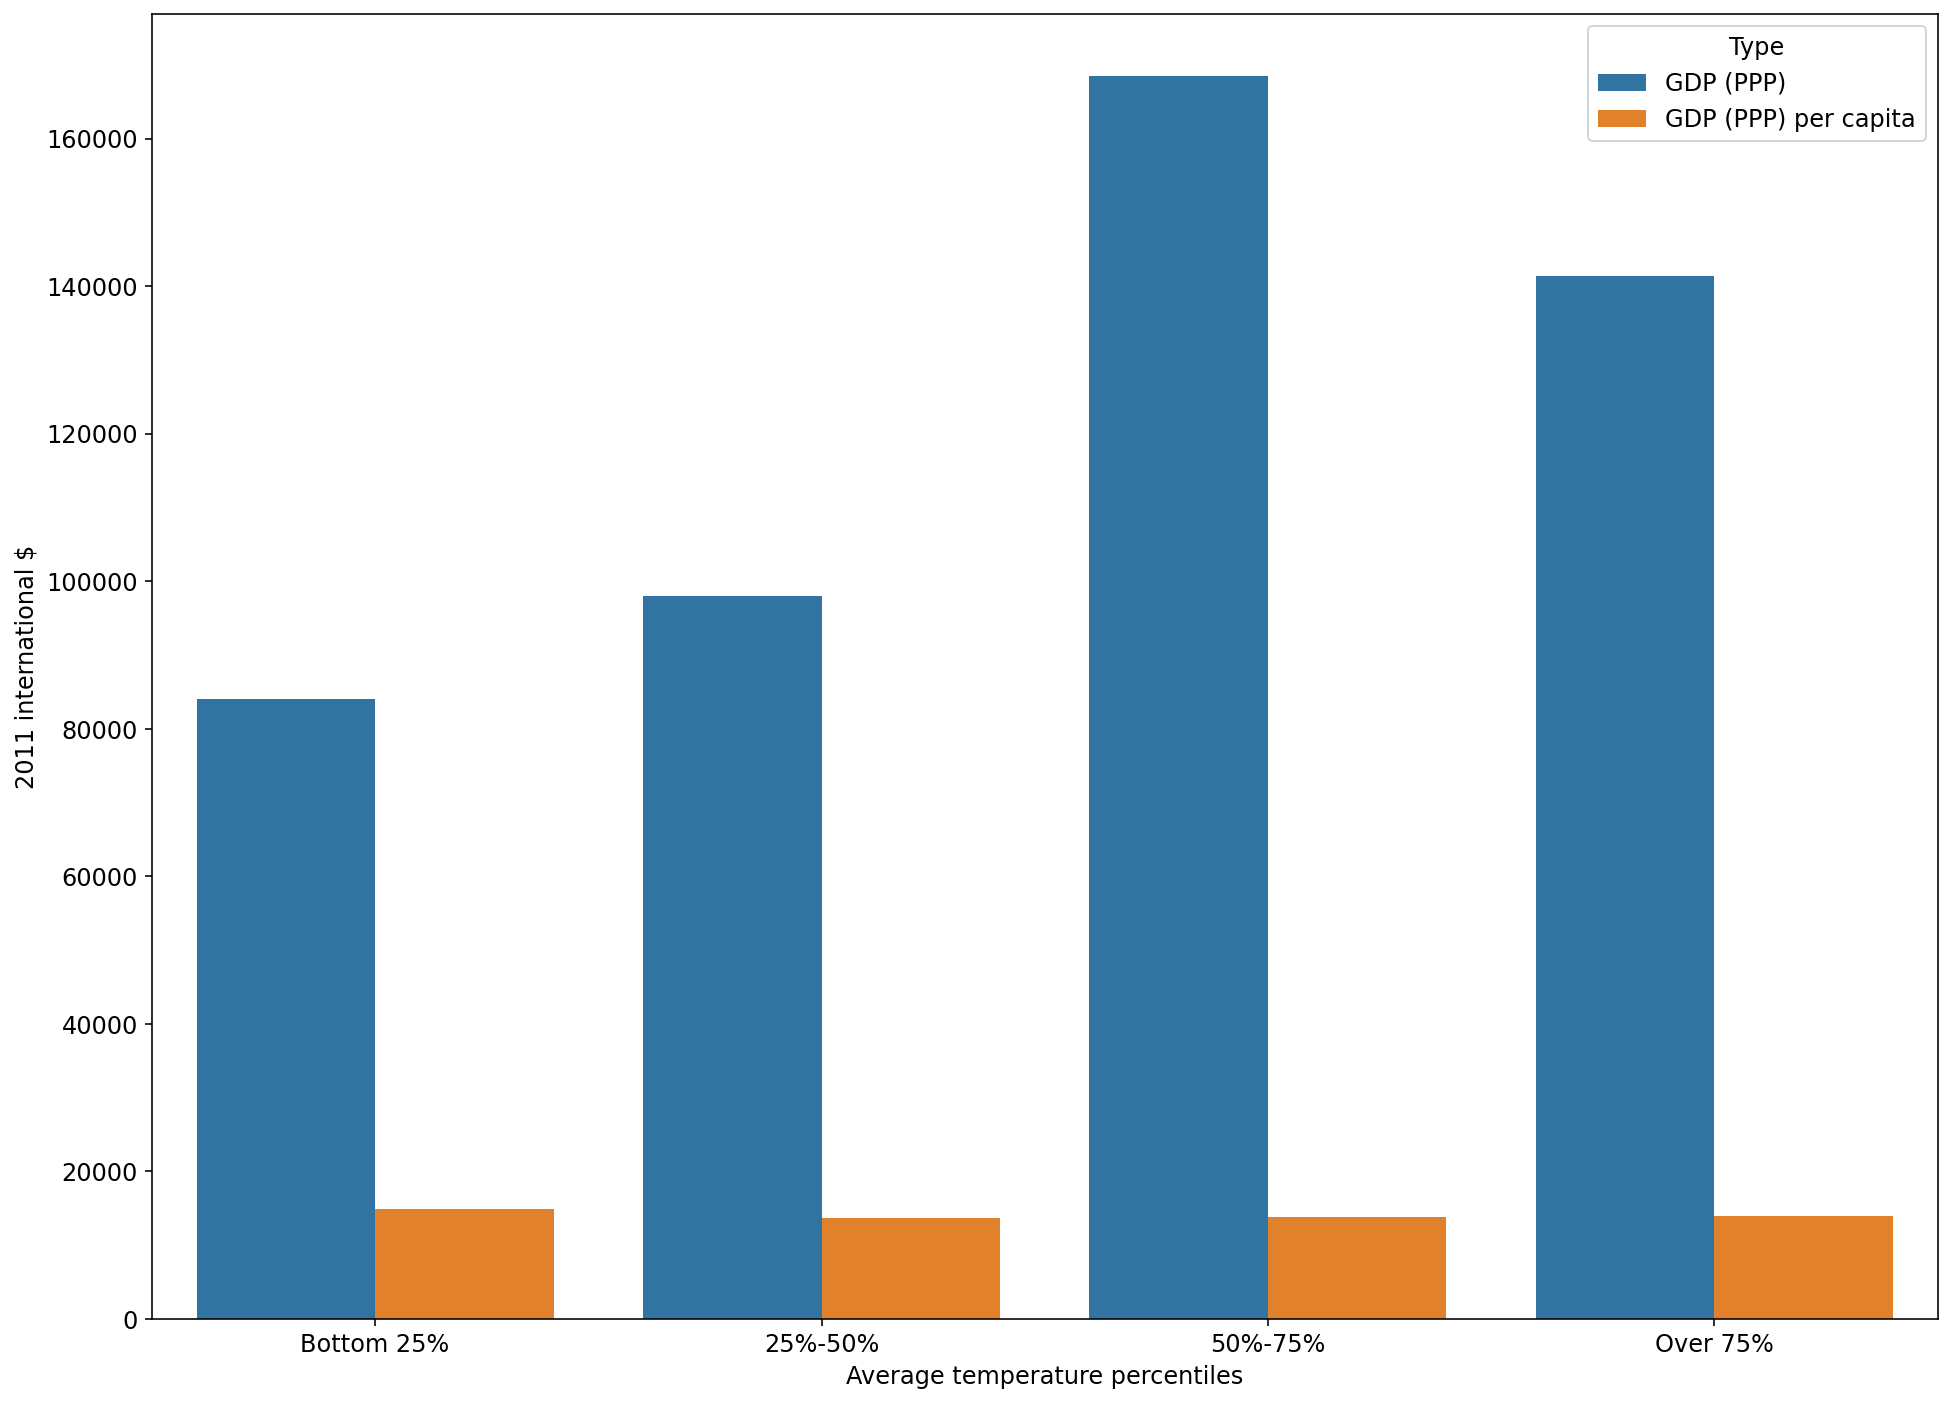

In [51]:
bar_orders=['Bottom 25%', '25%-50%', '50%-75%', 'Over 75%']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(16,12))
ax = sns.barplot(data=melt, x="temp_cat", y="value", hue="GDP type", order=bar_orders)
plt.xlabel("Average temperature percentiles")
plt.ylabel("2011 international $")
labels = ["GDP (PPP)", "GDP (PPP) per capita"]
h,l =ax.get_legend_handles_labels()
ax.legend(h, labels, 
          title='Type')
          
plt.savefig(os.path.join(plots_out_path, "GDP_and_PC_grouped_temp.png"), dpi=200)
plt.show()

Average population density by brand

In [85]:
df3 = pd.read_csv(os.path.join(data_out_path, "EDA_pop_2022_0704.csv"),index_col=0)
df3 = df3[~df3.isnull().any(axis=1)].copy()
df3

Long        Lat      pop_1       pop_3       pop_5  pop_1_cnt  \
981    19.277917  40.503750   1.304912    4.886857    6.904682        1.0   
982    19.277917  40.495417   1.710949    6.327427    6.904682        1.0   
1344   19.286250  40.487083   1.440569    5.599771    6.904682        1.0   
1704   19.294583  40.495417   0.577256    3.888822    6.904682        1.0   
2768   19.319583  40.653750   6.055185   26.432879   59.391910        1.0   
...          ...        ...        ...         ...         ...        ...   
76774  21.027917  40.645417  29.210552   56.933716  111.298668        1.0   
76781  21.027917  40.587083  29.335566  127.791671  502.068389        1.0   
76784  21.027917  40.562083  21.819565  188.948582  303.610950        1.0   
76785  21.027917  40.553750  22.285150  101.147762  205.717127        1.0   
77138  21.036250  40.620417  33.113320   80.719742  141.483517        1.0   

       pop_3_cnt  pop_5_cnt     pop_1-3     pop_3-5  
981          3.0        5.0    3.581946    2.017825  
982          4.0        5.0    4.616478    0.577256  
1344         4.0        5.0    4.159201    1.304912  
1704         3.0        5.0    3.311566    3.015860  
2768         4.0        9.0   20.377694   32.959031  
...          ...        ...         ...         ...  
76774        2.0        3.0   27.723164   54.364952  
76781        3.0        7.0   98.456105  374.276718  
76784        5.0        8.0  167.129017  114.662368  
76785        4.0        6.0   78.862612  104.569365  
77138        2.0        3.0   47.606422   60.763775  

[12934 rows x 10 columns]

In [86]:
market_df['grid_lat_5digits'] = np.round(market_df['grid_lat'],5)
market_df['grid_long_5digits'] = np.round(market_df['grid_long'],5)

df3['Lat_5digits'] = np.round(df3['Lat'],5)
df3['Long_5digits'] = np.round(df3['Long'],5)

market_df3 = market_df.merge(df3, how='inner',left_on=['grid_lat_5digits','grid_long_5digits'],right_on=['Lat_5digits','Long_5digits'])
market_df3 = market_df3.drop(['grid_lat','grid_long','grid_lat_5digits','grid_long_5digits','Lat_5digits','Long_5digits'],axis=1)
market_df3 = market_df3.rename({'Lat':'grid_lat','Long':'grid_lng'},axis=1)
market_df3.head()

name                                            address  \
0    Spar Albania  Tirana East Gate, Km 5°, 1045, Rruga e Elbasan...   
1            Spar    8R98+6Q7, Rruga Perlat Rexhepi, Tiranë, Albania   
2            Spar    MCN Tower, Rruga Ismail Qemali, Tirana, Albania   
3           Conad                          8RFF+H7X, Tirana, Albania   
4  Conad Akademia    8R89+WJ7, Rruga Ibrahim Rugova, Tirana, Albania   

                                               types        lat        lng  \
0  ['supermarket', 'grocery_or_supermarket', 'foo...  41.282983  19.857599   
1  ['supermarket', 'grocery_or_supermarket', 'foo...  41.318041  19.816914   
2  ['grocery_or_supermarket', 'food', 'point_of_i...  41.321775  19.823642   
3  ['supermarket', 'grocery_or_supermarket', 'sto...  41.323986  19.823236   
4  ['supermarket', 'grocery_or_supermarket', 'sto...  41.317293  19.819046   

   brand loc_admin   grid_lng      GDP_PPP  population  ...   grid_lng  \
0   Spar    Tirane  19.861250   15682235.0    928.5934  ...  19.861250   
1   Spar    Tirane  19.819583  161241490.0   9611.0540  ...  19.819583   
2   Spar    Tirane  19.819583  161241490.0   9611.0540  ...  19.819583   
3  Conad    Tirane  19.819583  161241490.0   9611.0540  ...  19.819583   
4  Conad    Tirane  19.819583  161241490.0   9611.0540  ...  19.819583   

    grid_lat      pop_1        pop_3         pop_5 pop_1_cnt  pop_3_cnt  \
0  41.287083   928.5934   7819.07719   17319.88758       1.0        9.0   
1  41.320417  9611.0540  71644.67690  181578.77090       1.0        9.0   
2  41.320417  9611.0540  71644.67690  181578.77090       1.0        9.0   
3  41.320417  9611.0540  71644.67690  181578.77090       1.0        9.0   
4  41.320417  9611.0540  71644.67690  181578.77090       1.0        9.0   

   pop_5_cnt      pop_1-3       pop_3-5  
0       24.0   6890.48379    9500.81039  
1       25.0  62033.62290  109934.09400  
2       25.0  62033.62290  109934.09400  
3       25.0  62033.62290  109934.09400  
4       25.0  62033.62290  109934.09400  

[5 rows x 27 columns]

In [87]:
# generate 3km and 5km average population density
market_df3["pop_1km"] = market_df3["pop_1"]
market_df3["pop_3km"] = (market_df3["pop_1"] + market_df3["pop_1-3"]) / 3
market_df3["pop_5km"] = (market_df3["pop_1"] + market_df3["pop_1-3"] + market_df3["pop_3-5"]) / 5

In [88]:
market_df3_groupby_pop = market_df3.groupby(["brand"], as_index=False)[["pop_1km", "pop_3km", "pop_5km"]].mean()
market_df3_groupby_pop

brand      pop_1km       pop_3km       pop_5km
0    Big Market  4720.790556  11959.244112  16085.276752
1         Conad  6827.888835  17640.724941  24689.204926
2    Eco market  4971.285114  13950.532278  19613.191871
3  Extra Market  3372.588336   8390.103572  10846.854069
4          Spar  4847.797648  12038.288792  16245.378652

In [89]:
melt2 = market_df3_groupby_pop.melt(id_vars=["brand"], var_name="pop_grid")
melt2

brand pop_grid         value
0     Big Market  pop_1km   4720.790556
1          Conad  pop_1km   6827.888835
2     Eco market  pop_1km   4971.285114
3   Extra Market  pop_1km   3372.588336
4           Spar  pop_1km   4847.797648
5     Big Market  pop_3km  11959.244112
6          Conad  pop_3km  17640.724941
7     Eco market  pop_3km  13950.532278
8   Extra Market  pop_3km   8390.103572
9           Spar  pop_3km  12038.288792
10    Big Market  pop_5km  16085.276752
11         Conad  pop_5km  24689.204926
12    Eco market  pop_5km  19613.191871
13  Extra Market  pop_5km  10846.854069
14          Spar  pop_5km  16245.378652

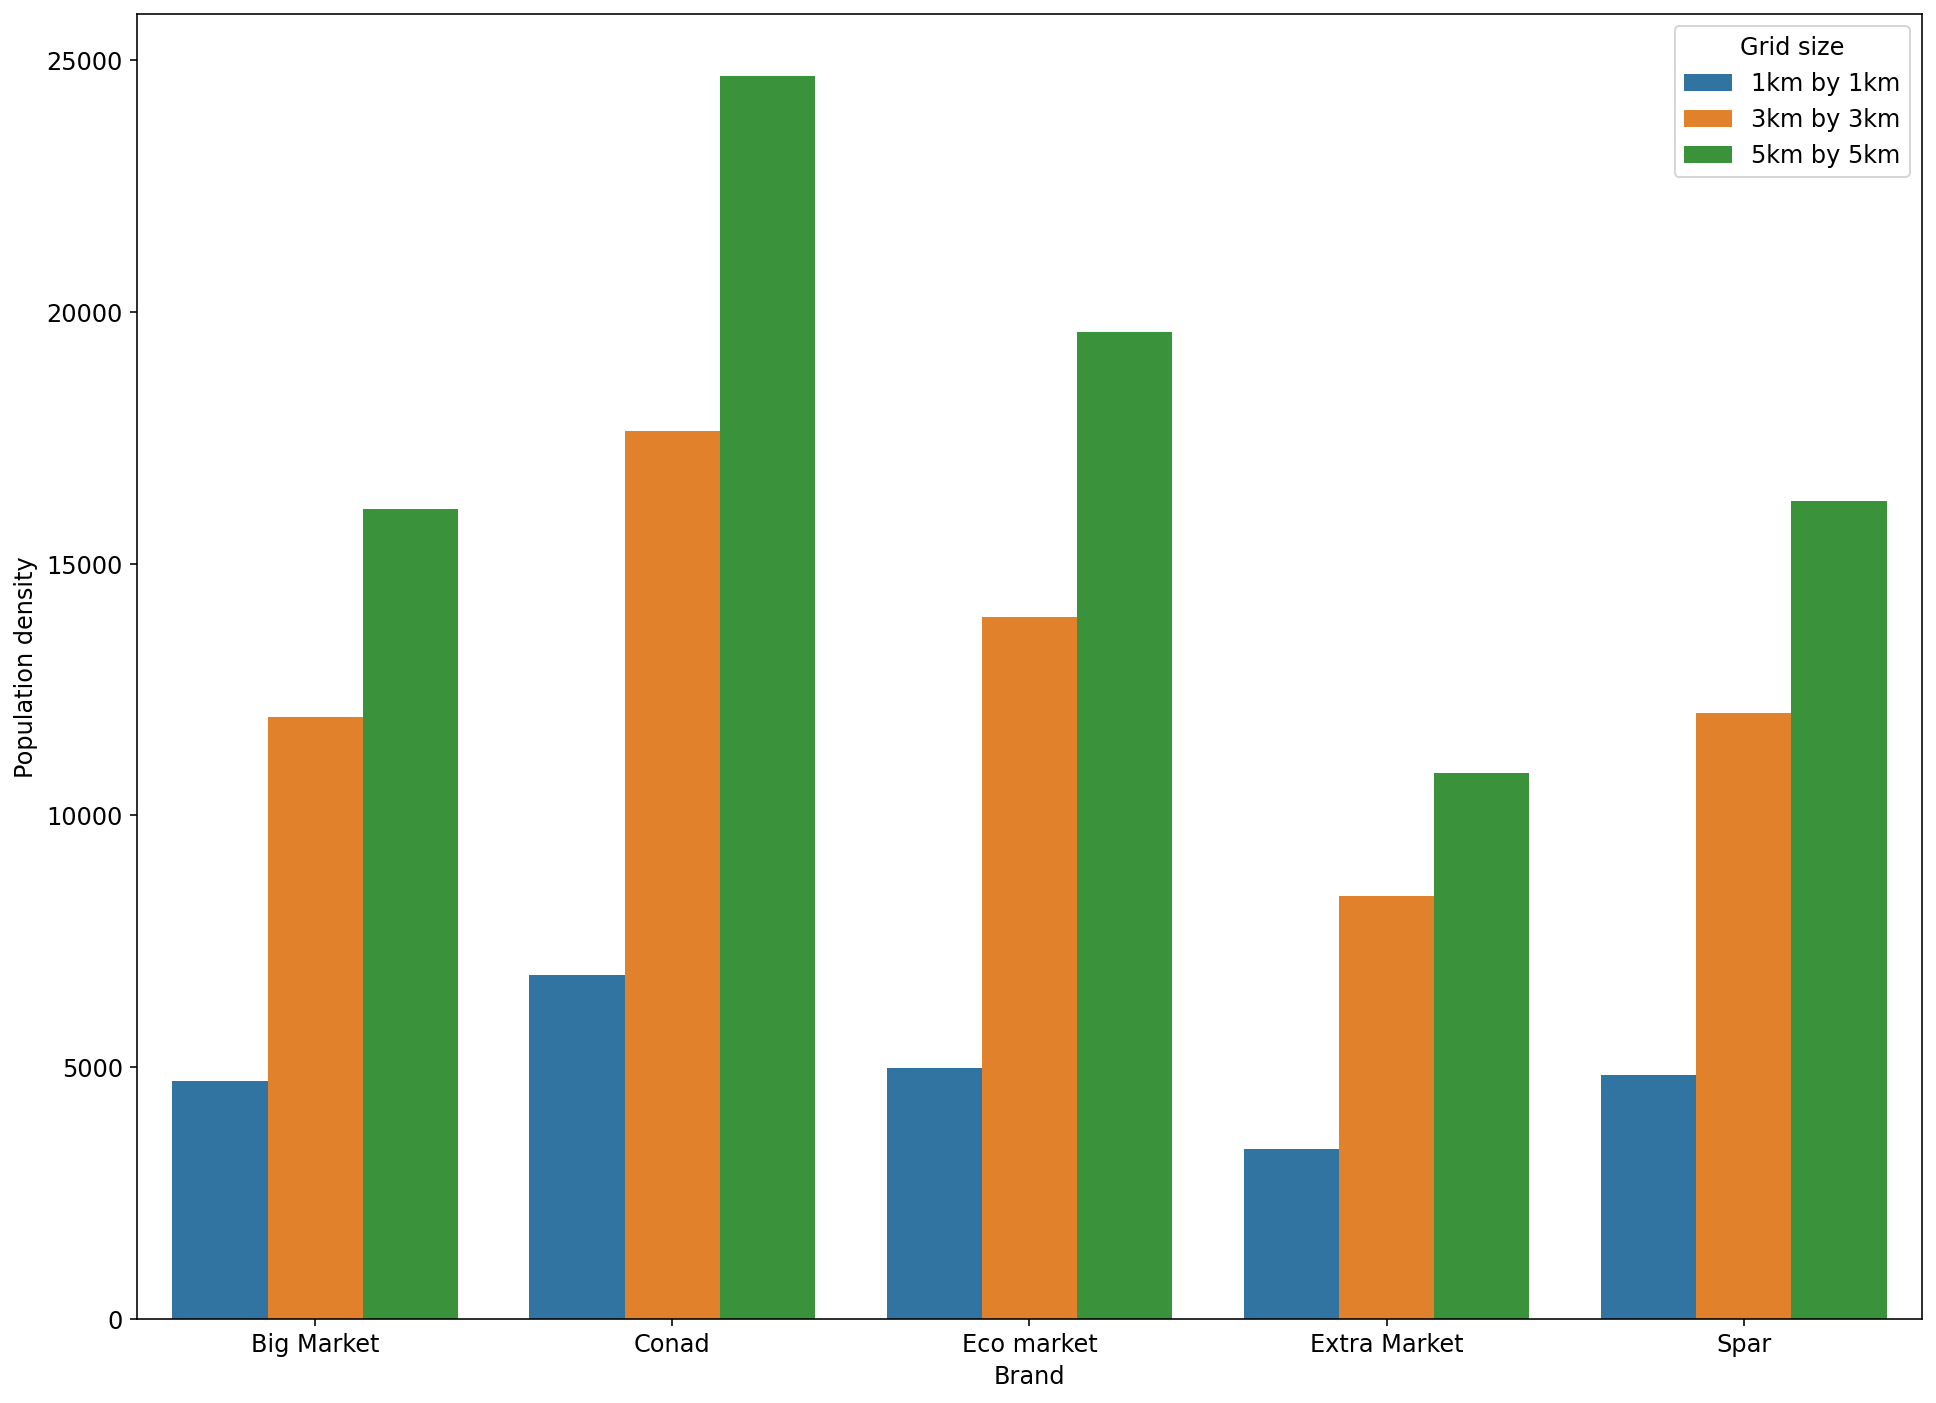

In [90]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(16,12))
ax = sns.barplot(data=melt2, x="brand", y="value", hue="pop_grid")
plt.xlabel("Brand")
plt.ylabel("Population density")
labels = ["1km by 1km", "3km by 3km", "5km by 5km"]
h,l =ax.get_legend_handles_labels()
ax.legend(h, labels, 
          title='Grid size')

plt.savefig(os.path.join(plots_out_path, "pop_density_1_3_5.png"), dpi=200)          
plt.show()

Scatter plot of store population density by GDP

In [91]:
market_df.head(10)

name  \
0              Spar Albania   
1                      Spar   
2                      Spar   
3                     Conad   
4            Conad Akademia   
5      Spar Hypermarket QTU   
6        Conad Albania shpk   
7               Spar Market   
8                     Conad   
9  Eco Market Rruga Kavajes   

                                             address  \
0  Tirana East Gate, Km 5°, 1045, Rruga e Elbasan...   
1    8R98+6Q7, Rruga Perlat Rexhepi, Tiranë, Albania   
2    MCN Tower, Rruga Ismail Qemali, Tirana, Albania   
3                          8RFF+H7X, Tirana, Albania   
4    8R89+WJ7, Rruga Ibrahim Rugova, Tirana, Albania   
5       9P3X+9JG, Rruga Industriale, Kashar, Albania   
6                          9P4X+CGP, Kashar, Albania   
7       8RH5+GX3, Rruga e Bogdanëve, Tirana, Albania   
8                          8RG5+V2F, Tirana, Albania   
9         8RG6+R44, Rruga Him Kolli, Tirana, Albania   

                                               types        lat        lng  \
0  ['supermarket', 'grocery_or_supermarket', 'foo...  41.282983  19.857599   
1  ['supermarket', 'grocery_or_supermarket', 'foo...  41.318041  19.816914   
2  ['grocery_or_supermarket', 'food', 'point_of_i...  41.321775  19.823642   
3  ['supermarket', 'grocery_or_supermarket', 'sto...  41.323986  19.823236   
4  ['supermarket', 'grocery_or_supermarket', 'sto...  41.317293  19.819046   
5  ['supermarket', 'grocery_or_supermarket', 'foo...  41.353432  19.749063   
6  ['department_store', 'store', 'point_of_intere...  41.356099  19.748826   
7  ['grocery_or_supermarket', 'food', 'point_of_i...  41.328753  19.809930   
8  ['grocery_or_supermarket', 'store', 'food', 'p...  41.327175  19.807546   
9  ['supermarket', 'grocery_or_supermarket', 'foo...  41.327017  19.810315   

        brand loc_admin   grid_lat   grid_lng      GDP_PPP  ...         pc  \
0        Spar    Tirane  41.287083  19.861250   15682235.0  ...  16888.162   
1        Spar    Tirane  41.320417  19.819583  161241490.0  ...  16776.672   
2        Spar    Tirane  41.320417  19.819583  161241490.0  ...  16776.672   
3       Conad    Tirane  41.320417  19.819583  161241490.0  ...  16776.672   
4       Conad    Tirane  41.320417  19.819583  161241490.0  ...  16776.672   
5        Spar    Tirane  41.353750  19.752917   43821668.0  ...  16397.285   
6       Conad    Tirane  41.353750  19.752917   43821668.0  ...  16397.285   
7        Spar    Tirane  41.328750  19.811250  181929820.0  ...  17742.592   
8       Conad    Tirane  41.328750  19.811250  181929820.0  ...  17742.592   
9  Eco market    Tirane  41.328750  19.811250  181929820.0  ...  17742.592   

   nightlight  grid_long  grid_lat_5digits  grid_long_5digits    size  \
0    9.645451  19.861250          41.28708           19.86125    Spar   
1   97.426476  19.819583          41.32042           19.81958    Spar   
2   97.426476  19.819583          41.32042           19.81958    Spar   
3   97.426476  19.819583          41.32042           19.81958  Others   
4   97.426476  19.819583          41.32042           19.81958  Others   
5   32.000072  19.752917          41.35375           19.75292    Spar   
6   32.000072  19.752917          41.35375           19.75292  Others   
7   60.573170  19.811250          41.32875           19.81125    Spar   
8   60.573170  19.811250          41.32875           19.81125  Others   
9   60.573170  19.811250          41.32875           19.81125  Others   

  GDP_rating GDP_rank  population_rating population_rank  
0    10%-30%    178.0            10%-30%           191.0  
1    70%-90%     47.0            70%-90%            44.0  
2    70%-90%     47.0            70%-90%            44.0  
3    70%-90%     47.0            70%-90%            44.0  
4    70%-90%     47.0            70%-90%            44.0  
5    30%-50%    124.0            10%-30%           153.0  
6    30%-50%    124.0            10%-30%           153.0  
7   95%-100%      3.0            70%-90%            22.0  
8   95%-100

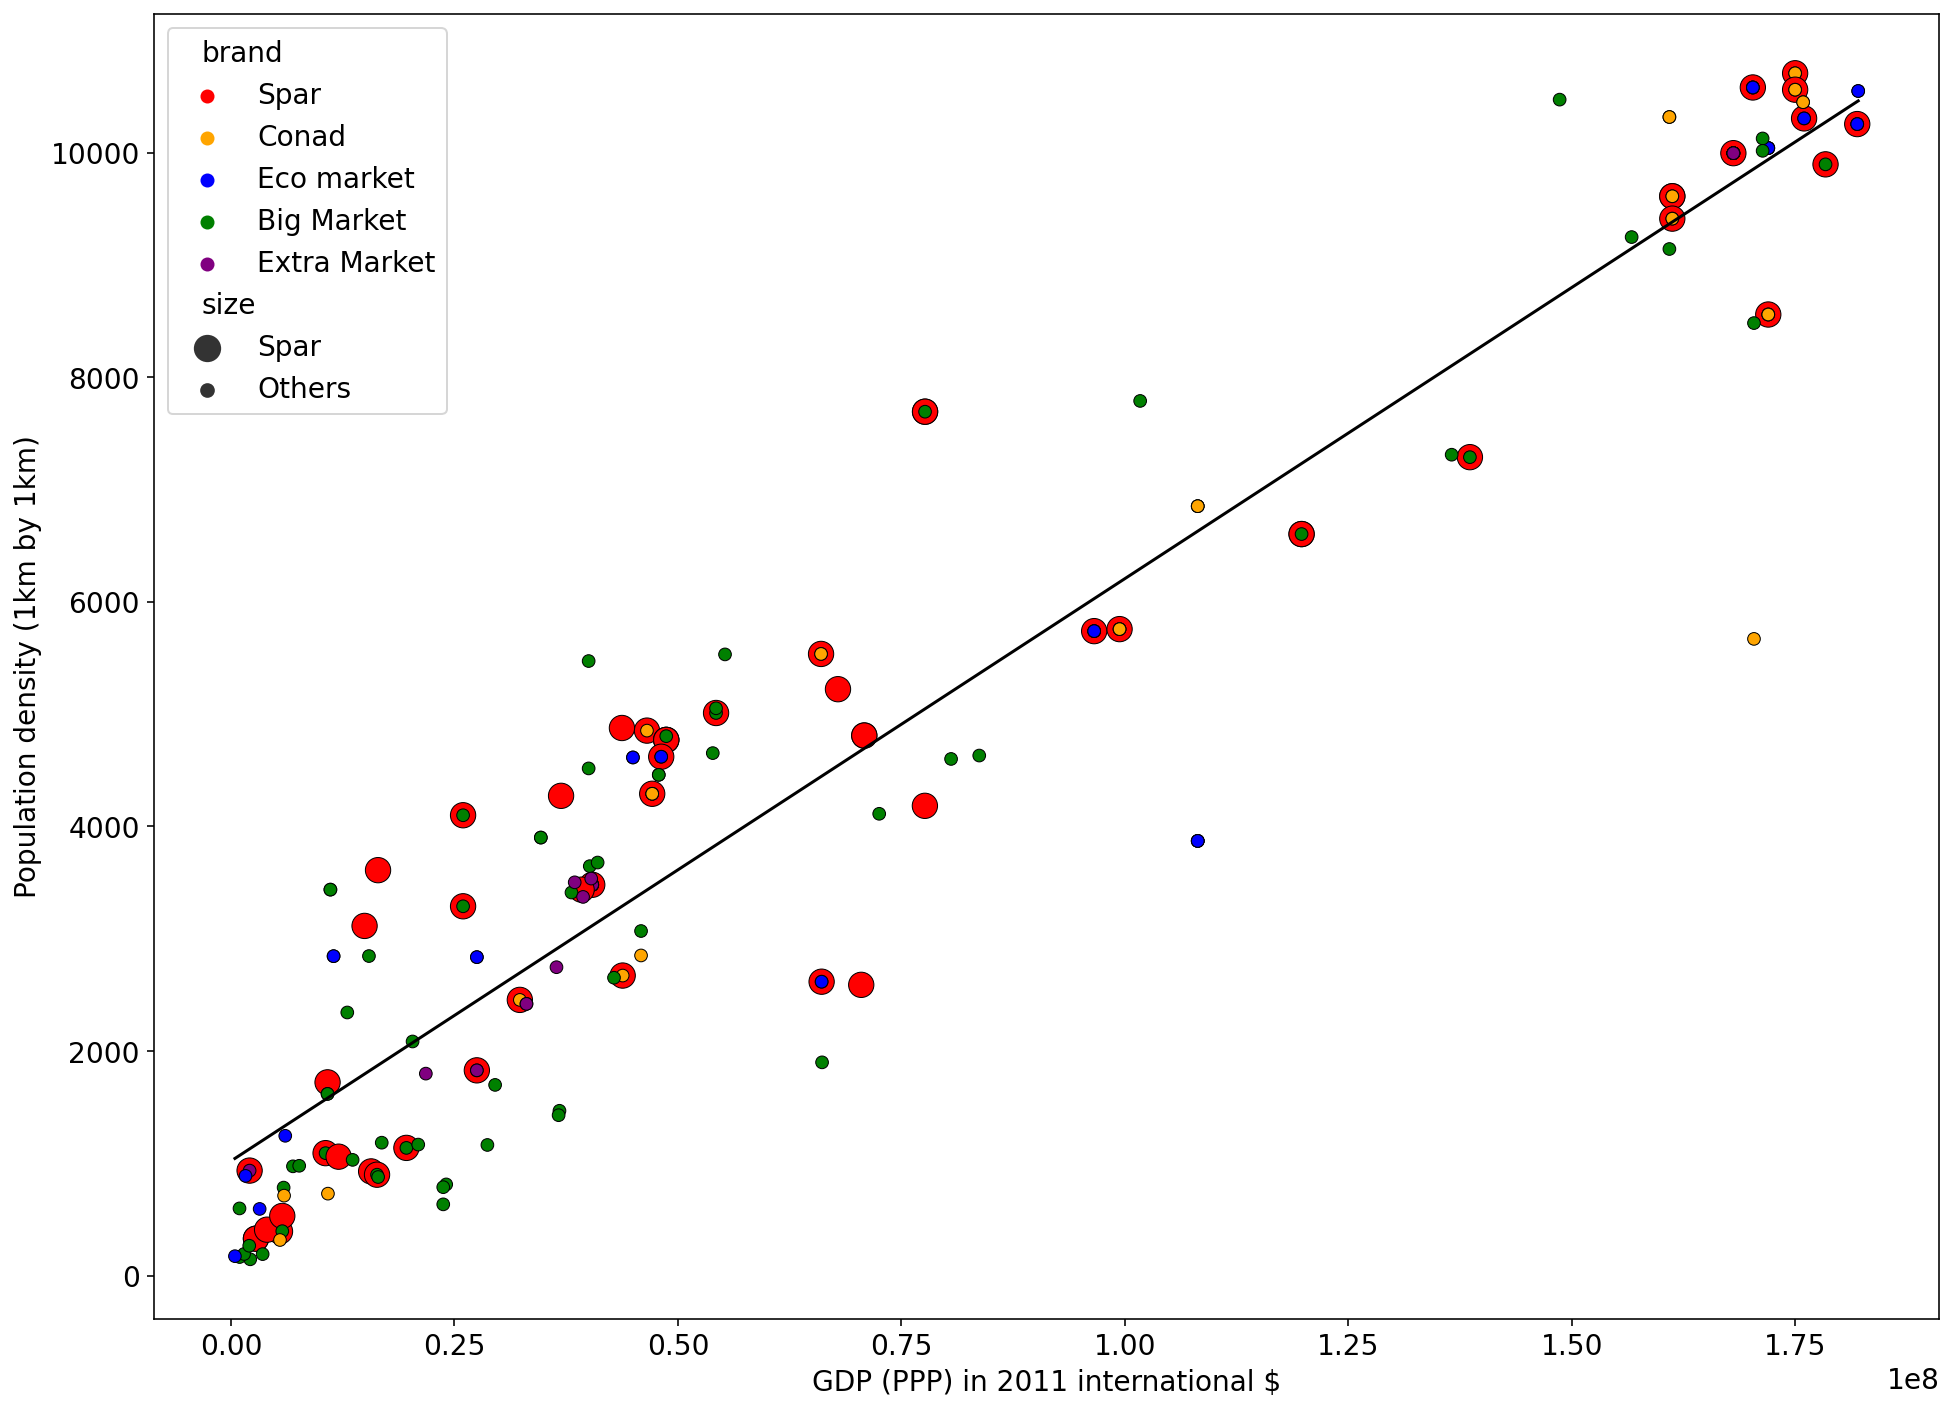

In [105]:
market_df["size"] = np.where(market_df["brand"] == "Spar", "Spar", "Others")
color_dict = dict({"Spar":"red", "Conad":"orange", "Eco market":"blue", "Big Market": "green", "Extra Market":"purple"})
plt.rcParams.update({"font.size": 14})
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x=market_df["GDP_PPP"],
    y=market_df["population"],
    hue=market_df["brand"],
    palette=color_dict,
    marker="o",
    size=market_df["size"],
    size_order=("Spar", "Others"),
    sizes=(40, 160),
    edgecolor="k",
)

sns.regplot(
    x=market_df["GDP_PPP"],
    y=market_df["population"],
    scatter=False,
    ci=None,
    line_kws={"linewidth": 1.5, "color": "black"},
)

plt.xlabel("GDP (PPP) in 2011 international $")
plt.ylabel("Population density (1km by 1km)")
plt.savefig(os.path.join(plots_out_path, "scatter_plot.png"))
plt.show()


### GDP ranking

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_49227/3169201707.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


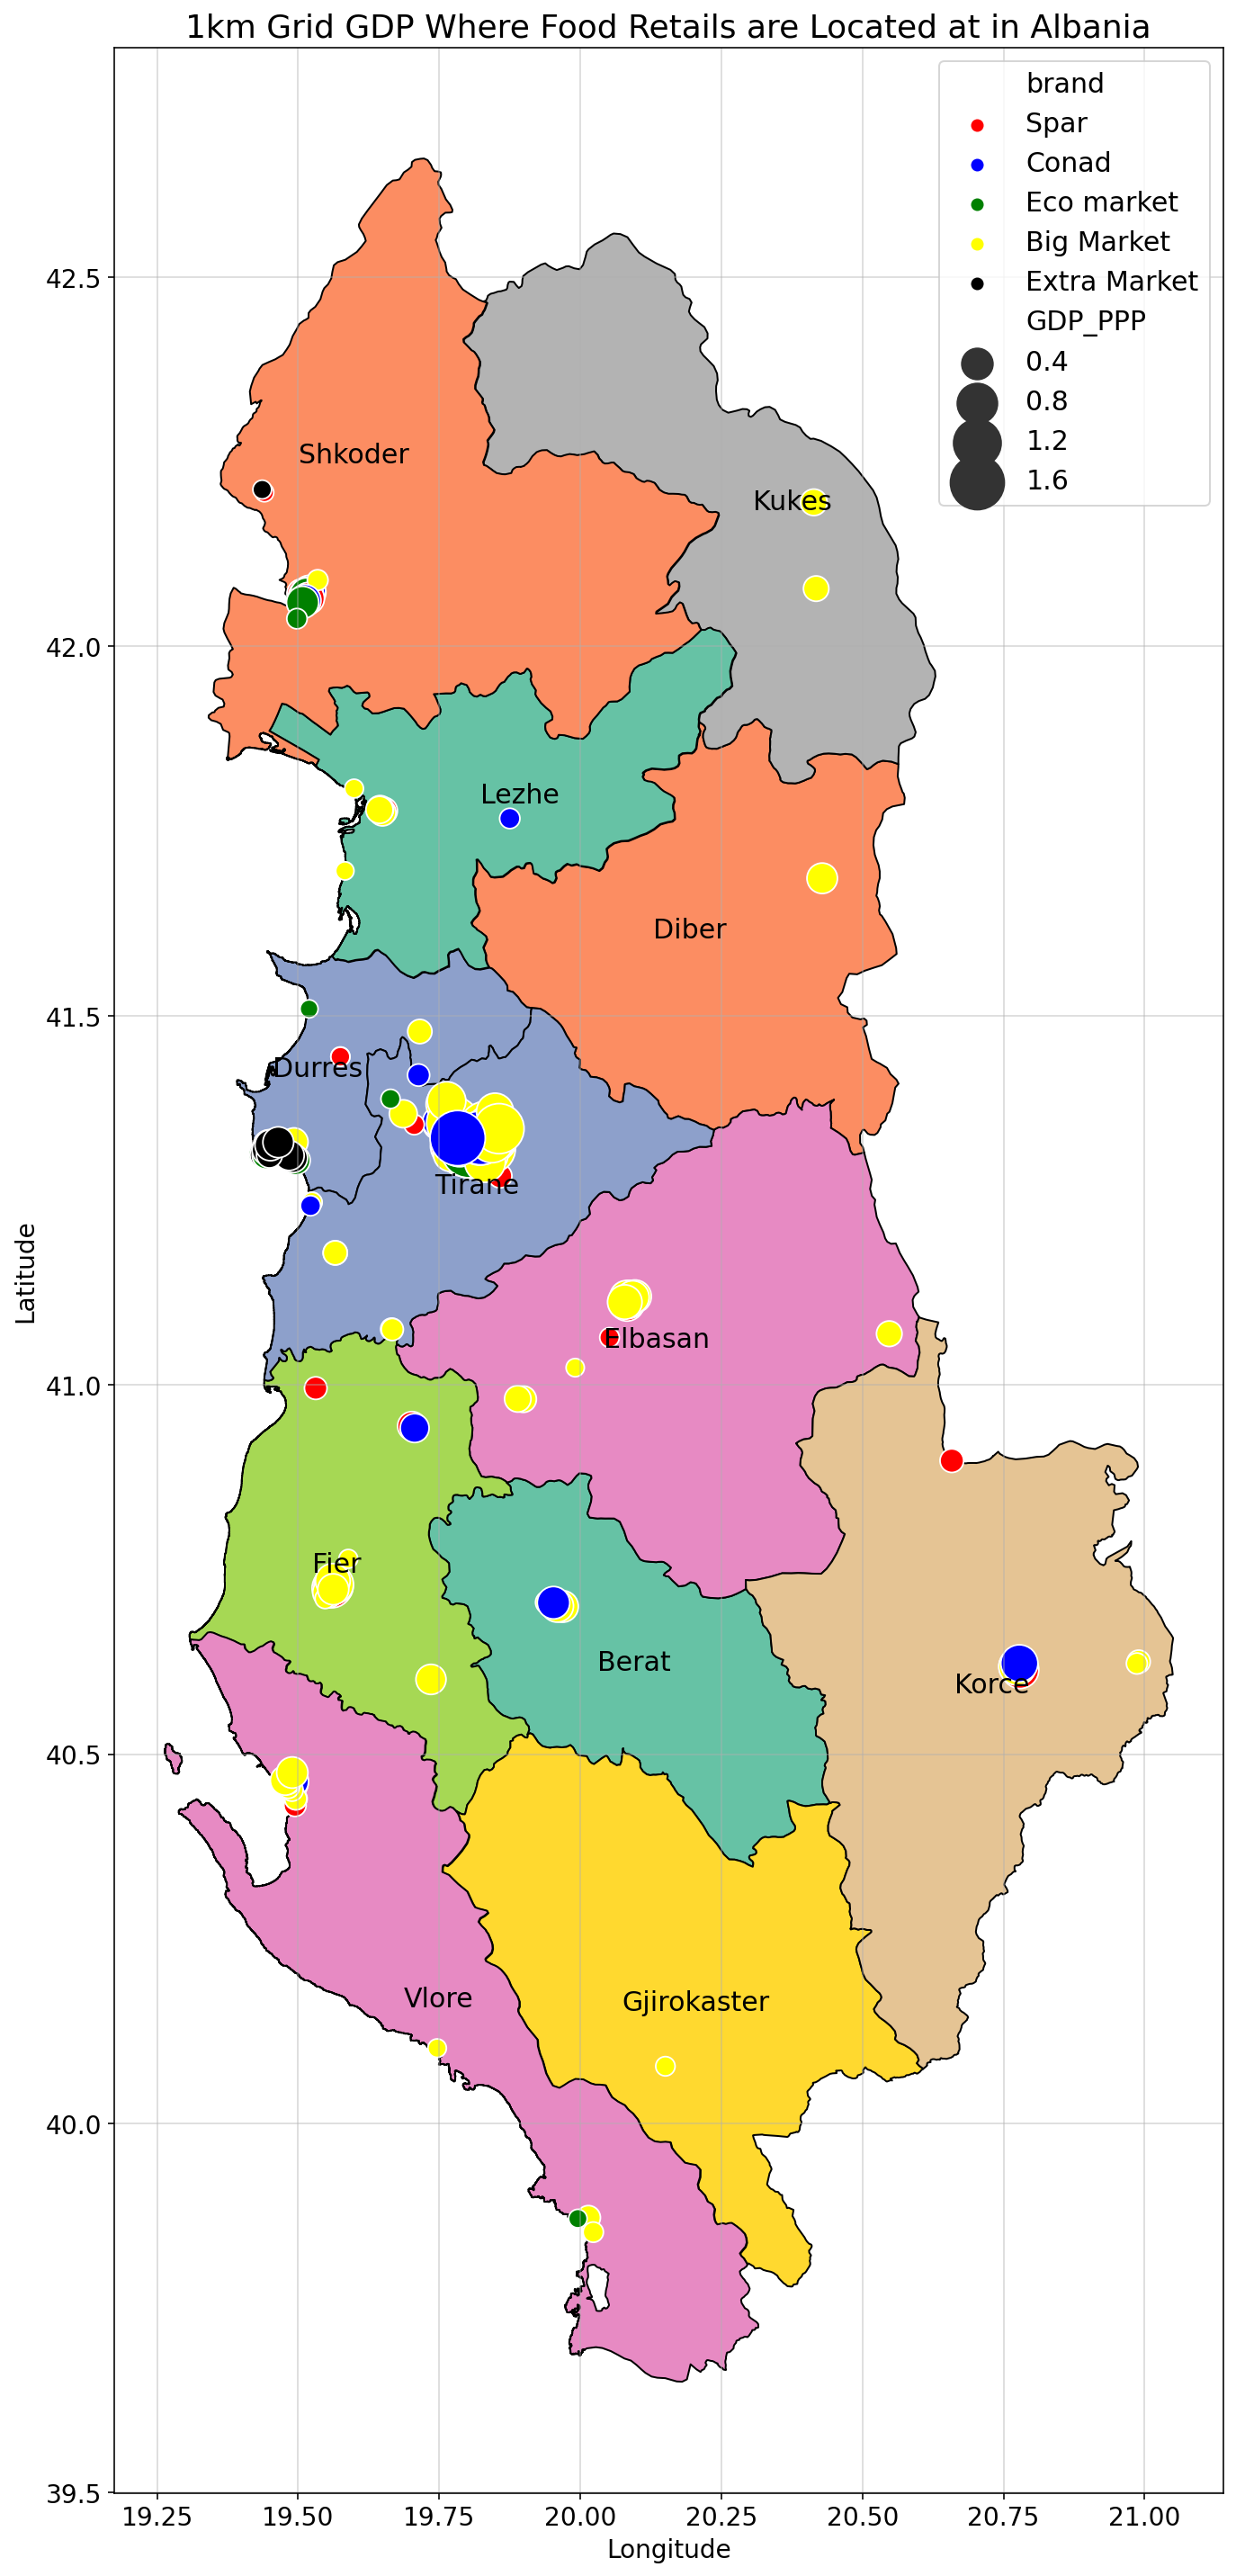

In [93]:
# initialize an axis
fig, ax = plt.subplots(figsize=(20,25))
plt.rcParams.update({'font.size': 15})
# plot map on axis
for i in range(len(admin['ADM1_EN'])):
    x = admin['ADM1_EN'][i]
    admin[admin['ADM1_EN']==x].plot(color=colors[i%len(colors)],edgecolor="black",
                                                 ax=ax)
    
    
admin['coords'] = admin['geometry'].apply(lambda x: x.representative_point().coords[:])
admin['coords'] = [coords[0] for coords in admin['coords']]
for idx, row in admin.iterrows():
    plt.annotate(text=row['ADM1_EN'], xy=row['coords'],
                 horizontalalignment='center',fontsize=15)

# plot points
sns.scatterplot(x="lng", y="lat", data=market_df, size ="GDP_PPP",hue="brand",sizes = (100,1000),palette=['red','blue','green','yellow','black'])
plt.title("1km Grid GDP Where Food Retails are Located at in Albania")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.legend(loc=1,prop={'size': 15})
# add grid
ax.grid(b=True, alpha=0.5)
plt.show()

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_49227/991574993.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


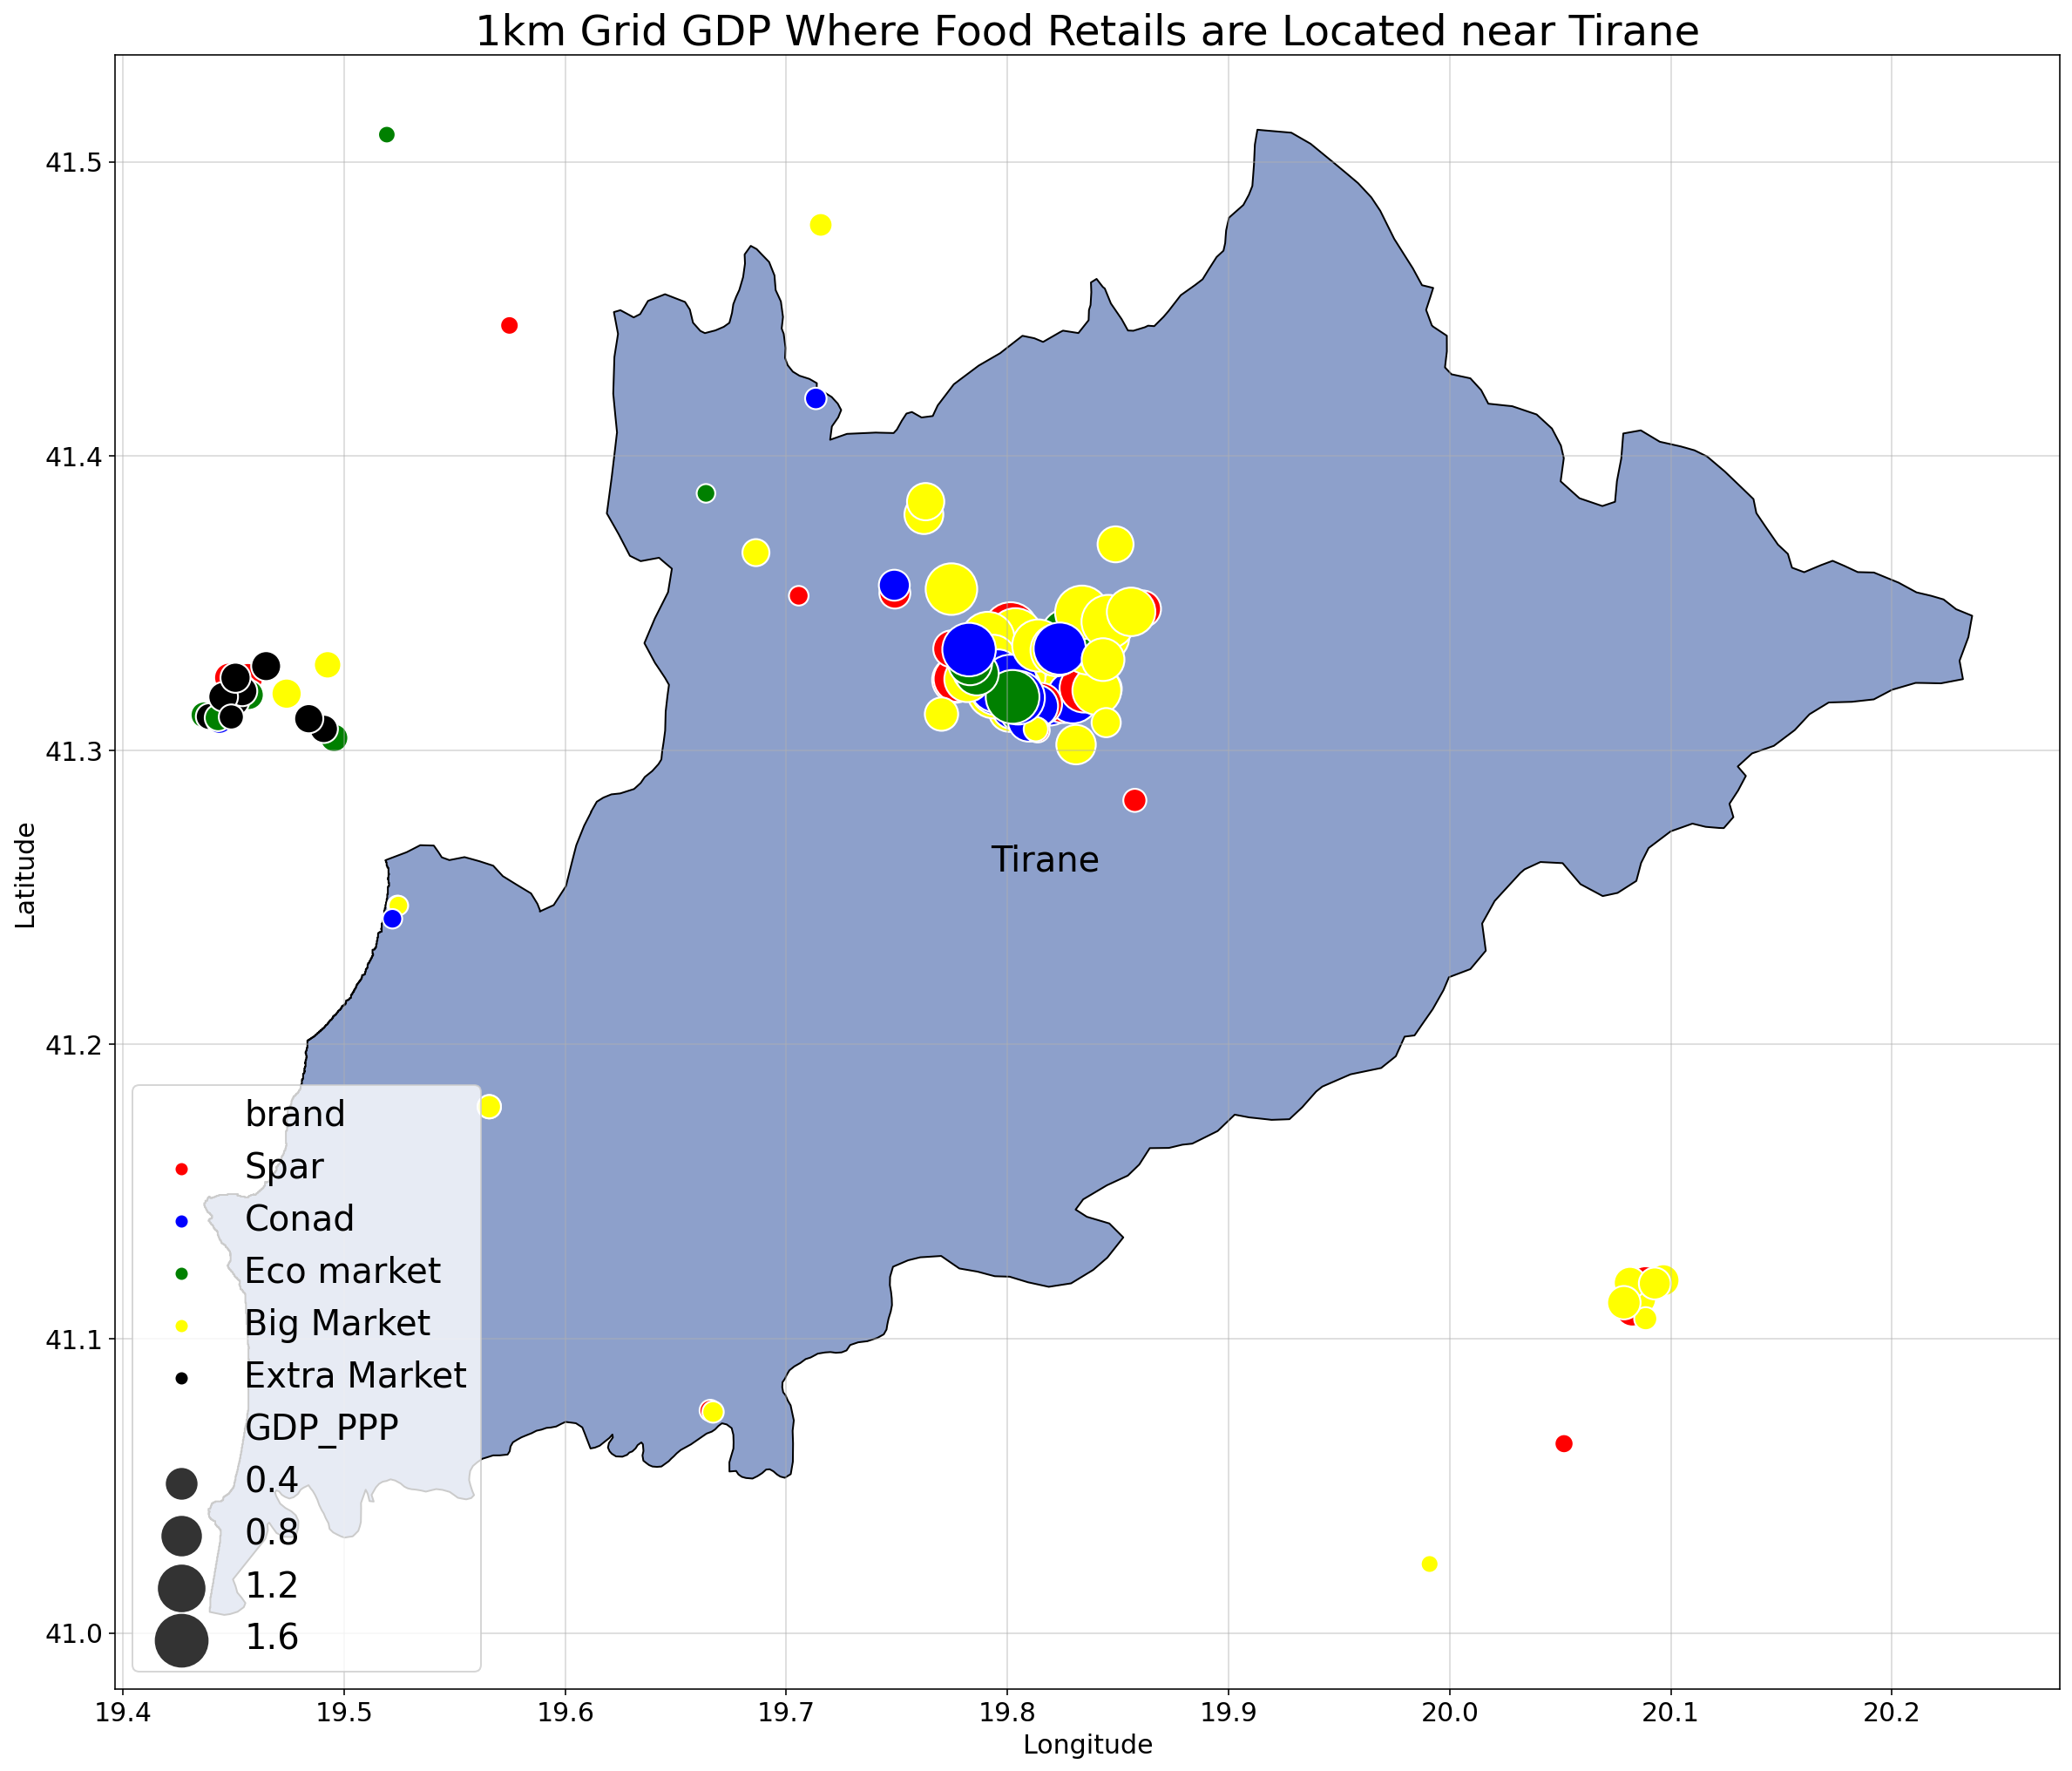

In [94]:
# initialize an axis
fig, ax = plt.subplots(figsize=(20,28))
plt.rcParams.update({'font.size': 20})
# plot map on axis
for i in range(len(admin['ADM1_EN'])):
    x = admin['ADM1_EN'][i]
    if x =='Tirane':
        admin[admin['ADM1_EN']==x].plot(color=colors[i%len(colors)],edgecolor="black",
                                                     ax=ax)

    
admin['coords'] = admin['geometry'].apply(lambda x: x.representative_point().coords[:])
admin['coords'] = [coords[0] for coords in admin['coords']]
for idx, row in admin.iterrows():
    if row['ADM1_EN']=='Tirane':
        plt.annotate(text=row['ADM1_EN'], xy=row['coords'],
                     horizontalalignment='center',fontsize=20)

# plot points
tirane_market_df= market_df[(market_df['lng']>19.25)&(market_df['lng']<20.3)&(market_df['lat']>41)&(market_df['lat']<41.55)].copy()
sns.scatterplot(x="lng", y="lat", data=tirane_market_df, size ="GDP_PPP",sizes = (100,1000),
               hue="brand",palette=['red','blue','green','yellow','black'])
plt.title("1km Grid GDP Where Food Retails are Located near Tirane")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.legend(loc=3,prop={'size': 20})

# add grid
ax.grid(b=True, alpha=0.5)

In [95]:
gdp_values = market_df['GDP_PPP']
gdp_cutoff = np.nanquantile(gdp_values,[0.05,0.1,0.3,0.5,0.7,0.9,0.95])
market_df['GDP_rating'] = ['nan']*len(gdp_values)
market_df.loc[~np.isnan(gdp_values),'GDP_rating'] = "0%-5%"
market_df.loc[gdp_values > gdp_cutoff[0],'GDP_rating'] = "5%-10%"
market_df.loc[gdp_values > gdp_cutoff[1],'GDP_rating'] = '10%-30%'
market_df.loc[gdp_values > gdp_cutoff[2],'GDP_rating'] = "30%-50%"
market_df.loc[gdp_values > gdp_cutoff[3],'GDP_rating'] = '50%-70%'
market_df.loc[gdp_values > gdp_cutoff[4],'GDP_rating'] = '70%-90%'
market_df.loc[gdp_values > gdp_cutoff[5],'GDP_rating'] = '90%-95%'
market_df.loc[gdp_values > gdp_cutoff[6],'GDP_rating'] = '95%-100%'
market_df['GDP_rank']=market_df['GDP_PPP'].rank(method='min',ascending=False)
market_df.sort_values(by='GDP_PPP',ascending=False)[['GDP_rank',
                                               'GDP_rating',
                                               'GDP_PPP',
                                               'lat',
                                               'lng',
                                               'address',
                                               'name']]

GDP_rank GDP_rating       GDP_PPP        lat        lng  \
134       1.0   95%-100%  1.820386e+08  41.337095  19.825198   
135       1.0   95%-100%  1.820386e+08  41.338876  19.827356   
10        3.0   95%-100%  1.819298e+08  41.332061  19.814534   
7         3.0   95%-100%  1.819298e+08  41.328753  19.809930   
8         3.0   95%-100%  1.819298e+08  41.327175  19.807546   
9         3.0   95%-100%  1.819298e+08  41.327017  19.810315   
54        7.0   95%-100%  1.783829e+08  41.341043  19.801397   
55        7.0   95%-100%  1.783829e+08  41.339016  19.803586   
59        9.0   95%-100%  1.759841e+08  41.326178  19.799951   
60        9.0   95%-100%  1.759841e+08  41.324882  19.804878   
61        9.0   95%-100%  1.759841e+08  41.329658  19.800647   
125      12.0    90%-95%  1.758761e+08  41.334903  19.836571   
126      12.0    90%-95%  1.758761e+08  41.336853  19.839941   
27       14.0    90%-95%  1.749812e+08  41.331395  19.820261   
26       14.0    90%-95%  1.749812e+08  41.329519  19.821699   
25       14.0    90%-95%  1.749812e+08  41.332917  19.822906   
19       14.0    90%-95%  1.749812e+08  41.329106  19.826313   
20       14.0    90%-95%  1.749812e+08  41.325673  19.829873   
21       14.0    90%-95%  1.749812e+08  41.330642  19.825115   
52       20.0    70%-90%  1.719772e+08  41.321057  19.795221   
153      20.0    70%-90%  1.719772e+08  41.318161  19.802307   
152      20.0    70%-90%  1.719772e+08  41.317892  19.804761   
50       20.0    70%-90%  1.719772e+08  41.323911  19.796529   
51       20.0    70%-90%  1.719772e+08  41.319965  19.793879   
53       20.0    70%-90%  1.719772e+08  41.321938  19.794896   
150      20.0    70%-90%  1.719772e+08  41.320792  19.803060   
151      20.0    70%-90%  1.719772e+08  41.323357  19.801219   
164      28.0    70%-90%  1.713467e+08  41.343702  19.845601   
161      28.0    70%-90%  1.713467e+08  41.346856  19.833668   
199      30.0    70%-90%  1.703784e+08  41.334227  19.782625   
127      30.0    70%-90%  1.703784e+08  41.337965  19.791093   
42       32.0    70%-90%  1.702509e+08  41.330766  19.835959   
41       32.0    70%-90%  1.702509e+08  41.327509  19.832750   
40       32.0    70%-90%  1.702509e+08  41.332764  19.837565   
39       32.0    70%-90%  1.702509e+08  41.330586  19.833771   
38       32.0    70%-90%  1.702509e+08  41.330243  19.834778   
37       37.0    70%-90%  1.680729e+08  41.319046  19.807172   
36       37.0    70%-90%  1.680729e+08  41.322403  19.808245   
35       37.0    70%-90%  1.680729e+08  41.322243  19.808246   
34       37.0    70%-90%  1.680729e+08  41.319209  19.813016   
33       37.0    70%-90%  1.680729e+08  41.321808  19.814485   
32       37.0    70%-90%  1.680729e+08  41.322326  19.808276   
31       37.0    70%-90%  1.680729e+08  41.321262  19.809685   
30       37.0    70%-90%  1.680729e+08  41.316654  19.807580   
29       37.0    70%-90%  1.680729e+08  41.321625  19.814280   
28       37.0    70%-90%  1.680729e+08  41.323098  19.808552   
2        47.0    70%-90%  1.612415e+08  41.321775  19.823642   
3        47.0    70%-90%  1.612415e+08  41.323986  19.823236   
4        47.0    70%-90%  1.612415e+08  41.317293  19.819046   
1        47.0    70%-90%  1.612415e+08  41.318041  19.816914   
58       47.0    70%-90%  1.612415e+08  41.318023  19.829511   
57       47.0    70%-90%  1.612415e+08  41.319569  19.826427   
56       47.0    70%-90%  1.612415e+08  41.318162  19.825325   
160      54.0    70%-90%  1.609164e+08  41.335608  19.813926   
167      54.0    70%-90%  1.609164e+08  41.334563  19.823633   
166      54.0    70%-90%  1.609164e+08  41.334026  19.822218   
143      57.0    70%-90%  1.566920e+08  41.354783  19.774649   
131      58.0    70%-90%  1.486388e+08  41.338574  19.843703   
94       59.0    70%-90%  1.385998e+08  41.320347  19.840398   
93       59.0    70%-90%  1.385998e+08  41.321129  19.834612   
196      61.0    70%-90%  1.365590e+08  41.347049  19.855899   
96       62.0    70%-90%  1.197690e+0

In [96]:
market_df_gdp_top_decile = market_df.loc[market_df['GDP_rating'].isin(['50%-70%']),
                             ['GDP_rank','GDP_rating','GDP_PPP','lat',
                              'lng','address','name','loc_admin']].sort_values(by='GDP_rank')
display(market_df_gdp_top_decile)

market_df_gdp_bottom_decile = market_df.loc[market_df['GDP_rating'].isin(['0%-5%']),
                             ['GDP_rank','GDP_rating','GDP_PPP','lat',
                              'lng','address','name','loc_admin']].sort_values(by='GDP_rank',ascending=False)
display(market_df_gdp_bottom_decile)

GDP_rank GDP_rating      GDP_PPP        lat        lng  \
139      65.0    50%-70%  108151000.0  41.331801  19.793660   
140      65.0    50%-70%  108151000.0  41.325213  19.796792   
157      65.0    50%-70%  108151000.0  41.329572  19.783085   
156      65.0    50%-70%  108151000.0  41.326107  19.786112   
155      65.0    50%-70%  108151000.0  41.332817  19.782540   
154      65.0    50%-70%  108151000.0  41.326906  19.785210   
141      65.0    50%-70%  108151000.0  41.326827  19.795736   
168      72.0    50%-70%  101710760.0  41.330818  19.843214   
68       73.0    50%-70%   99407990.0  41.315712  19.815102   
71       73.0    50%-70%   99407990.0  41.315034  19.813296   
70       73.0    50%-70%   99407990.0  41.310139  19.809705   
69       73.0    50%-70%   99407990.0  41.315002  19.813145   
11       77.0    50%-70%   96565600.0  41.313647  19.805671   
15       77.0    50%-70%   96565600.0  41.313206  19.806035   
14       77.0    50%-70%   96565600.0  41.316010  19.805391   
13       77.0    50%-70%   96565600.0  41.314293  19.802326   
12       77.0    50%-70%   96565600.0  41.313372  19.800944   
162      82.0    50%-70%   83710110.0  41.301927  19.831005   
132      83.0    50%-70%   80559544.0  41.380108  19.762192   
107      84.0    50%-70%   77648376.0  40.730061  19.562946   
105      84.0    50%-70%   77648376.0  40.727552  19.562594   
106      84.0    50%-70%   77648376.0  40.724987  19.559635   
87       87.0    50%-70%   77628980.0  41.320918  19.843022   
149      88.0    50%-70%   72518690.0  41.384497  19.762987   
78       89.0    50%-70%   70850220.0  41.346036  19.857597   
79       89.0    50%-70%   70850220.0  41.348058  19.861063   
115      91.0    50%-70%   70508184.0  41.334496  19.774774   
84       92.0    50%-70%   67907240.0  40.614408  20.779233   
195      93.0    50%-70%   66127020.0  41.369998  19.848876   
47       94.0    50%-70%   66076350.0  41.325053  19.778238   
46       94.0    50%-70%   66076350.0  41.329405  19.781886   
45       94.0    50%-70%   66076350.0  41.325510  19.778733   
91       97.0    50%-70%   66013560.0  40.618592  20.774368   
92       97.0    50%-70%   66013560.0  40.623046  20.777999   
90       97.0    50%-70%   66013560.0  40.618940  20.774729   
188     100.0    50%-70%   55269440.0  40.734652  19.561398   
65      101.0    50%-70%   54267908.0  41.113592  20.085761   
148     101.0    50%-70%   54267908.0  41.112251  20.078761   
64      101.0    50%-70%   54267908.0  41.109854  20.082558   
138     104.0    50%-70%   53901300.0  41.312295  19.770155   
144     105.0    50%-70%   48695532.0  41.118970  20.081499   
24      105.0    50%-70%   48695532.0  41.119174  20.088457   
23      105.0    50%-70%   48695532.0  41.119299  20.087915   
22      105.0    50%-70%   48695532.0  41.119070  20.088575   

                                               address                  name  \
139                          8QJV+PF2, Tirana, Albania            Big Market   
140  8QGW+3PM, Rruga Kongresi i Lushnjes, Tirana, A...            Big Market   
157        8QHM+R6G, Rruga Tom Plezha, Tirana, Albania      Eco Market Astir   
156  8QGP+CFJ, Rruga: "T.Plezh" , Unaza Re, Yzberis...            Eco Market   
155      8QMM+42F, Rruga Mikel Maruli, Tirana, Albania            Big Market   
154  e re, prane Hotel Roland, Rruga Milto Sotir Gu...            Big Market   
141                Rruga Ndre Mjeda 1, Tirana, Albania                 CONAD   
168               Rruga Ali Demi, Tirana 1001, Albania   Big Market Ali Demi   
68             Rruga Sami Frashëri 10, Tirana, Albania         SPAR Colosseu   
71        8R87+287, Rruga Ndreko Rino, Tirana, Albania         Conad Albania   
70                           8R65+3V4, Tirana, Albania                 CONAD   
69                 Rruga Marko Boçari, Tirana, Albania     CONAD Supermarket   
11      8R74+F73, Rruga Medar Shtylla, Tirana, Albania   Spar Komuna Parisit   
15   Rruga: "Hasan Alla" , Komuna e Parisit, Komp

GDP_rank GDP_rating     GDP_PPP        lat        lng  \
211     217.0      0%-5%   445481.40  41.509246  19.519311   
192     216.0      0%-5%   956535.25  41.023436  19.990899   
163     215.0      0%-5%   969958.50  41.696070  19.582691   
169     214.0      0%-5%  1466203.80  40.101984  19.746248   
209     213.0      0%-5%  1630227.80  39.871194  19.995624   
175     212.0      0%-5%  2046122.50  40.764597  19.588877   
76      210.0      0%-5%  2086574.60  42.208534  19.440049   
77      210.0      0%-5%  2086574.60  42.212433  19.436266   
136     209.0      0%-5%  2156060.20  41.807487  19.599075   
43      207.0      0%-5%  2798161.80  41.444813  19.574743   
44      207.0      0%-5%  2798161.80  41.444394  19.574768   

                                               address  \
211  Kompleksi Lura 2 Gjiri i Lalezi, Durres, Plazh...   
192                          2XFR+J3P, Cërrik, Albania   
163                            MHWM+C3G, Tale, Albania   
169                       SH8 20, Himarë 9425, Albania   
209           Rruga Mitat Hoxha, Sarandë 9701, Albania   
175                                       SH4, Albania   
76            6C5R+C2Q, Rruga Xhamisë, Koplik, Albania   
77    42°12'44.7"N 19°26'10.5"E, 4301, Koplik, Albania   
136                        RH4X+XJW, Shëngjin, Albania   
43                          CHVF+WVH, Shkallë, Albania   
44           CHVF+QW2, Rruga Lalëzit, Shkallë, Albania   

                             name loc_admin  
211                    Eco Market    Durres  
192           Big Market - Cërrik   Elbasan  
163                    Big Market     Lezhe  
169                    Big Market     Vlore  
209                    ECO Market     Vlore  
175               Big Market Viva      Fier  
76                           SPAR   Shkoder  
77             Extra Market Cubaj   Shkoder  
136                    Big Market     Lezhe  
43                   Spar Albania    Durres  
44   SPAR Gjiri i Lalezit (Manez)    Durres

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_49227/878231510.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b=True, alpha=0.5)
/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_49227/878231510.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[1].grid(b=True, alpha=0.5)


Text(733.2272727272725, 0.5, 'Latitude')

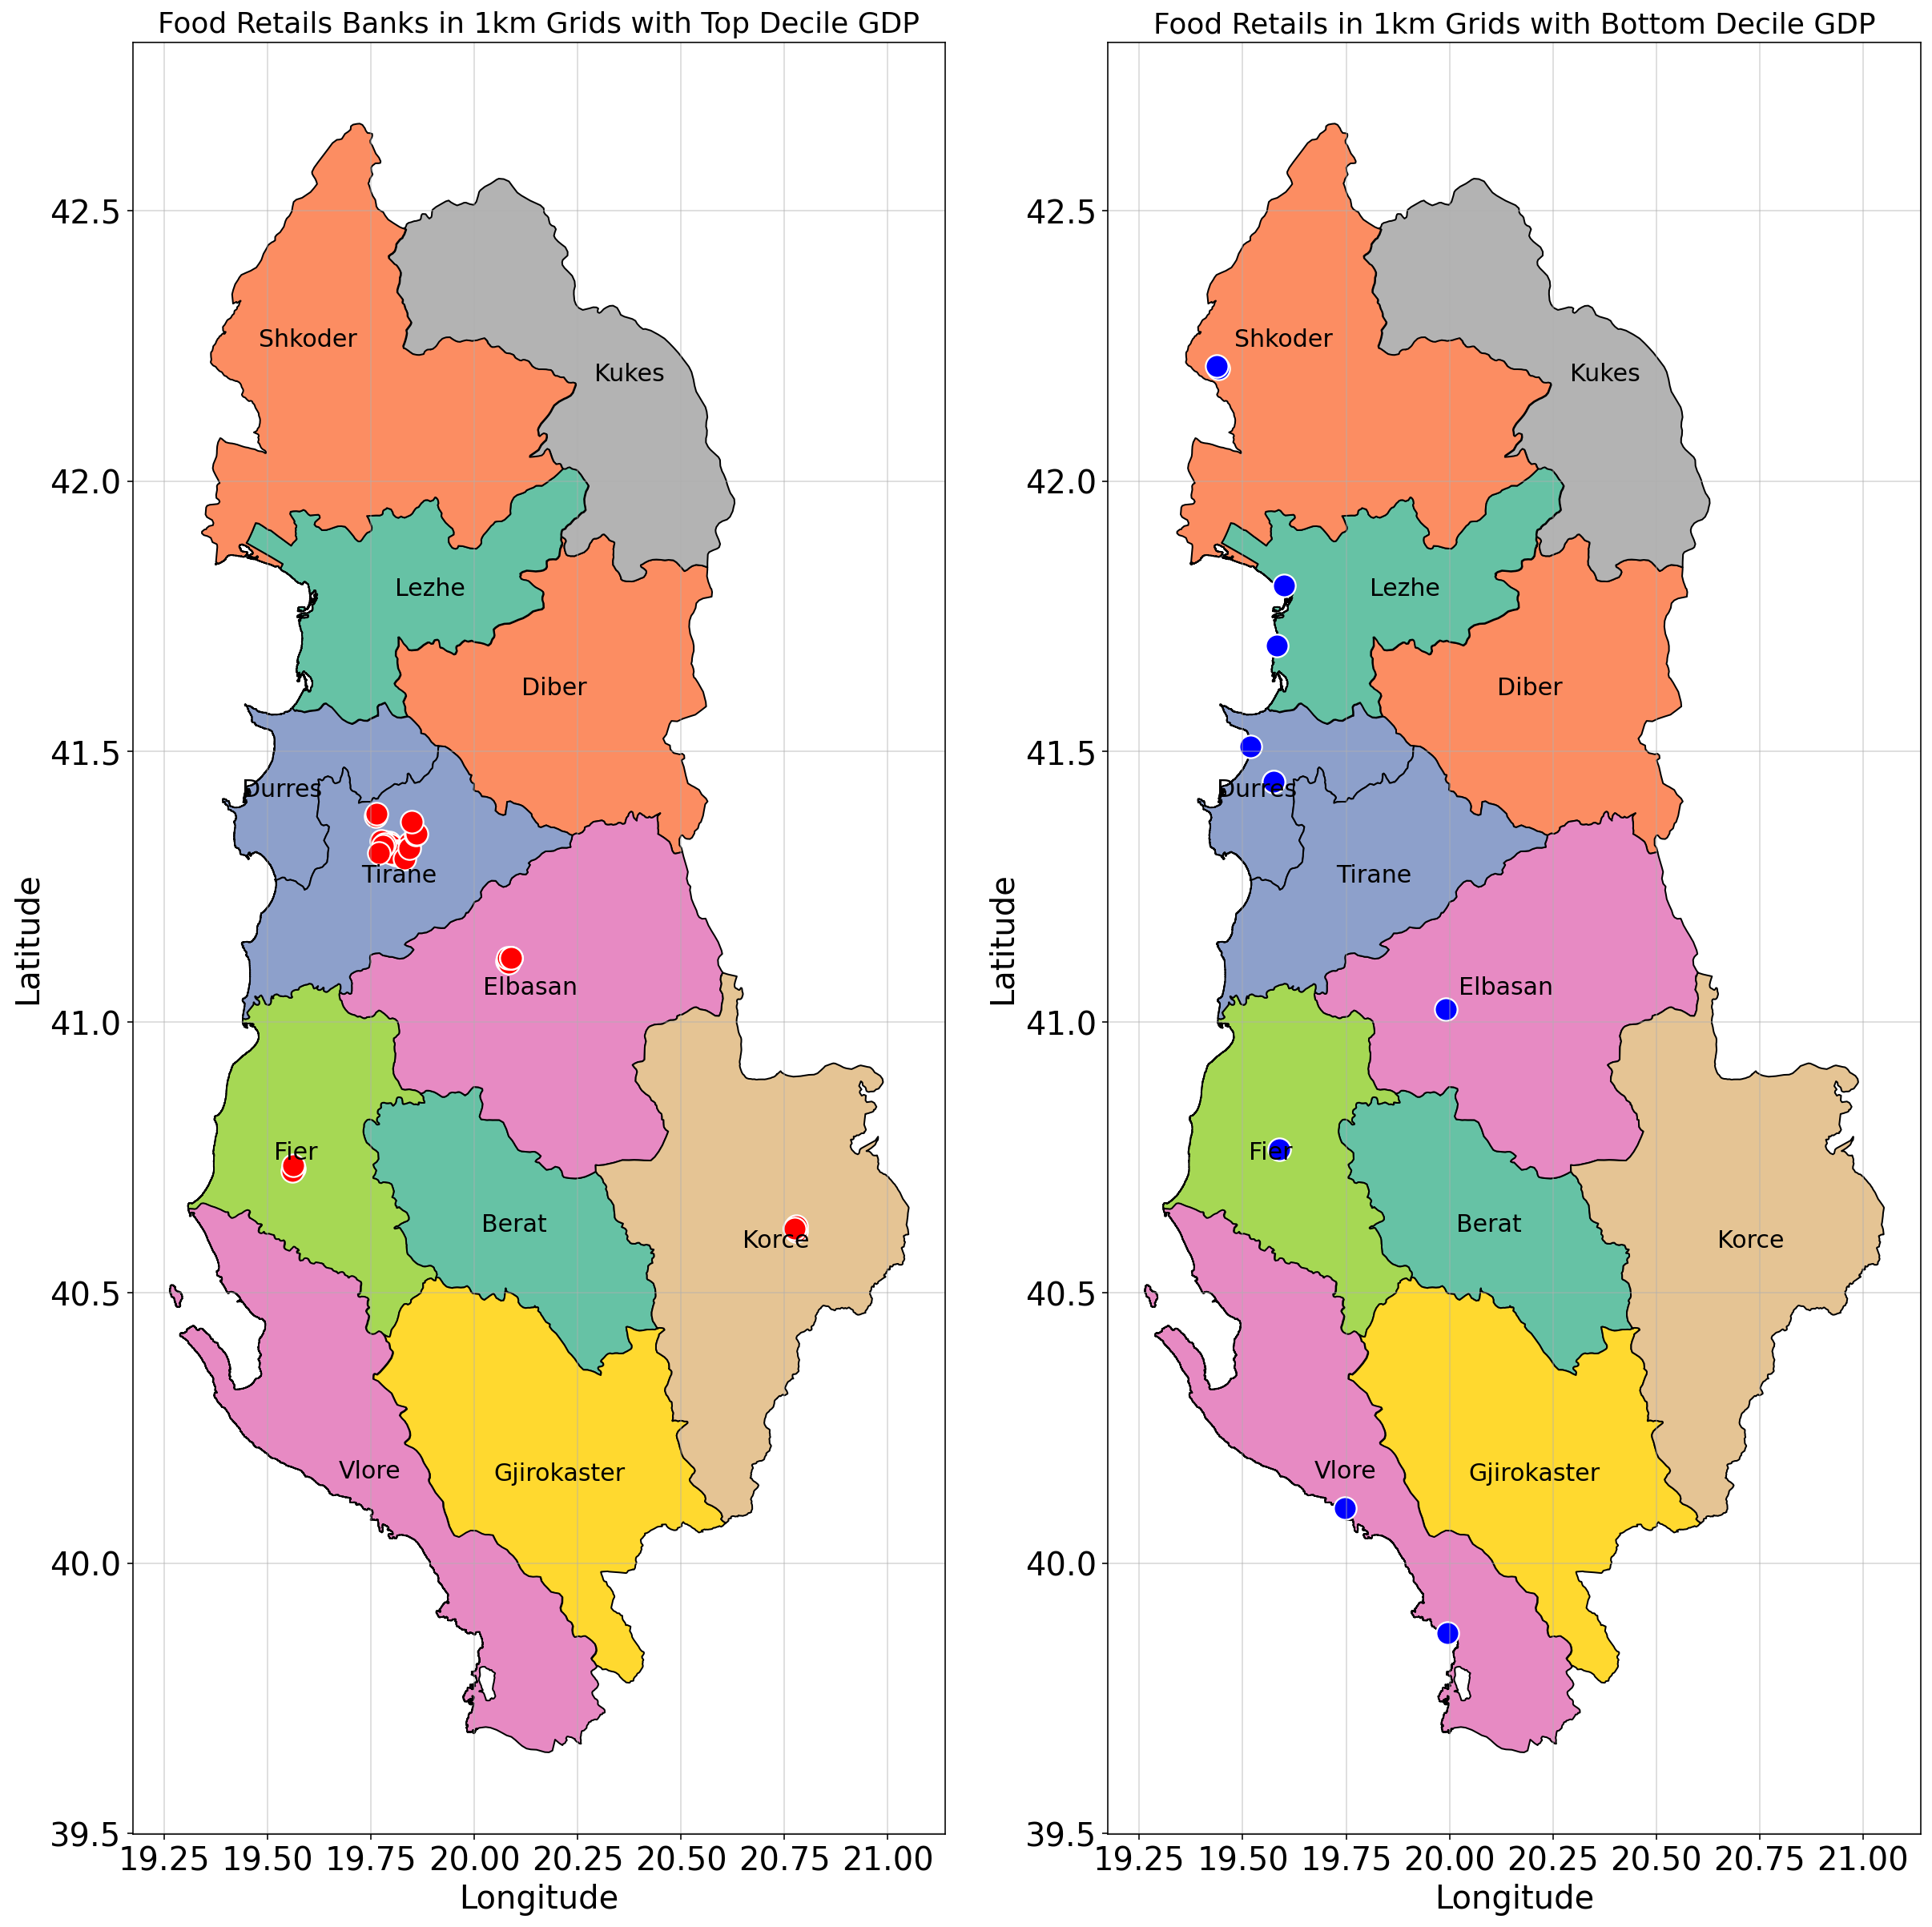

In [97]:
# initialize an axis
fig, ax = plt.subplots(1,2,figsize=(20,24),gridspec_kw={'width_ratios': [1, 1]})
plt.rcParams.update({'font.size': 15})
for i in range(len(admin['ADM1_EN'])):
    x = admin['ADM1_EN'][i]
    admin[admin['ADM1_EN']==x].plot(color=colors[i%len(colors)],edgecolor="black",
                                                 ax=ax[0])

    
admin['coords'] = admin['geometry'].apply(lambda x: x.representative_point().coords[:])
admin['coords'] = [coords[0] for coords in admin['coords']]
for idx, row in admin.iterrows():
    ax[0].annotate(text=row['ADM1_EN'], xy=row['coords'],
                     horizontalalignment='center',fontsize=15)
# plot points
sns.scatterplot(x="lng", y="lat", data=market_df_gdp_top_decile, s=200,color='red',ax=ax[0])
ax[0].set_title("Food Retails Banks in 1km Grids with Top Decile GDP")

# add grid
ax[0].grid(b=True, alpha=0.5)
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")


for i in range(len(admin['ADM1_EN'])):
    x = admin['ADM1_EN'][i]
    admin[admin['ADM1_EN']==x].plot(color=colors[i%len(colors)],edgecolor="black",
                                                 ax=ax[1])

admin['coords'] = admin['geometry'].apply(lambda x: x.representative_point().coords[:])
admin['coords'] = [coords[0] for coords in admin['coords']]
for idx, row in admin.iterrows():
    ax[1].annotate(text=row['ADM1_EN'], xy=row['coords'],
                     horizontalalignment='center',fontsize=15)
# plot points
sns.scatterplot(x="lng", y="lat", data=market_df_gdp_bottom_decile, s=200,color='blue',ax=ax[1])
ax[1].set_title("Food Retails in 1km Grids with Bottom Decile GDP")
# add grid
ax[1].grid(b=True, alpha=0.5)
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

### Population ranking

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_49227/310043102.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


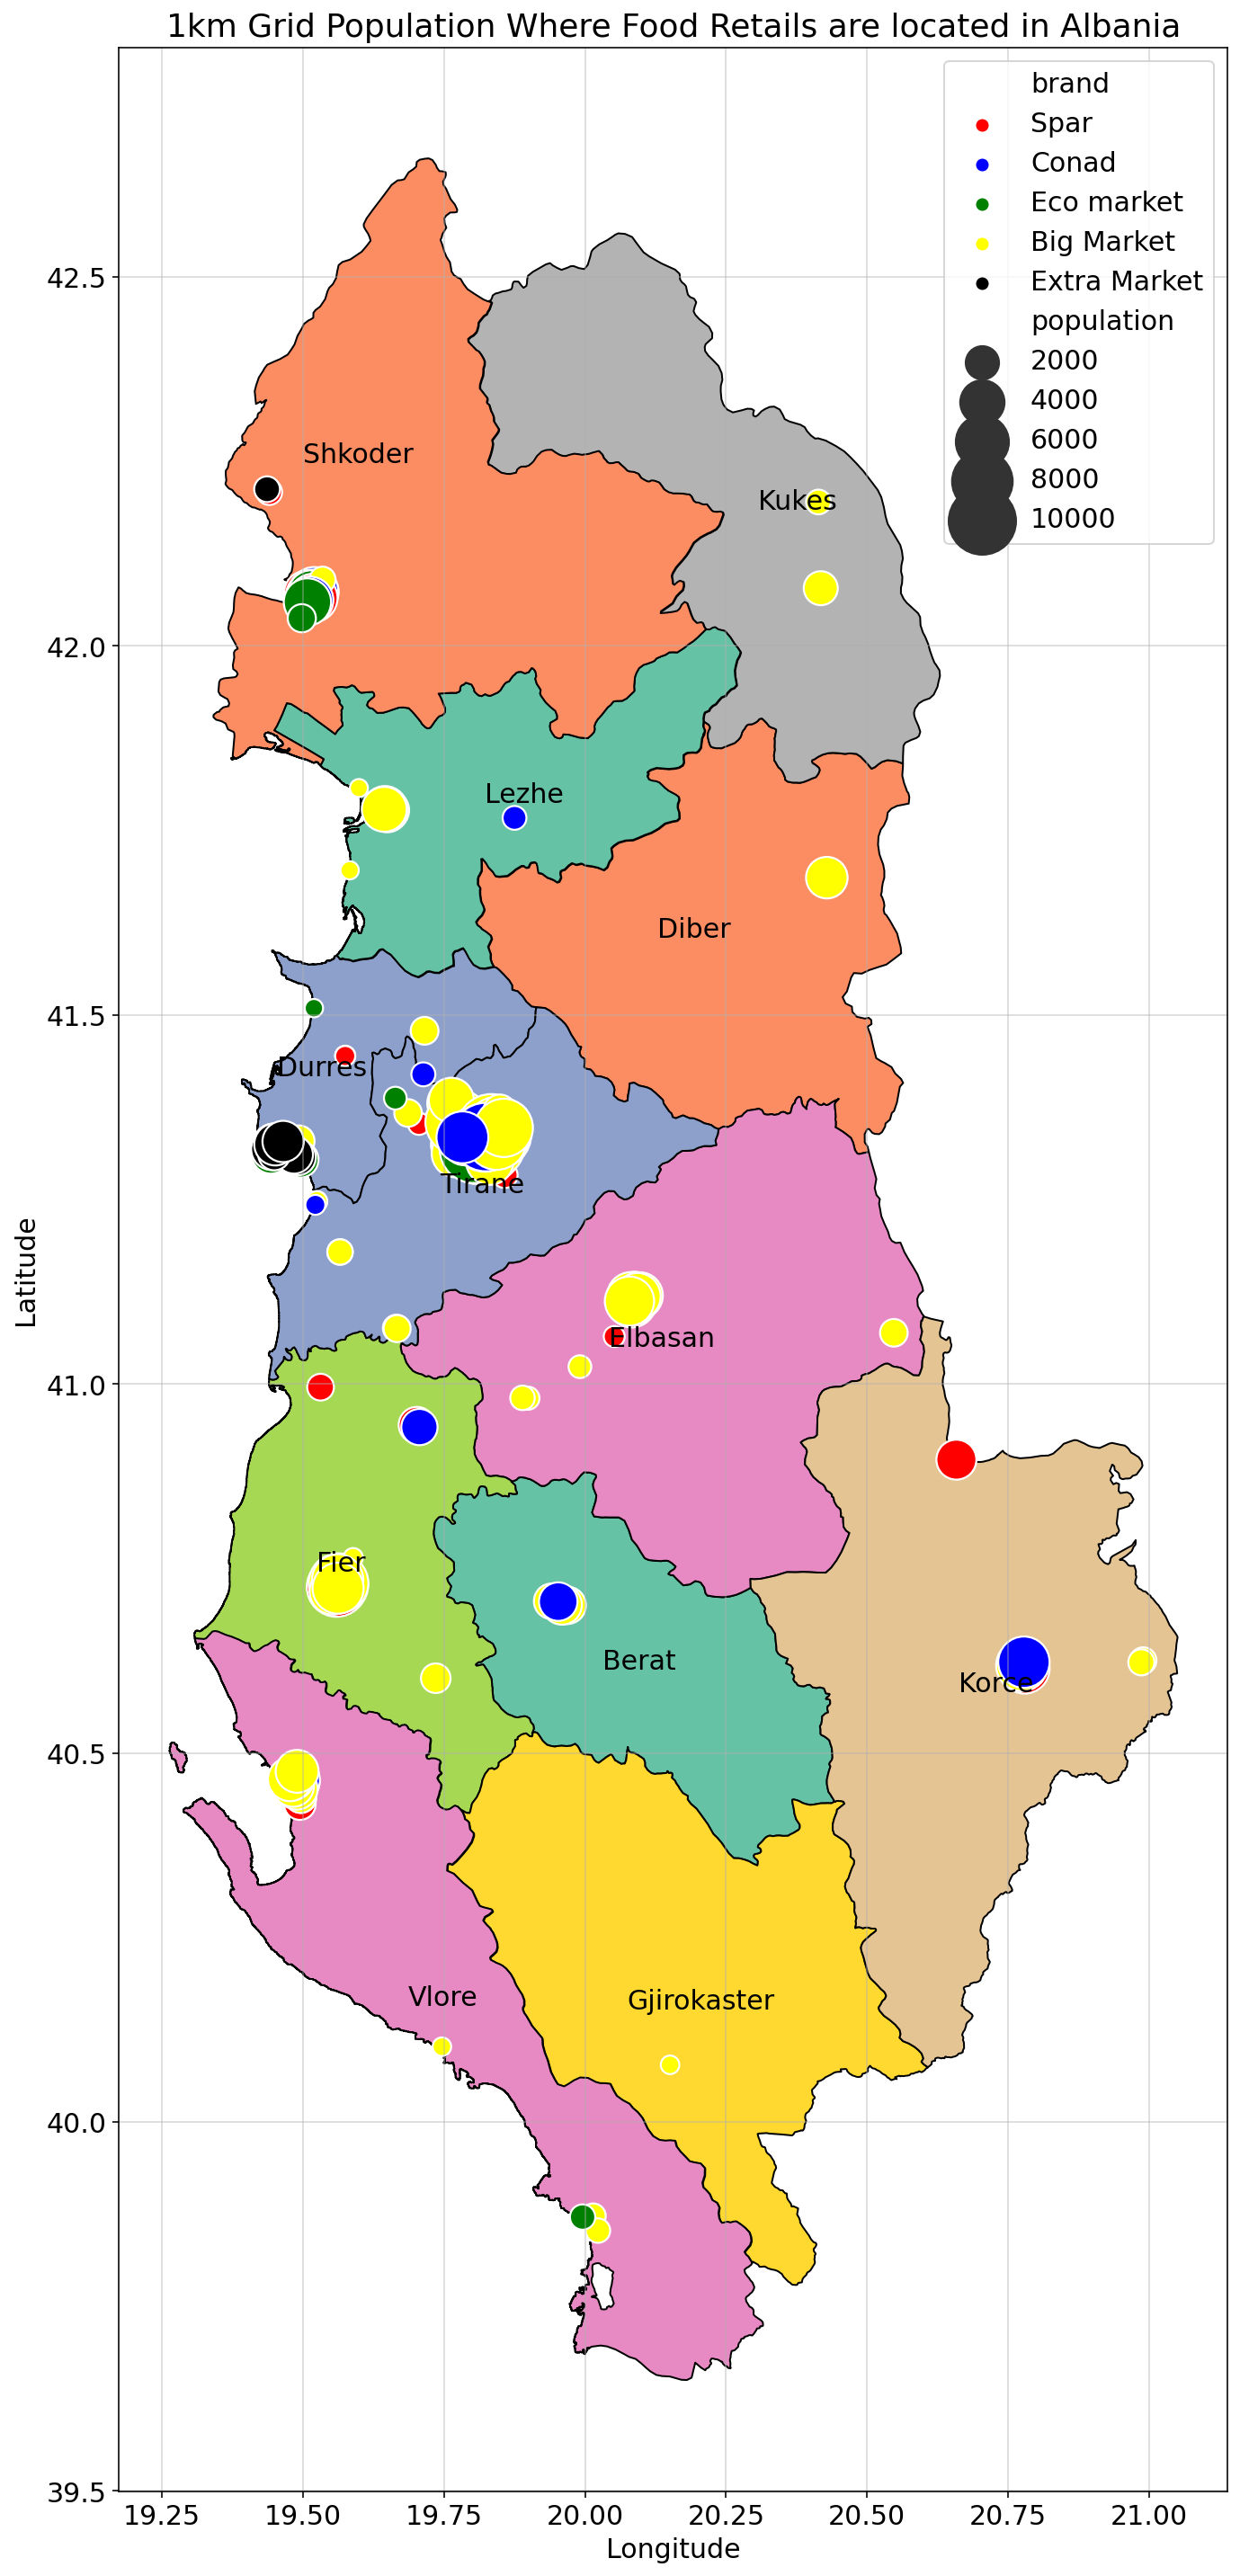

In [98]:
# initialize an axis
fig, ax = plt.subplots(figsize=(20,25))
plt.rcParams.update({'font.size': 15})
# plot map on axis
for i in range(len(admin['ADM1_EN'])):
    x = admin['ADM1_EN'][i]
    admin[admin['ADM1_EN']==x].plot(color=colors[i%len(colors)],edgecolor="black",
                                                 ax=ax)
    
    
admin['coords'] = admin['geometry'].apply(lambda x: x.representative_point().coords[:])
admin['coords'] = [coords[0] for coords in admin['coords']]
for idx, row in admin.iterrows():
    plt.annotate(text=row['ADM1_EN'], xy=row['coords'],
                 horizontalalignment='center',fontsize=15)

# plot points
sns.scatterplot(x="lng", y="lat", data=market_df, size ="population",sizes = (100,1500),hue="brand",palette=['red','blue','green','yellow','black'])
# add grid
ax.grid(b=True, alpha=0.5)
ax.legend(loc=0,prop={'size': 15})
plt.title("1km Grid Population Where Food Retails are located in Albania")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_49227/1056883048.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


Text(0.5, 1.0, '1km Grid Population Where Food Retails are Located near Tirane')

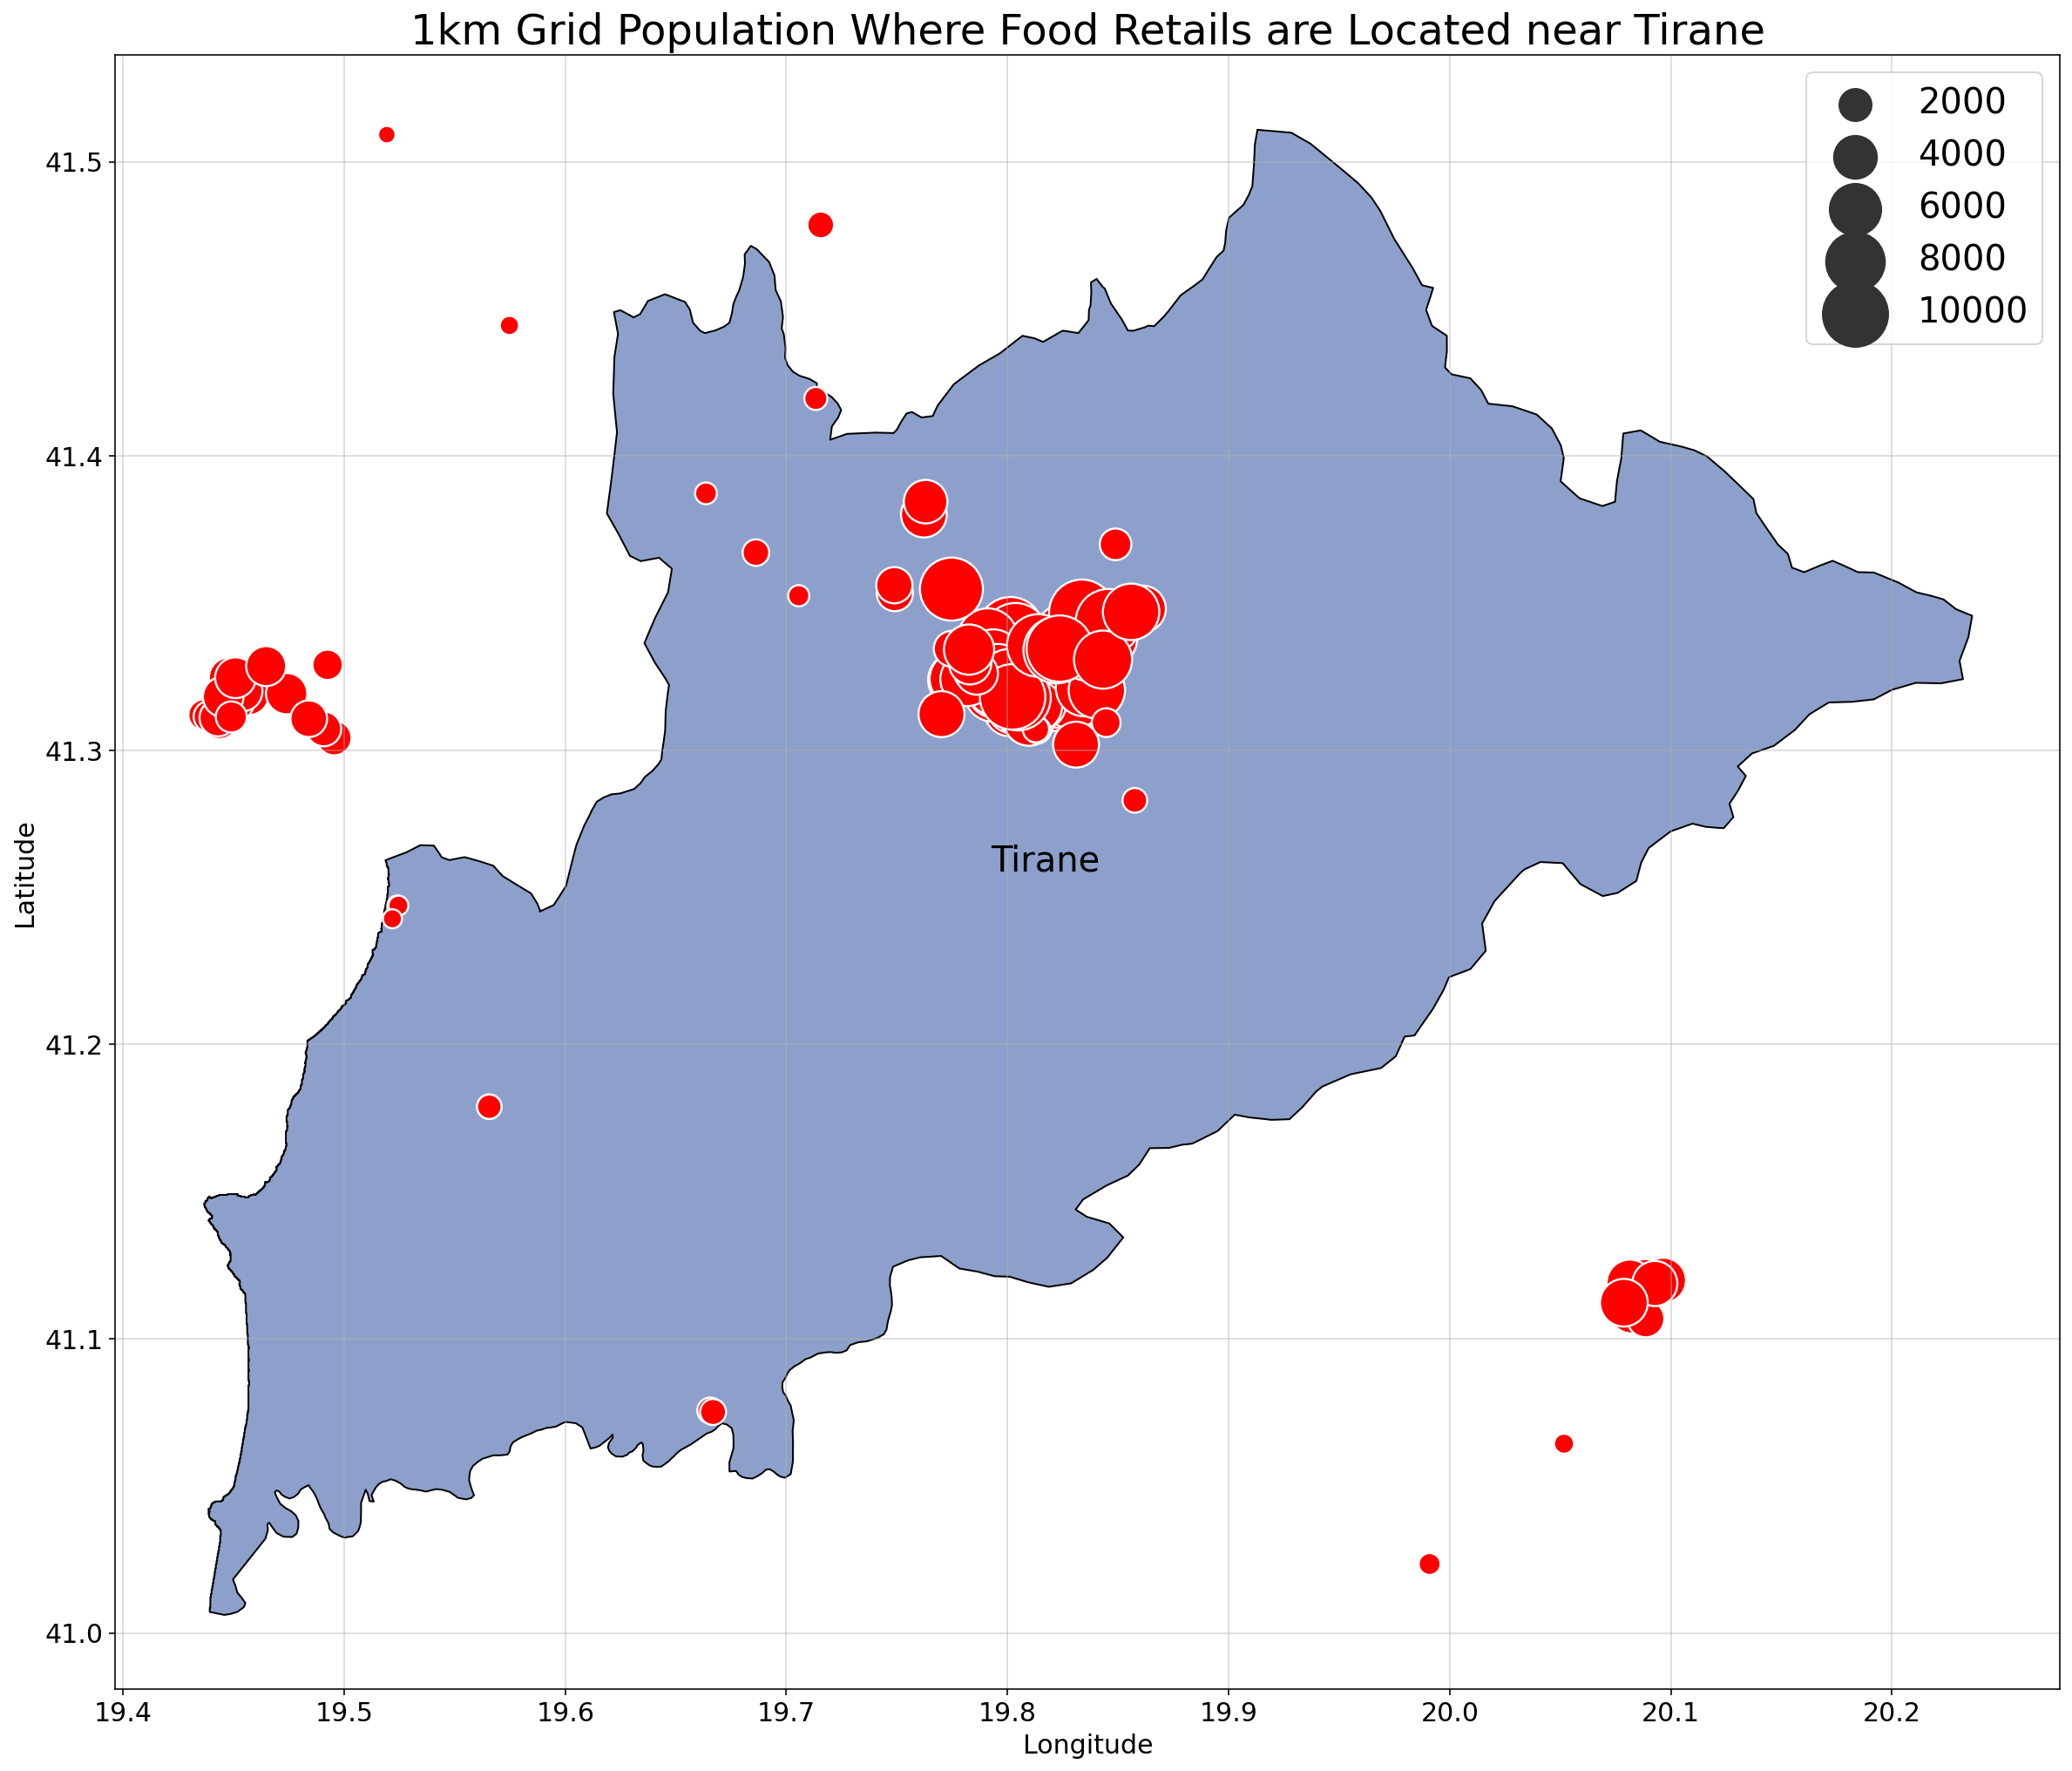

In [99]:
# initialize an axis
fig, ax = plt.subplots(figsize=(20,25))
plt.rcParams.update({'font.size': 20})
# plot map on axis
for i in range(len(admin['ADM1_EN'])):
    x = admin['ADM1_EN'][i]
    if x =='Tirane':
        admin[admin['ADM1_EN']==x].plot(color=colors[i%len(colors)],edgecolor="black",
                                                     ax=ax)

    
admin['coords'] = admin['geometry'].apply(lambda x: x.representative_point().coords[:])
admin['coords'] = [coords[0] for coords in admin['coords']]
for idx, row in admin.iterrows():
    if row['ADM1_EN']=='Tirane':
        plt.annotate(text=row['ADM1_EN'], xy=row['coords'],
                     horizontalalignment='center',fontsize=20)

# plot points
Tirane_market_df = market_df[(market_df['lng']>19.25)&(market_df['lng']<20.3)&(market_df['lat']>41)&(market_df['lat']<41.55)].copy()
sns.scatterplot(x="lng", y="lat", data=Tirane_market_df, size ="population",color='red',sizes = (100,1500))
# add grid
ax.grid(b=True, alpha=0.5)
ax.legend(loc=1,prop={'size': 20})
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("1km Grid Population Where Food Retails are Located near Tirane")


In [100]:
population_values = market_df['population']
population_cutoff = np.nanquantile(population_values,[0.05,0.1,0.3,0.5,0.7,0.9,0.95])
market_df['population_rating'] = ['nan']*len(population_values)
market_df.loc[~np.isnan(population_values),'population_rating'] = "0%-5%"
market_df.loc[population_values > population_cutoff[0],'population_rating'] = "5%-10%"
market_df.loc[population_values > population_cutoff[1],'population_rating'] = '10%-30%'
market_df.loc[population_values > population_cutoff[2],'population_rating'] = "30%-50%"
market_df.loc[population_values > population_cutoff[3],'population_rating'] = '50%-70%'
market_df.loc[population_values > population_cutoff[4],'population_rating'] = '70%-90%'
market_df.loc[population_values > population_cutoff[5],'population_rating'] = '90%-95%'
market_df.loc[population_values > population_cutoff[6],'population_rating'] = '95%-100%'
market_df['population_rank']=market_df['population'].rank(method='min',ascending=False)
market_df.sort_values(by='population',ascending=False)[['population_rank',
                                               'population_rating',
                                               'population','lat',
                                               'lng',
                                               'address',
                                               'name']]

population_rank population_rating   population        lat        lng  \
20               1.0          95%-100%  10706.29700  41.325673  19.829873   
21               1.0          95%-100%  10706.29700  41.330642  19.825115   
19               1.0          95%-100%  10706.29700  41.329106  19.826313   
42               4.0          95%-100%  10579.81100  41.330766  19.835959   
38               4.0          95%-100%  10579.81100  41.330243  19.834778   
39               4.0          95%-100%  10579.81100  41.330586  19.833771   
40               4.0          95%-100%  10579.81100  41.332764  19.837565   
41               4.0          95%-100%  10579.81100  41.327509  19.832750   
27               9.0          95%-100%  10560.04500  41.331395  19.820261   
26               9.0          95%-100%  10560.04500  41.329519  19.821699   
25               9.0          95%-100%  10560.04500  41.332917  19.822906   
135             12.0           90%-95%  10548.39300  41.338876  19.827356   
134             12.0           90%-95%  10548.39300  41.337095  19.825198   
131             14.0           90%-95%  10471.55600  41.338574  19.843703   
125             15.0           90%-95%  10448.60600  41.334903  19.836571   
126             15.0           90%-95%  10448.60600  41.336853  19.839941   
166             17.0           90%-95%  10316.78000  41.334026  19.822218   
167             17.0           90%-95%  10316.78000  41.334563  19.823633   
60              19.0           90%-95%  10304.38600  41.324882  19.804878   
61              19.0           90%-95%  10304.38600  41.329658  19.800647   
59              19.0           90%-95%  10304.38600  41.326178  19.799951   
7               22.0           70%-90%  10253.84800  41.328753  19.809930   
8               22.0           70%-90%  10253.84800  41.327175  19.807546   
9               22.0           70%-90%  10253.84800  41.327017  19.810315   
10              22.0           70%-90%  10253.84800  41.332061  19.814534   
161             26.0           70%-90%  10125.84600  41.346856  19.833668   
152             27.0           70%-90%  10040.29400  41.317892  19.804761   
151             27.0           70%-90%  10040.29400  41.323357  19.801219   
150             27.0           70%-90%  10040.29400  41.320792  19.803060   
153             27.0           70%-90%  10040.29400  41.318161  19.802307   
164             31.0           70%-90%  10015.78600  41.343702  19.845601   
36              32.0           70%-90%   9994.81200  41.322403  19.808245   
28              32.0           70%-90%   9994.81200  41.323098  19.808552   
31              32.0           70%-90%   9994.81200  41.321262  19.809685   
29              32.0           70%-90%   9994.81200  41.321625  19.814280   
37              32.0           70%-90%   9994.81200  41.319046  19.807172   
30              32.0           70%-90%   9994.81200  41.316654  19.807580   
35              32.0           70%-90%   9994.81200  41.322243  19.808246   
34              32.0           70%-90%   9994.81200  41.319209  19.813016   
33              32.0           70%-90%   9994.81200  41.321808  19.814485   
32              32.0           70%-90%   9994.81200  41.322326  19.808276   
55              42.0           70%-90%   9895.24400  41.339016  19.803586   
54              42.0           70%-90%   9895.24400  41.341043  19.801397   
3               44.0           70%-90%   9611.05400  41.323986  19.823236   
2               44.0           70%-90%   9611.05400  41.321775  19.823642   
4               44.0           70%-90%   9611.05400  41.317293  19.819046   
1               44.0           70%-90%   9611.05400  41.318041  19.816914   
56              48.0           70%-90%   9411.96700  41.318162  19.825325   
57              48.0           70%-90%   9411.96700  41.319569  19.826427   
58              48.0           70%-90%   9411.96700  41.318023  19.829511   
143             51.0           70%-90%   9247.78300  41.354783  19.774649   
1

In [101]:
market_df_pop_top_decile = market_df.loc[market_df['population_rating'].isin(['95%-100%','90%-95%']),
                             ['population_rank','population_rating','population','lat',
                              'lng','address','name','loc_admin']].sort_values(by='population_rank')
display(market_df_pop_top_decile)

market_df_pop_bottom_decile = market_df.loc[market_df['population_rating'].isin(['0%-5%','5%-10%']),
                             ['population_rank','population_rating','population','lat',
                              'lng','address','name','loc_admin']].sort_values(by='population_rank',ascending=False)
display(market_df_pop_bottom_decile)

population_rank population_rating  population        lat        lng  \
19               1.0          95%-100%   10706.297  41.329106  19.826313   
20               1.0          95%-100%   10706.297  41.325673  19.829873   
21               1.0          95%-100%   10706.297  41.330642  19.825115   
41               4.0          95%-100%   10579.811  41.327509  19.832750   
40               4.0          95%-100%   10579.811  41.332764  19.837565   
39               4.0          95%-100%   10579.811  41.330586  19.833771   
42               4.0          95%-100%   10579.811  41.330766  19.835959   
38               4.0          95%-100%   10579.811  41.330243  19.834778   
27               9.0          95%-100%   10560.045  41.331395  19.820261   
26               9.0          95%-100%   10560.045  41.329519  19.821699   
25               9.0          95%-100%   10560.045  41.332917  19.822906   
134             12.0           90%-95%   10548.393  41.337095  19.825198   
135             12.0           90%-95%   10548.393  41.338876  19.827356   
131             14.0           90%-95%   10471.556  41.338574  19.843703   
125             15.0           90%-95%   10448.606  41.334903  19.836571   
126             15.0           90%-95%   10448.606  41.336853  19.839941   
166             17.0           90%-95%   10316.780  41.334026  19.822218   
167             17.0           90%-95%   10316.780  41.334563  19.823633   
59              19.0           90%-95%   10304.386  41.326178  19.799951   
60              19.0           90%-95%   10304.386  41.324882  19.804878   
61              19.0           90%-95%   10304.386  41.329658  19.800647   

                                               address  \
19   8RHG+JGW, Rruga Tefta Tashko-Koço, Tirana, Alb...   
20        Rruga Petro Nini Luarasi 14, Tiranë, Albania   
21                           8RJG+72G, Tirana, Albania   
41           Rruga Ali Demi nr 4, Tirana 1001, Albania   
40                Rruga Sitki Çiço 12, Tirana, Albania   
39     8RJM+6FQ, Bulevardi Zhan D'Ark, Tiranë, Albania   
42   8RJP+894, Rruga: Bulevardi Bajram Curri, Brryl...   
38              Bajram Curri Blvd 282, Tirana, Albania   
27   Rr. e Barrikadave, Ish Kinema 17 Nentori, Tira...   
26      8RHC+RM4, Rruga e Barrikadave, Tirana, Albania   
25           8RMF+556, Rruga e Dibrës, Tirana, Albania   
134          8RPG+R3P, Rruga e Dibrës, Tirana, Albania   
135       8RQG+GWX, Rruga Riza Cerova, Tirana, Albania   
131           Rruga Marie Logoreci 40, Tirana, Albania   
125     8RMP+XJ8, Rruga Xhanfize Keko, Tiranë, Albania   
126       Rruga Xhanfize Keko 43, Tiranë 1001, Albania   
166        8RMC+JV8, Rruga Siri Kodra, Tirana, Albania   
167  Rr. e Dibrës, Kompleksi Halil, Tirana 1001, Al...   
59                           8QGX+FXP, Tirana, Albania   
60          Rruga Sulejman Pitarka 14, Tirana, Albania   
61                  Rruga Studenti 20, Tirana, Albania   

                       name loc_admin  
19         Spar Pazari i Ri    Tirane  
20               Big Market    Tirane  
21                    Conad    Tirane  
41               Big Market    Tirane  
40               Big Market    Tirane  
39               Big Market    Tirane  
42        Eco Market Brryli    Tirane  
38                     SPAR    Tirane  
27          Conad Barrikada    Tirane  
26               Big Market    Tirane  
25              Spar Market    Tirane  
134              Big Market    Tirane  
135      Eco Market Medrese    Tirane  
131              Big Market    Tirane  
125              Big Market    Tirane  
126          Conad Profarma    Tirane  
166   Big market siri kodra    Tirane  
167      Conad Rr. e Dibrës    Tirane  
59                     Spar    Tirane  
60               Big Market    Tirane  
61   Eco Market 21 Dhjetori    Tirane

population_rank population_rating  population        lat        lng  \
136            217.0             0%-5%   146.11494  41.807487  19.599075   
163            216.0             0%-5%   166.17981  41.696070  19.582691   
211            215.0             0%-5%   173.87381  41.509246  19.519311   
186            214.0             0%-5%   192.27563  40.077452  20.150726   
169            213.0             0%-5%   193.42738  40.101984  19.746248   
175            212.0             0%-5%   266.91245  40.764597  19.588877   
200            211.0             0%-5%   317.89148  41.242737  19.521853   
44             209.0             0%-5%   329.82904  41.444394  19.574768   
43             209.0             0%-5%   329.82904  41.444813  19.574743   
73             207.0             0%-5%   394.14917  41.247224  19.524550   
72             207.0             0%-5%   394.14917  41.247276  19.524034   
191            206.0            5%-10%   396.58510  40.710895  19.547815   
108            205.0            5%-10%   409.82310  41.064338  20.051697   
114            204.0            5%-10%   531.86395  41.352523  19.705595   
210            203.0            5%-10%   594.61580  41.387322  19.663643   
192            202.0            5%-10%   599.07980  41.023436  19.990899   
173            201.0            5%-10%   635.33350  40.980746  19.898679   
202            200.0            5%-10%   712.84515  41.767080  19.874969   
201            199.0            5%-10%   730.64660  41.419576  19.713328   
182            198.0            5%-10%   784.45026  39.852833  20.022889   
185            197.0            5%-10%   788.17550  40.981176  19.889099   
124            196.0            5%-10%   812.88727  42.195121  20.413723   

                                               address  \
136                        RH4X+XJW, Shëngjin, Albania   
163                            MHWM+C3G, Tale, Albania   
211  Kompleksi Lura 2 Gjiri i Lalezi, Durres, Plazh...   
186  35G2+X7Q, Rruga Gjin Zenebisi, Gjirokaster, Al...   
169                       SH8 20, Himarë 9425, Albania   
175                                       SH4, Albania   
200                Rruga Ismail Qemali, Golem, Albania   
44           CHVF+QW2, Rruga Lalëzit, Shkallë, Albania   
43                          CHVF+WVH, Shkallë, Albania   
73                            6GWF+VRM, Golem, Albania   
72                            6GWF+WJ7, Golem, Albania   
191         Rruga Unaza Nuredin Aliu 25, Fier, Albania   
108                               Kuqan Kuqan, Albania   
114  9P34+265, Bulevardi Kasharit, tek pallatet e I...   
210          9MP7+WFC, Rruga Dardania, Kashar, Albania   
192                          2XFR+J3P, Cërrik, Albania   
173                           XVJX+7FV, Belsh, Albania   
202                         QV8F+RWP, Rrëshen, Albania   
201                                Airport Rd, Albania   
182                   V23F+45J, SH81, Sarandë, Albania   
185                           Rruga 31 Gushti, Albania   
124                 5CW7+2FX, Rruga Besa, Has, Albania   

                                                  name    loc_admin  
136                                         Big Market        Lezhe  
163                                         Big Market        Lezhe  
211                                         Eco Market       Durres  
186                                         BIG MARKET  Gjirokaster  
169                                         Big Market        Vlore  
175                                    Big Market Viva         Fier  
200                                  Supermarket Conad       Tirane  
44                        SPAR Gjiri i Lalezit (Manez)       Durres  
43                                        Spar Albania       Durres  
73                                          Big Market       Tirane  
72                                          Spar Golem       Tirane  
191                                         Big Market         Fier  
108        

/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_49227/3966764921.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b=True, alpha=0.5)
/var/folders/g3/gw7r7tvj63j5wjhsmmnq03qr0000gn/T/ipykernel_49227/3966764921.py:38: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[1].grid(b=True, alpha=0.5)


Text(733.2272727272725, 0.5, 'Latitude')

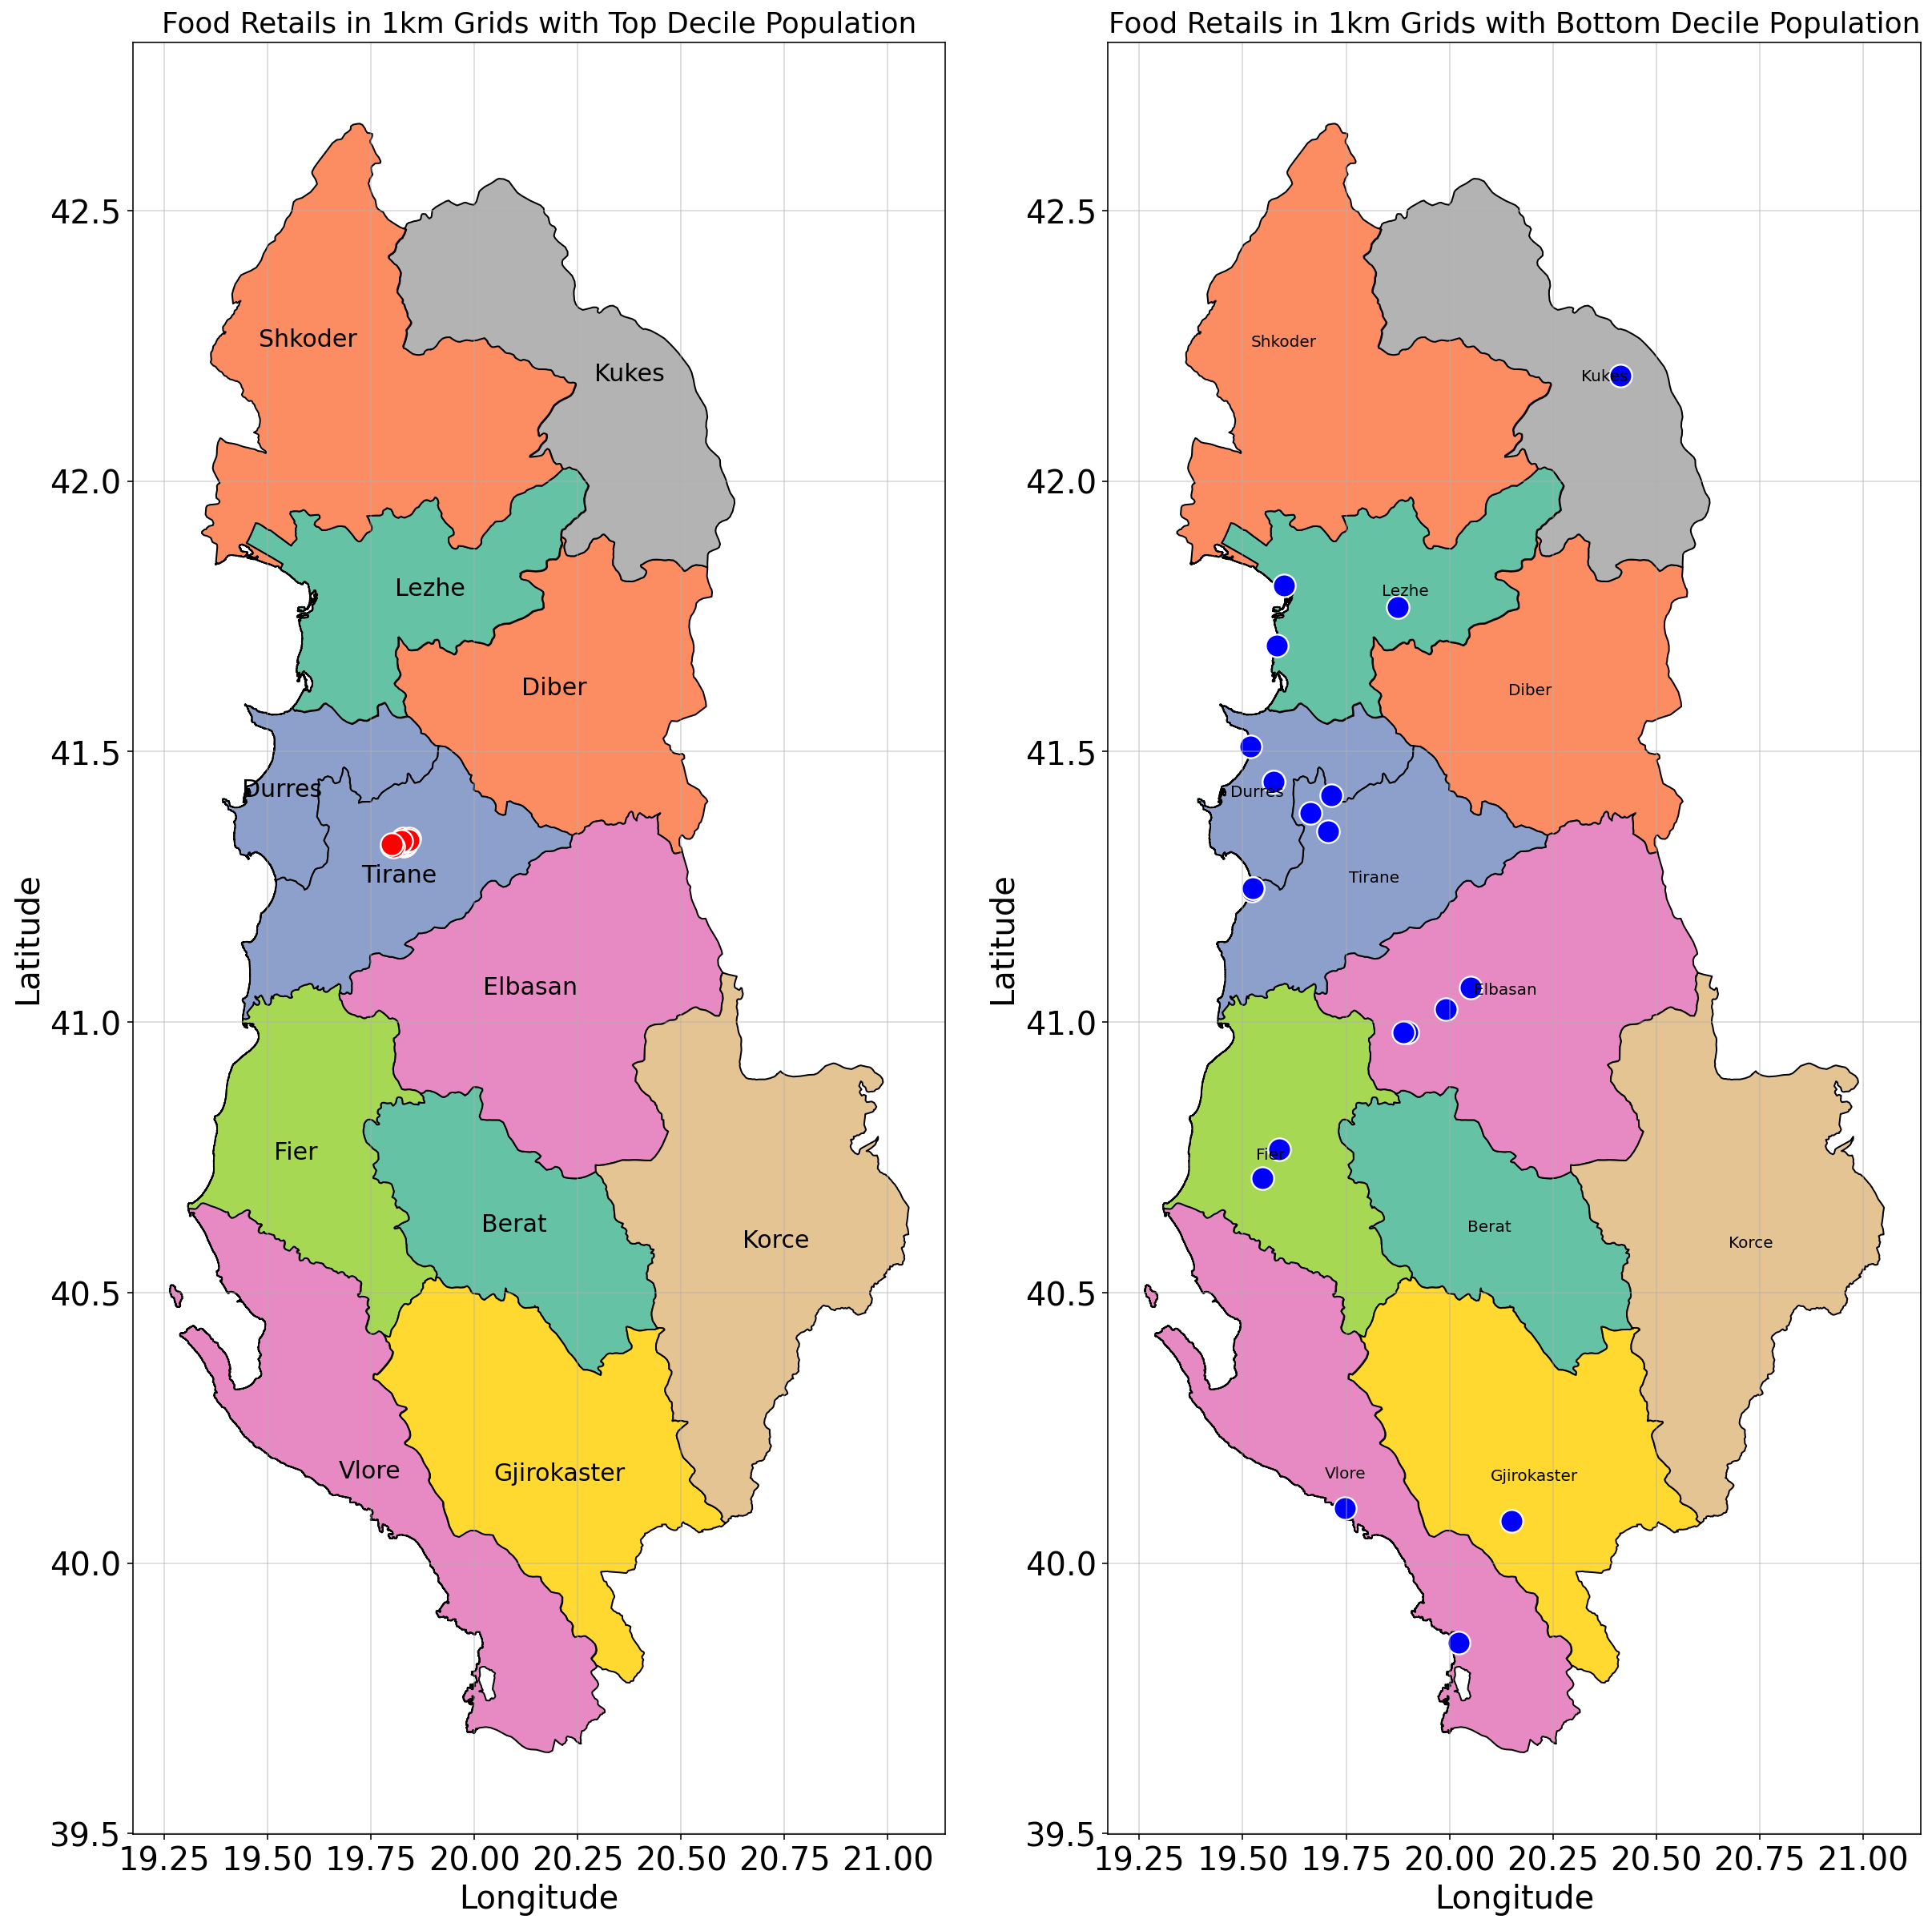

In [102]:
# initialize an axis
fig, ax = plt.subplots(1,2,figsize=(20,24),gridspec_kw={'width_ratios': [1, 1]})
plt.rcParams.update({'font.size': 15})
for i in range(len(admin['ADM1_EN'])):
    x = admin['ADM1_EN'][i]
    admin[admin['ADM1_EN']==x].plot(color=colors[i%len(colors)],edgecolor="black",
                                                 ax=ax[0])

    
admin['coords'] = admin['geometry'].apply(lambda x: x.representative_point().coords[:])
admin['coords'] = [coords[0] for coords in admin['coords']]
for idx, row in admin.iterrows():
    ax[0].annotate(text=row['ADM1_EN'], xy=row['coords'],
                     horizontalalignment='center',fontsize=15)
# plot points
sns.scatterplot(x="lng", y="lat", data=market_df_pop_top_decile, s=200,color='red',ax=ax[0])
ax[0].set_title("Food Retails in 1km Grids with Top Decile Population")

# add grid
ax[0].grid(b=True, alpha=0.5)
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

for i in range(len(admin['ADM1_EN'])):
    x = admin['ADM1_EN'][i]
    admin[admin['ADM1_EN']==x].plot(color=colors[i%len(colors)],edgecolor="black",
                                                 ax=ax[1])

admin['coords'] = admin['geometry'].apply(lambda x: x.representative_point().coords[:])
admin['coords'] = [coords[0] for coords in admin['coords']]
for idx, row in admin.iterrows():
    ax[1].annotate(text=row['ADM1_EN'], xy=row['coords'],
                     horizontalalignment='center',fontsize=10)
# plot points
sns.scatterplot(x="lng", y="lat", data=market_df_pop_bottom_decile, s=200,color='blue',ax=ax[1])
ax[1].set_title("Food Retails in 1km Grids with Bottom Decile Population")
# add grid
ax[1].grid(b=True, alpha=0.5)
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

In [103]:
market_df

name  \
0                                         Spar Albania   
1                                                 Spar   
2                                                 Spar   
3                                                Conad   
4                                       Conad Akademia   
5                                 Spar Hypermarket QTU   
6                                   Conad Albania shpk   
7                                          Spar Market   
8                                                Conad   
9                             Eco Market Rruga Kavajes   
10                                          Eco Market   
11                                 Spar Komuna Parisit   
12                                          Big Market   
13                                               Conad   
14                                     Eco Market Kika   
15                                   Eco Market Komuna   
16                                                SPAR   
17                                MARKET CONAD KLELAND   
18                                    SPAR SUPERMARKET   
19                                    Spar Pazari i Ri   
20                                          Big Market   
21                                               Conad   
22                                Spar Albania Elbasan   
23                                  Spar Parku Elbasan   
24                                   SPAR MARKET RINIA   
25                                         Spar Market   
26                                          Big Market   
27                                     Conad Barrikada   
28                                         Spar Market   
29                                          Big Market   
30                                          Big Market   
31                                  Big Market Premium   
32                                               CONAD   
33                                        Conad Blloku   
34                                               Conad   
35                                       Conad Gjykata   
36                                     Pronatyra Conad   
37                                        Extra Market   
38                                                SPAR   
39                                          Big Market   
40                                          Big Market   
41                                          Big Market   
42                                   Eco Market Brryli   
43                                        Spar Albania   
44                        SPAR Gjiri i Lalezit (Manez)   
45                                                SPAR   
46                                          Big Market   
47                                Eco Market Yzberisht   
48                                    SPAR Supermarket   
49                             Big Market (beselidhja)   
50                                                Spar   
51                                          Big Market   
52                                               Conad   
53                                    Conad Delijorgji   
54                                                Spar   
55                                          Big Market   
56                                                Spar   
57                                          Big Market   
58                                               Conad   
59                                                Spar   
60                                          Big Market   
61                              Eco Market 21 Dhjetori   
62                                                SPAR   
63                                         SPAR Market   
64                                    SPAR MARKET CITY   
65                                          Big Market   
66                                                SPAR   
67                                    Big Market Lezhë   
68                                       SPAR Co

In [104]:
%%time
# save the data to csv 
market_df.to_csv(os.path.join(data_out_path, "market_df_v0_2022_0705.csv"))

CPU times: user 5.36 ms, sys: 2.22 ms, total: 7.58 ms
Wall time: 6.58 ms
